In [435]:
import sys
sys.path.append("/Users/arames52/bcg_dust_continuum/src/")
import glob
import statmorph
import photutils
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.io import fits
import scipy.ndimage as ndi
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.nddata import Cutout2D
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.visualization import simple_norm, ZScaleInterval, MinMaxInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization.stretch import LinearStretch, LogStretch, SqrtStretch
from statmorph.utils.image_diagnostics import make_figure
import warnings
from astropy.wcs import FITSFixedWarning
warnings.filterwarnings('ignore', category=FITSFixedWarning)
from astropy.coordinates import Angle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
import pickle
from ast import literal_eval
plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.max_open_warning': 1000})
from radio_beam import Beam

In [449]:
alma_images_path = "/Users/arames52/bcg_dust_continuum/notebook/data/MW_images/ALMA_images/"

In [437]:
def read_alma_fits(file):
    hdu = fits.open(file)[0]
    header = hdu.header
    data = hdu.data[0,0,:,:]
    wcs = WCS(header, naxis = 2)
    data = np.nan_to_num(data)
    return data,header,wcs

def image_cutout(file, size_in_arcsec):
    data,header,wcs = read_alma_fits(file)
    ra, dec = header['CRVAL1'], header['CRVAL2']
    position = SkyCoord(ra, dec, frame = 'fk5', unit = 'deg')
    s = size_in_arcsec
    size = u.Quantity((s,s), u.arcsec)
    cutout = Cutout2D(data, position = position, size = size, wcs = wcs)
    return cutout

In [438]:
def compute_sersic(bcg_name):

    file = glob.glob(image_path + bcg_name +"*.fits")[0]
    data, header, wcs = read_alma_fits(file)
    
    image = image_cutout(file, 8).data   
    weightmap = np.full(image.shape, 2e-5)
    threshold = photutils.detect_threshold(image, 1.5)
    segm = photutils.detect_sources(image, threshold, npixels = 5)
    label = np.argmax(segm.areas) + 1
    segmap = segm.data == label
    segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
    segmap = np.int64(segmap_float > 0.5)
    source_morphs = statmorph.source_morphology(image, segmap, weightmap = weightmap)
    morph = source_morphs[0]

    return morph

In [439]:
def compute_sersic_beam(bcg_name):
    file = glob.glob(image_path + bcg_name +"*.fits")[0]
    data, header, wcs = read_alma_fits(file)

    my_beam = Beam.from_fits_header(header)
    pix_scale = round(header['CDELT2'] * 3600, 3) * u.arcsec
    gauss_kern = my_beam.as_kernel(pix_scale)
    psf = gauss_kern.array

    image = image_cutout(file, 8).data   
    weightmap = np.full(image.shape, 2e-5)
    threshold = photutils.detect_threshold(image, 1.5)
    segm = photutils.detect_sources(image, threshold, npixels = 5)
    label = np.argmax(segm.areas) + 1
    segmap = segm.data == label
    segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
    segmap = np.int64(segmap_float > 0.5)
    source_morphs = statmorph.source_morphology(image, segmap, weightmap = weightmap, psf = psf)
    morph = source_morphs[0]
    return morph

In [440]:
sersic_dict = {}

In [441]:
psf_bcgs = [x for x in good_detections if x not in well_fit_sersic]

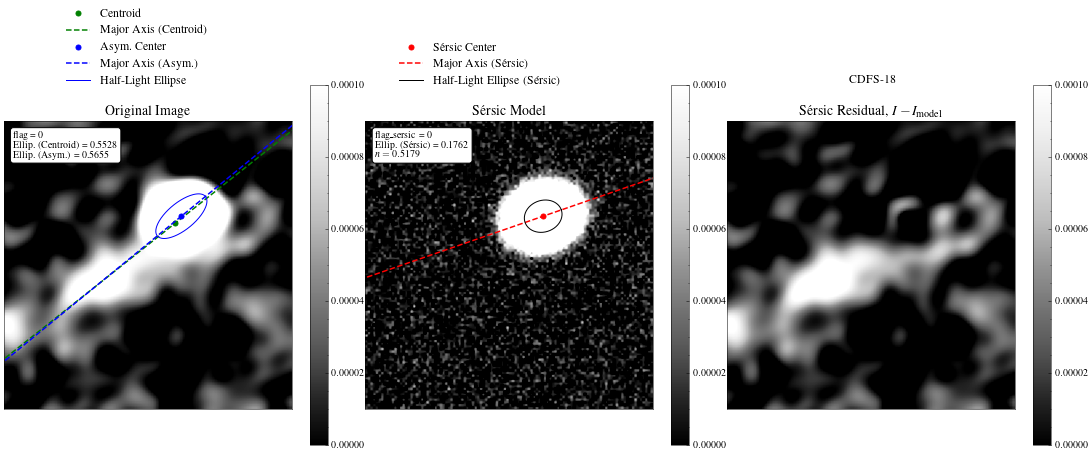

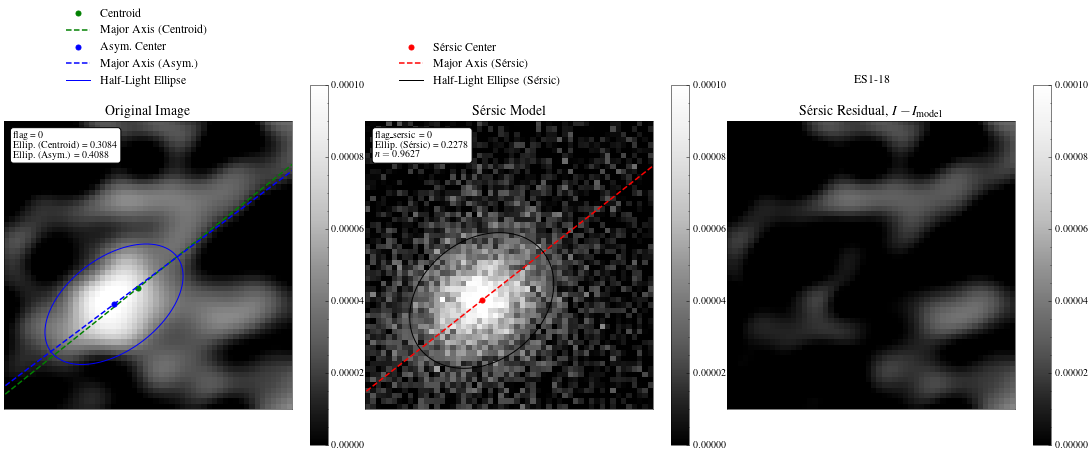

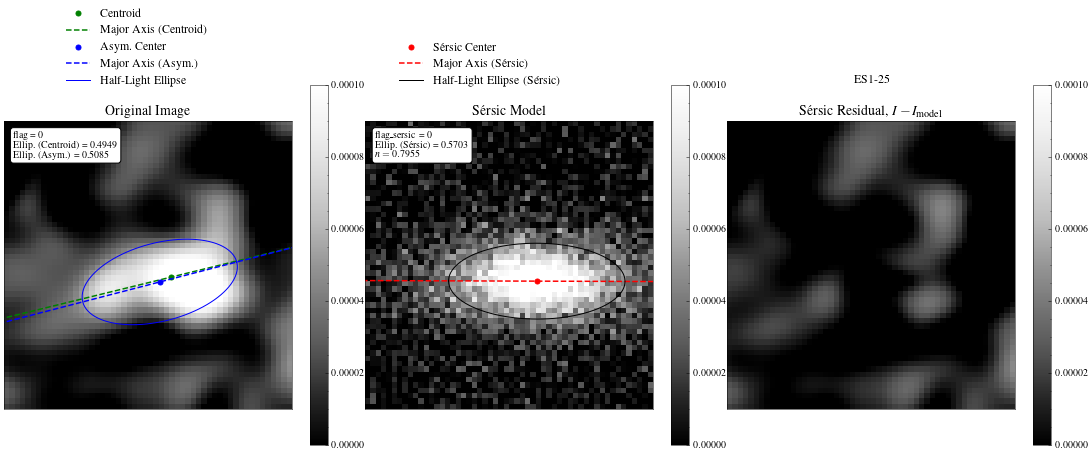

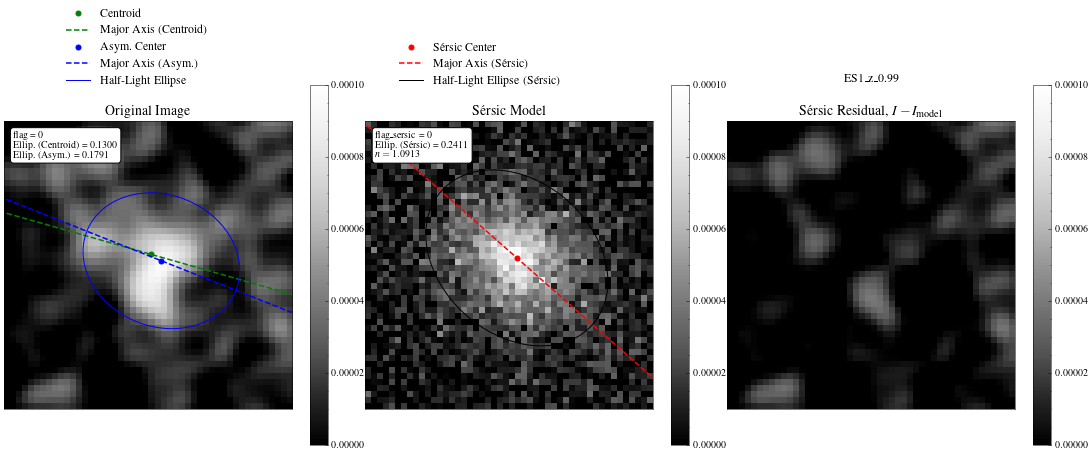

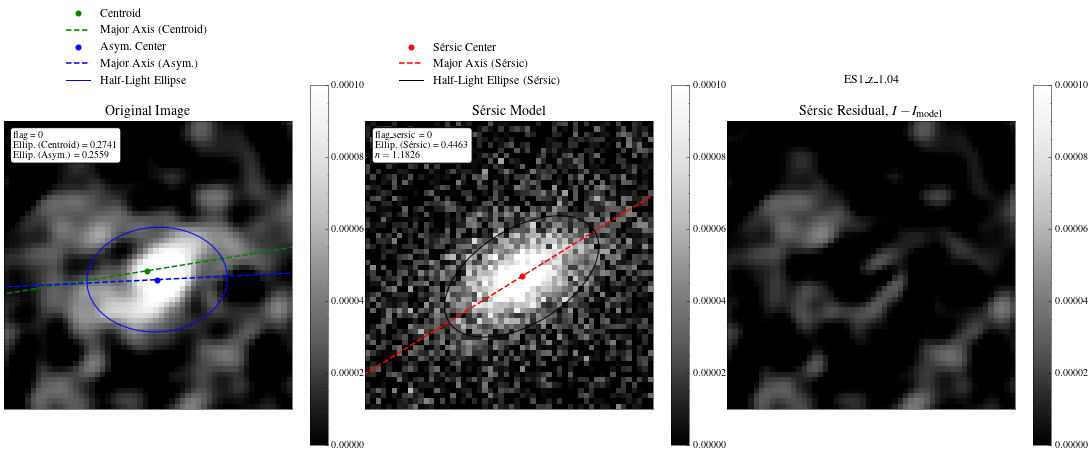

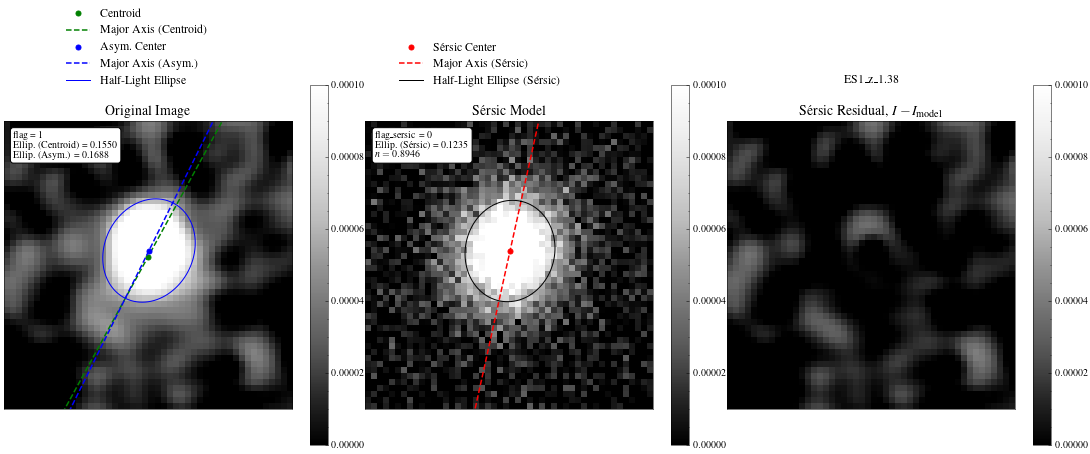

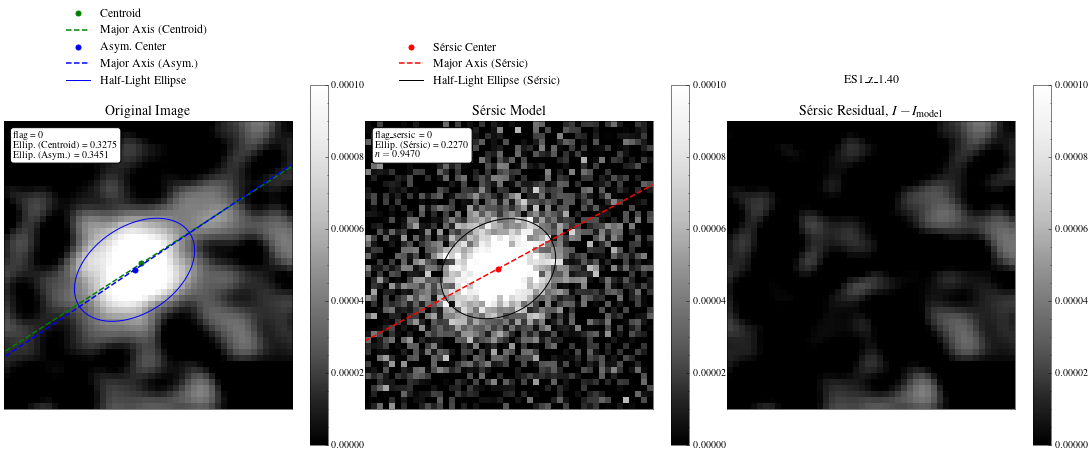

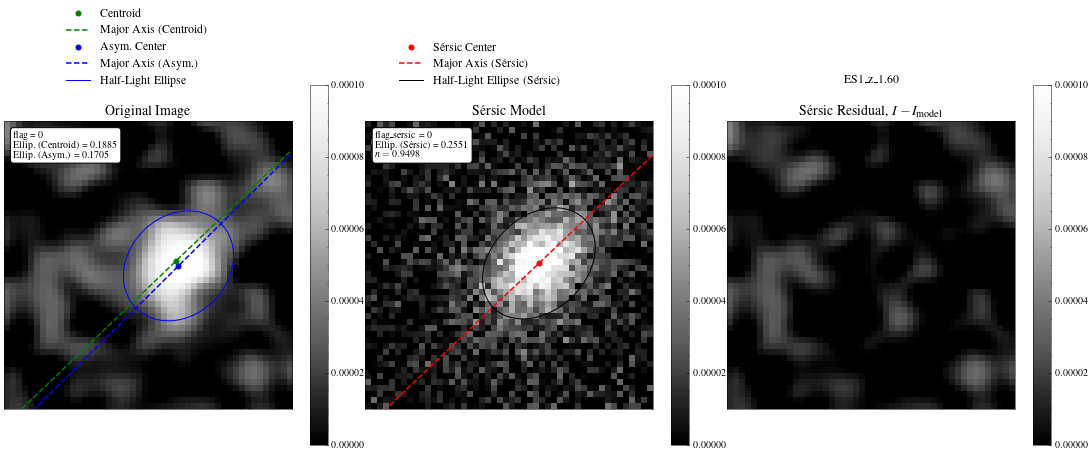

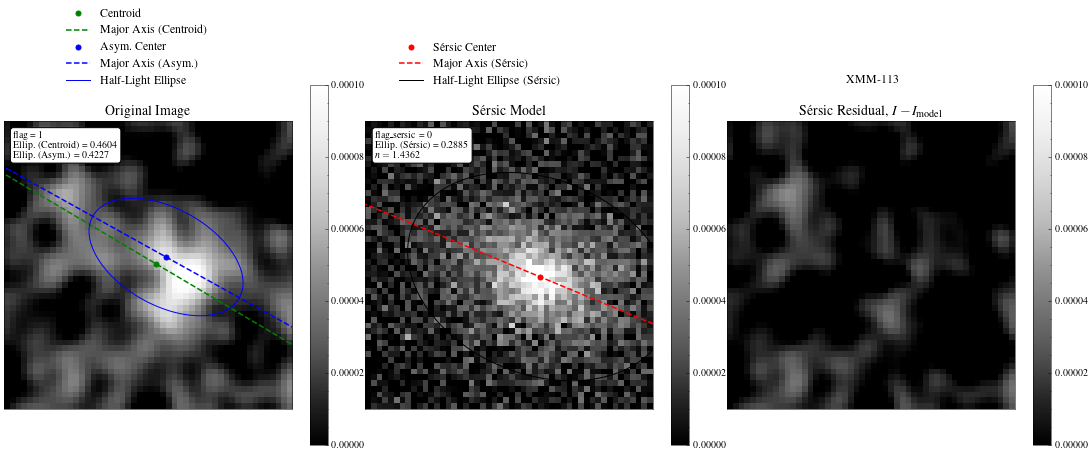

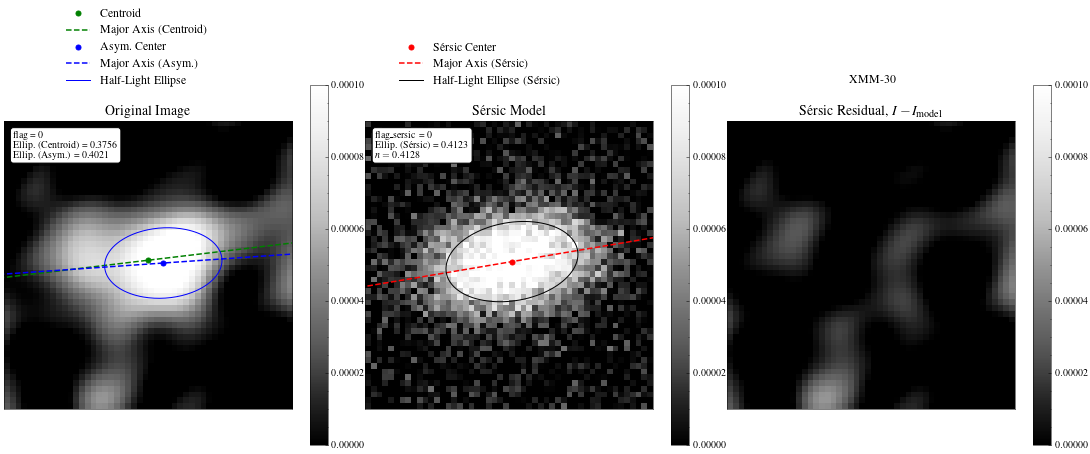

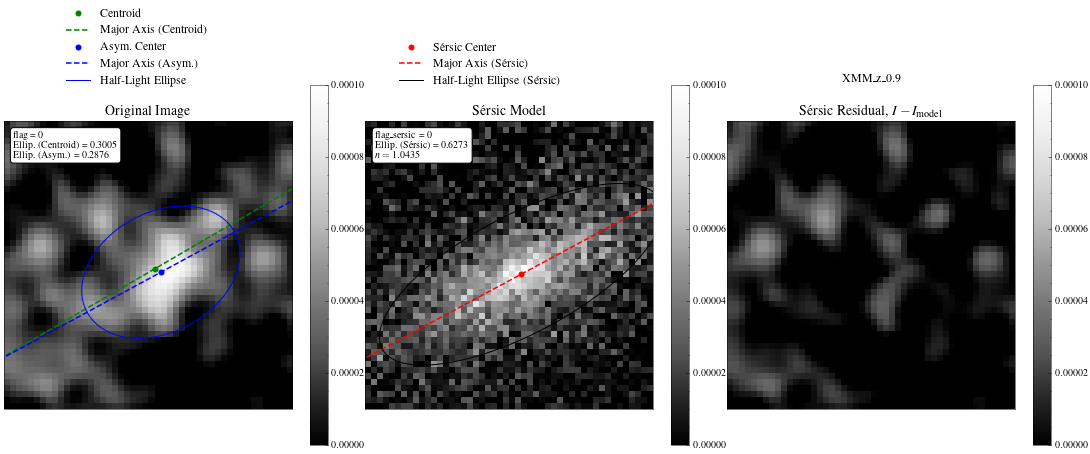

In [17]:
%matplotlib inline
for bcg in psf_bcgs:
    try:
        morph = compute_sersic(bcg)
        sersic_dict[bcg] = {"n":morph.sersic_n, "re": morph.sersic_rhalf * 0.045}
        fig = make_figure(morph)
        fig.suptitle(bcg, x = 0.8)
        fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/" + bcg + "_sersic_profile.png", dpi = 300)
    except:
        pass

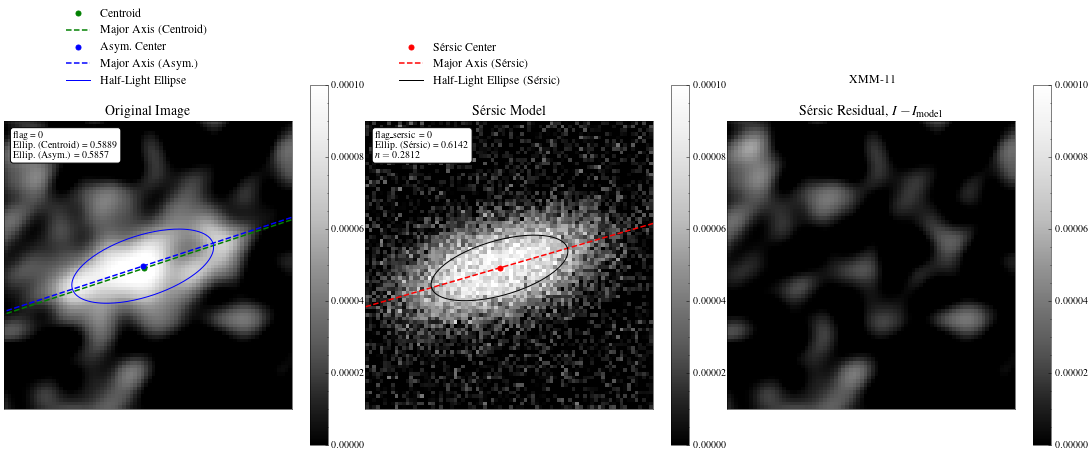

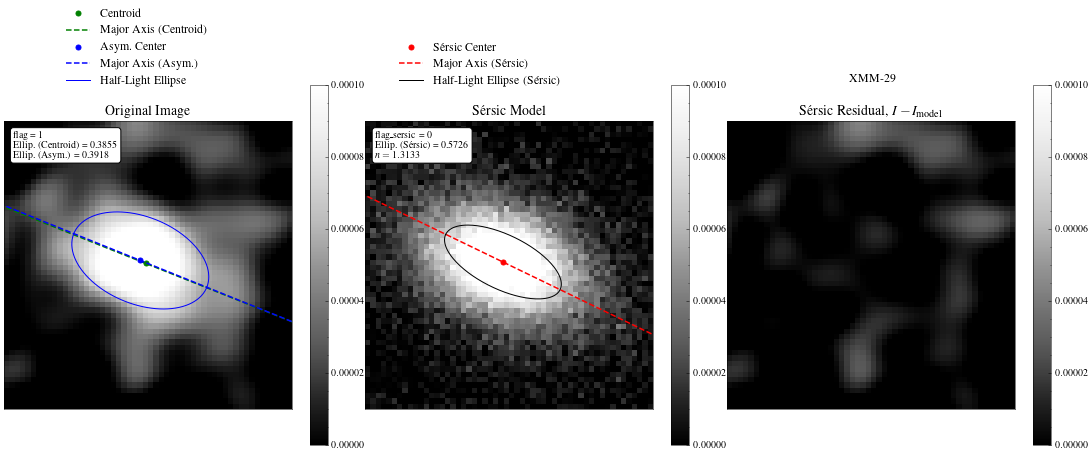

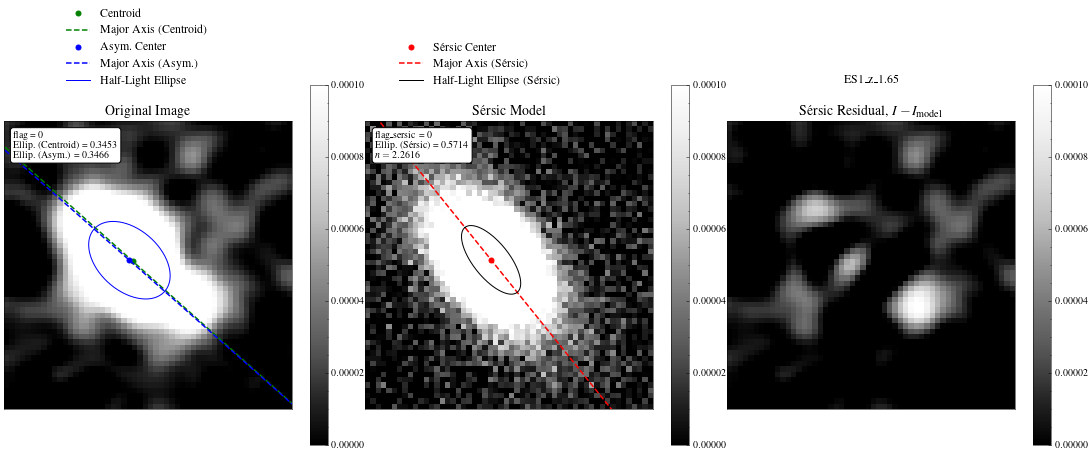

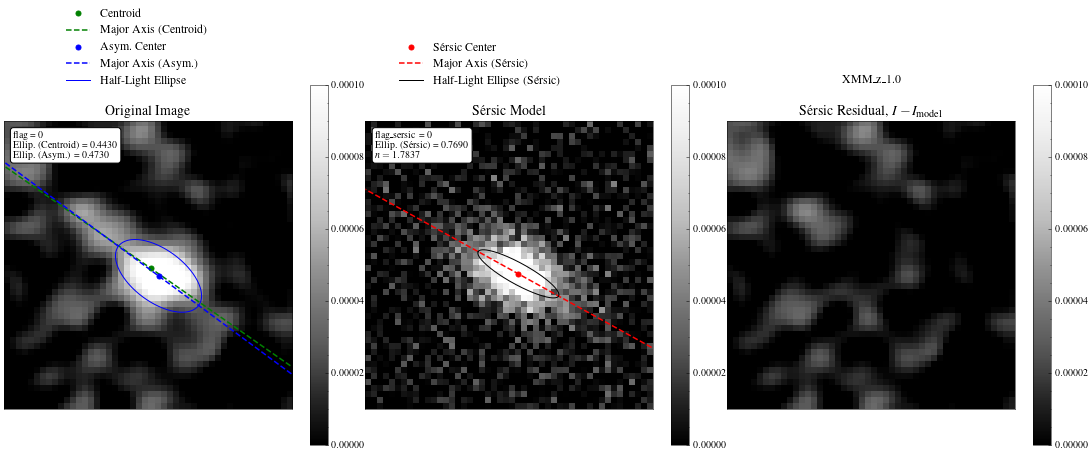

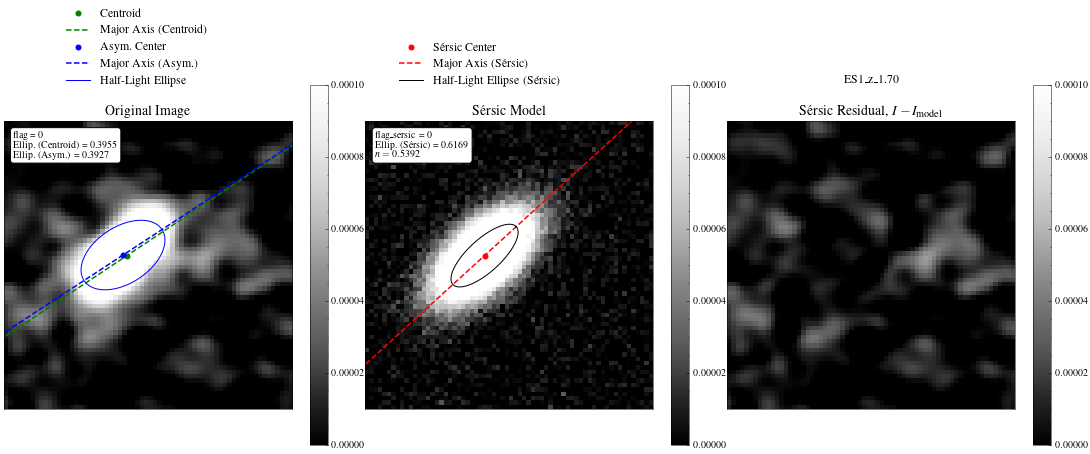

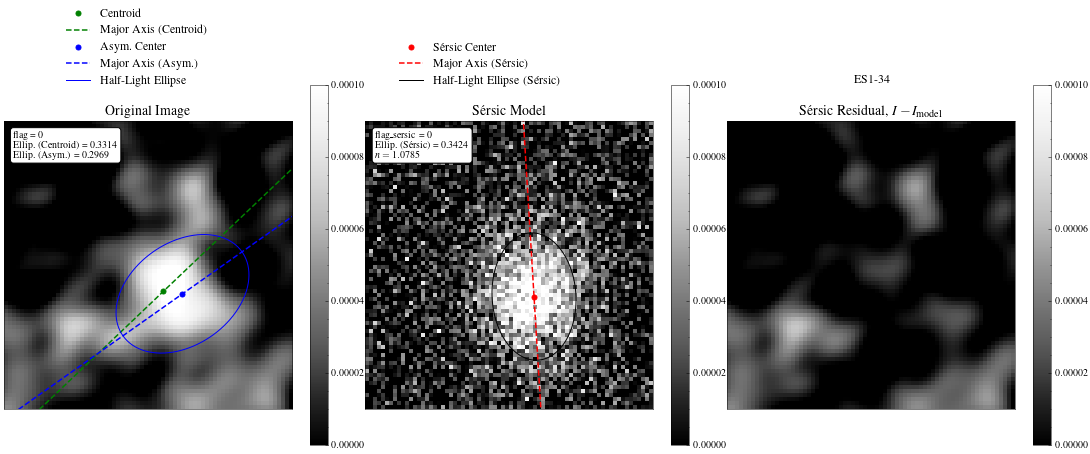

In [18]:
%matplotlib inline
for bcg in well_fit_sersic:
    try:
        morph = compute_sersic_beam(bcg)
        sersic_dict[bcg] = {"n":morph.sersic_n, "re": morph.sersic_rhalf * 0.045}
        fig = make_figure(morph)
        fig.suptitle(bcg, x = 0.8)
        fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/" + bcg + "_sersic_profile.png", dpi = 300)
    except:
        pass

In [442]:
well_fit_sersic = ["XMM-11", "XMM-29", "ES1_z_1.65", "XMM_z_1.0","ES1_z_1.70", "ES1-34"]

In [443]:
bcg_redshift_df = pd.read_excel("/Users/arames52/bcg_dust_continuum/notebook/data/Derived_Data/BCG_redshifts.xlsx")

In [444]:
from astropy.io import fits
import numpy as np
from astropy.table import Table
from decimal import *
import pandas as pd
from math import *
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import ascii
import glob
import os
import matplotlib.pyplot as plt
import matplotlib

all_bcgs = ['CDFS-18',
 'CDFS19',
 'ES1-12',
 'ES1-18',
 'ES1-25',
 'ES1-26',
 'ES1-34',
 'ES1-35',
 'XMM-11',
 'XMM-19',
 'XMM-27',
 'XMM-29',
 'XMM-30',
 'ES1_z_0.88',
 'ES1_z_0.99',
 'ES1_z_0.99b',
 'ES1_z_1.04',
 'ES1_z_1.38',
 'ES1_z_1.40',
 'ES1_z_1.60',
 'ES1_z_1.65',
 'ES1_z_1.70',
 'XMM-113',
 'XMM_z_0.9',
 'XMM_z_1.0',
 'XMM_z_0.81']

df = pd.DataFrame()
redshift_dict = {}
spec_z_dict = {}
for bcg in all_bcgs:
    path = glob.glob("/Users/arames52/Downloads/cigale-v2020.0/pcigale/data/" + bcg + "/out/results.fits")[0]
    data = Table(fits.open(path)[1].data)
    reqd = data[['id','bayes.sfh.sfr', 'bayes.sfh.sfr_err', 'bayes.stellar.m_star', 'bayes.stellar.m_star_err', 'best.reduced_chi_square']].to_pandas()
    reqd = reqd.rename(columns = {'bayes.sfh.sfr':"SFR", 'bayes.sfh.sfr_err':"SFR_err", 'bayes.stellar.m_star':"Stellar_mass", 'bayes.stellar.m_star_err':"Stellar_mass_err", "best.reduced_chi_square": "reduced_chi_square"})
    df = pd.concat([df, reqd]).reset_index(drop=True)
    redshift_dict[bcg] = bcg_redshift_df[bcg_redshift_df['bcg'] == bcg]['redshift'].values[0]
    spec_z_dict[bcg] = bcg_redshift_df[bcg_redshift_df['bcg'] == bcg]['spec_z'].values[0]

df['redshift'] = list(redshift_dict.values())
df['spec_z'] = list(spec_z_dict.values())   
df['sSFR'] = df['SFR']/df['Stellar_mass']
df['sSFR_err'] = (df['SFR']/df['Stellar_mass'])*np.sqrt((df['SFR_err']/df['SFR'])**2 + (df['Stellar_mass_err']/df['Stellar_mass'])**2)
df['sSFR_gyr'] = np.array(df['sSFR'])*1e9
df['sSFR_err_gyr'] = np.array(df['sSFR_err'])*1e9
df['Age'] = cosmo.age(df['redshift']).value
df['sSFR_MS'] = 26 * np.array(df['Age'])**(-2.2)
df['id'] = df['id'].str.replace('XMM_113','XMM-113')
df['id'] = df['id'].str.replace('CDFS-19','CDFS19')

In [445]:
df

id          SFR     SFR_err  Stellar_mass  Stellar_mass_err  \
0       CDFS-18    23.824306    4.727115  1.538661e+11      1.550262e+10   
1        CDFS19    33.475627    4.083425  1.555707e+11      1.086400e+10   
2        ES1-12    47.812017    6.006869  1.995936e+11      3.011822e+10   
3        ES1-18    38.219397    4.054495  1.639366e+11      1.784595e+10   
4        ES1-25    35.479174   20.181078  1.124215e+11      2.072337e+10   
5        ES1-26    50.997303   12.405896  2.988946e+11      2.188373e+10   
6        ES1-34   269.194180   14.891471  6.072108e+11      7.113255e+10   
7        ES1-35   435.795776   60.301348  2.459066e+11      3.289271e+10   
8        XMM-11   461.356198  215.942380  1.246505e+11      3.739041e+10   
9        XMM-19    78.394902    3.919745  8.740998e+10      4.867738e+09   
10       XMM-27   154.177812   32.596748  2.143111e+11      2.945263e+10   
11       XMM-29   621.233288   37.802112  1.403555e+11      1.232890e+10   
12       XMM-30   381.735158   50.399395  1.121162e+11      1.703403e+10   
13   ES1_z_0.88    16.339344    1.017821  6.758220e+10      9.687966e+09   
14   ES1_z_0.99   152.570824  142.756763  7.522039e+10      9.566821e+09   
15  ES1_z_0.99b    36.365577   11.760642  7.119149e+10      2.409869e+10   
16   ES1_z_1.04   312.219795  148.304865  9.512975e+10      1.959103e+10   
17   ES1_z_1.38   779.855401  185.052349  1.231801e+11      1.131030e+10   
18   ES1_z_1.40   785.503591   97.363627  7.781236e+10      1.121162e+10   
19   ES1_z_1.60   682.670994   48.321684  1.453804e+11      1.047361e+10   
20   ES1_z_1.65  1306.491825   86.606746  2.793319e+11      2.580349e+10   
21   ES1_z_1.70    54.777962    4.758204  1.145421e+11      8.975100e+09   
22      XMM-113   122.218776   89.956725  3.950012e+11      8.475127e+10   
23    XMM_z_0.9    70.836925   19.586493  1.042527e+11      1.300711e+10   
24    XMM_z_1.0    65.761578   22.044591  5.580171e+10      1.894427e+10   
25   XMM_z_0.81   117.641453   55.926071  1.024312e+11      2.219733e+10   

    reduced_chi_square  redshift  spec_z          sSFR      sSFR_err  \
0             9.306043  0.807580       1  1.548379e-10  3.445627e-11   
1             1.182378  0.694840       1  2.151794e-10  3.024499e-11   
2             2.378459  0.747440       1  2.395469e-10  4.703564e-11   
3             1.720605  0.806800       1  2.331352e-10  3.543672e-11   
4             1.620694  1.088070       1  3.155908e-10  1.887038e-10   
5             2.953507  0.851920       1  1.706197e-10  4.334503e-11   
6             3.619022  1.700000       0  4.433290e-10  5.743367e-11   
7             2.413791  1.700000       0  1.772201e-09  3.410666e-10   
8             1.790640  0.790000       0  3.701197e-09  2.057604e-09   
9             5.393139  1.047890       1  8.968644e-10  6.712248e-11   
10            6.010726  1.380000       0  7.194113e-10  1.814094e-10   
11            3.043430  1.450000       0  4.426140e-09  4.729696e-10   
12            1.367169  1.450000       0  3.404818e-09  6.853288e-10   
13            2.009905  0.563950       1  2.417699e-10  3.778875e-11   
14            1.244926  1.193720       1  2.028317e-09  1.915299e-09   
15            1.009473  0.918860       1  5.108135e-10  2.391424e-10   
16            5.153100  1.040000       0  3.282042e-09  1.699191e-09   
17            5.326554  1.380000       0  6.331018e-09  1.610838e-09   
18            5.085912  1.400000       0  1.009484e-08  1.918666e-09   
19            9.750097  1.600000       0  4.695757e-09  4.742585e-10   
20            5.305960  1.650000       0  4.677203e-09  5.317956e-10   
21            2.810916  0.916510       1  4.782344e-10  5.594521e-11   
22            2.354772  1.600000       0  3.094137e-10  2.372169e-10   
23            0.715005  0.849570       1  6.794732e-10  2.061160e-10   
24            6.436920  0.535235       1  1.178487e-09  5.622600e-10   
25            2.232051  0.782721       1  1.148493e-09  6.000373e-10   

     sSFR_gyr  

In [446]:
img_df = pd.read_csv("/Users/arames52/bcg_dust_continuum/notebook/data/Derived_Data/bcg_properties.csv")

In [447]:
master_df = df.merge(img_df[['id', 'S/N']], on='id', how='right')

In [448]:
master_df = results_df.copy()

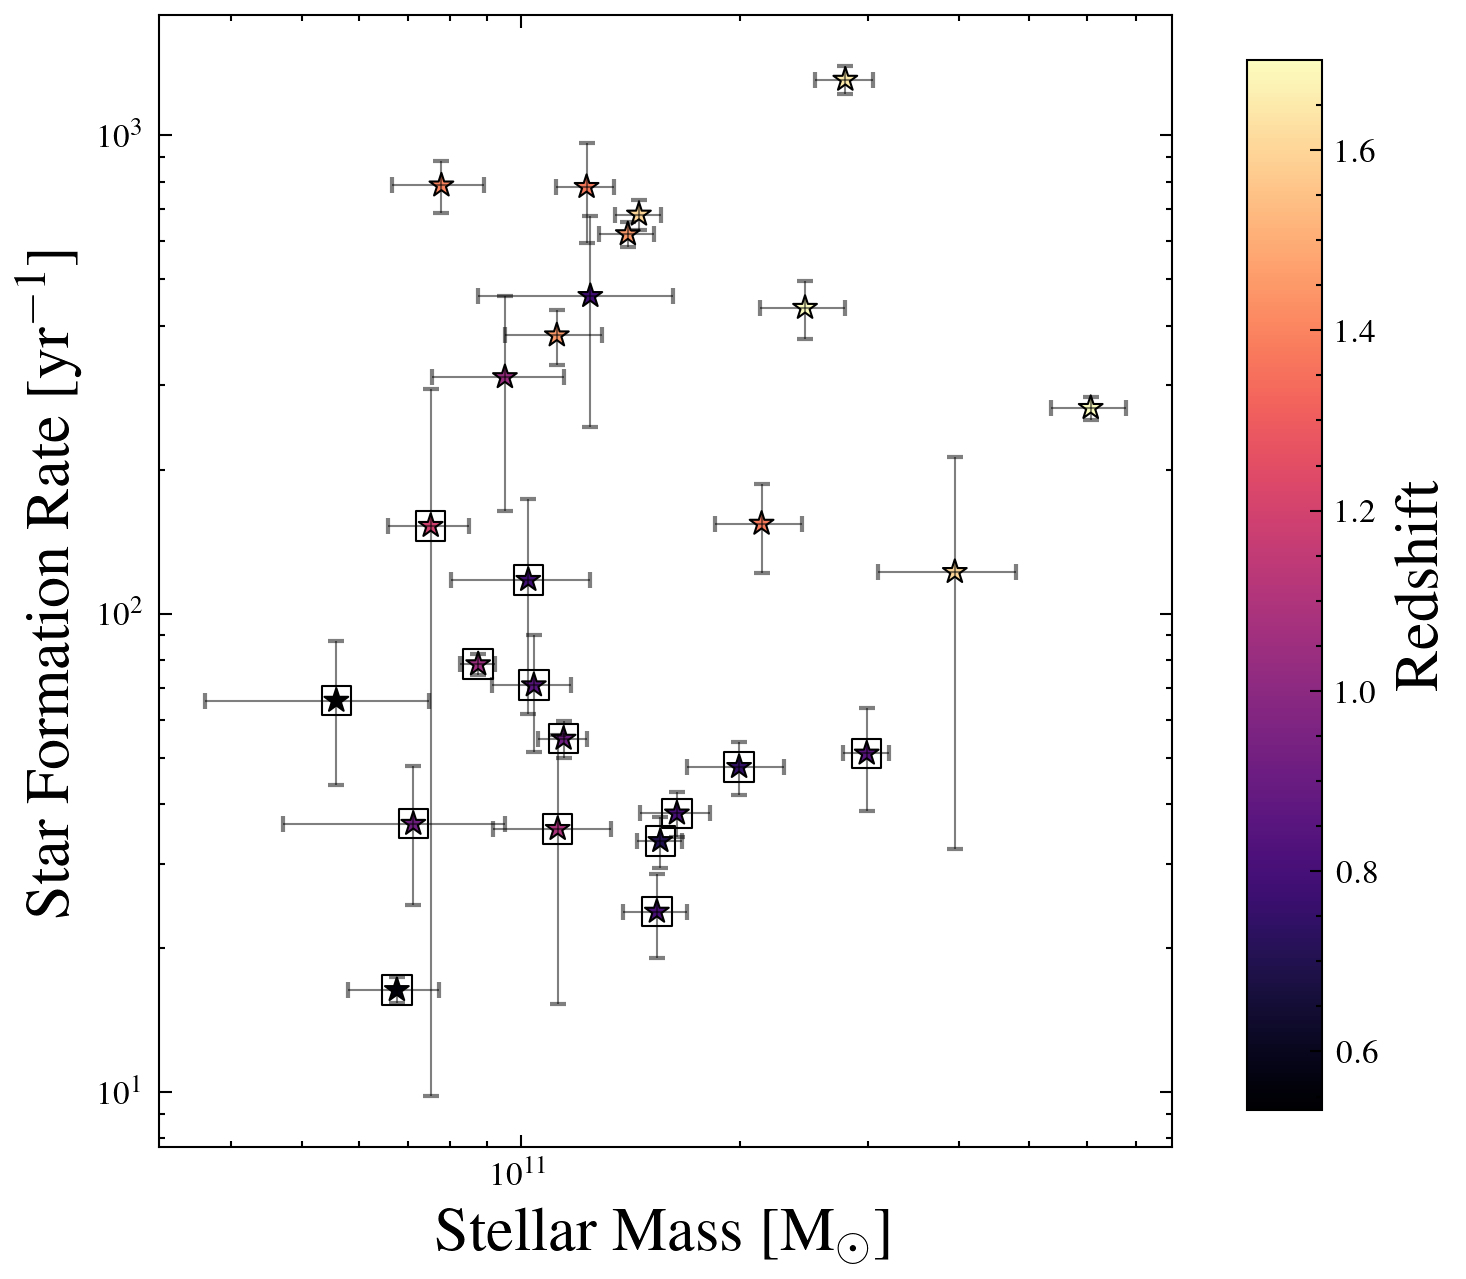

In [178]:
# SFR vs Mstar Plot
%matplotlib inline
vmin = min(master_df['redshift'])
vmax = max(master_df['redshift'])
plt.style.use(["ieee","science"])
fig, ax = plt.subplots(1,1,dpi = 300, figsize = (5,5))
im = ax.scatter(master_df['Stellar_mass'], master_df['SFR'], marker = '*',facecolors='none', c = master_df['redshift'], ec = 'black', lw = 0.5, vmin = vmin, vmax = vmax, cmap = 'magma')
ax.errorbar(master_df['Stellar_mass'], master_df['SFR'], xerr=master_df['Stellar_mass_err'],
yerr=master_df['SFR_err'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=2, elinewidth = 0.5)
specz = master_df[master_df['spec_z'] == 1]
ax.scatter(specz['Stellar_mass'], specz['SFR'], marker = 's', color = 'black', facecolors= 'none', lw = 0.5, s = 50, label = 'Spec_z')
ax.set_xlabel("Stellar Mass [M$_\odot$]", size = 15)
ax.set_ylabel("Star Formation Rate [yr$^{-1}$]", size = 15)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xticks(fontsize = 10)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel("Redshift", size = 15)
fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/sfr_mstar.png", dpi = 300)

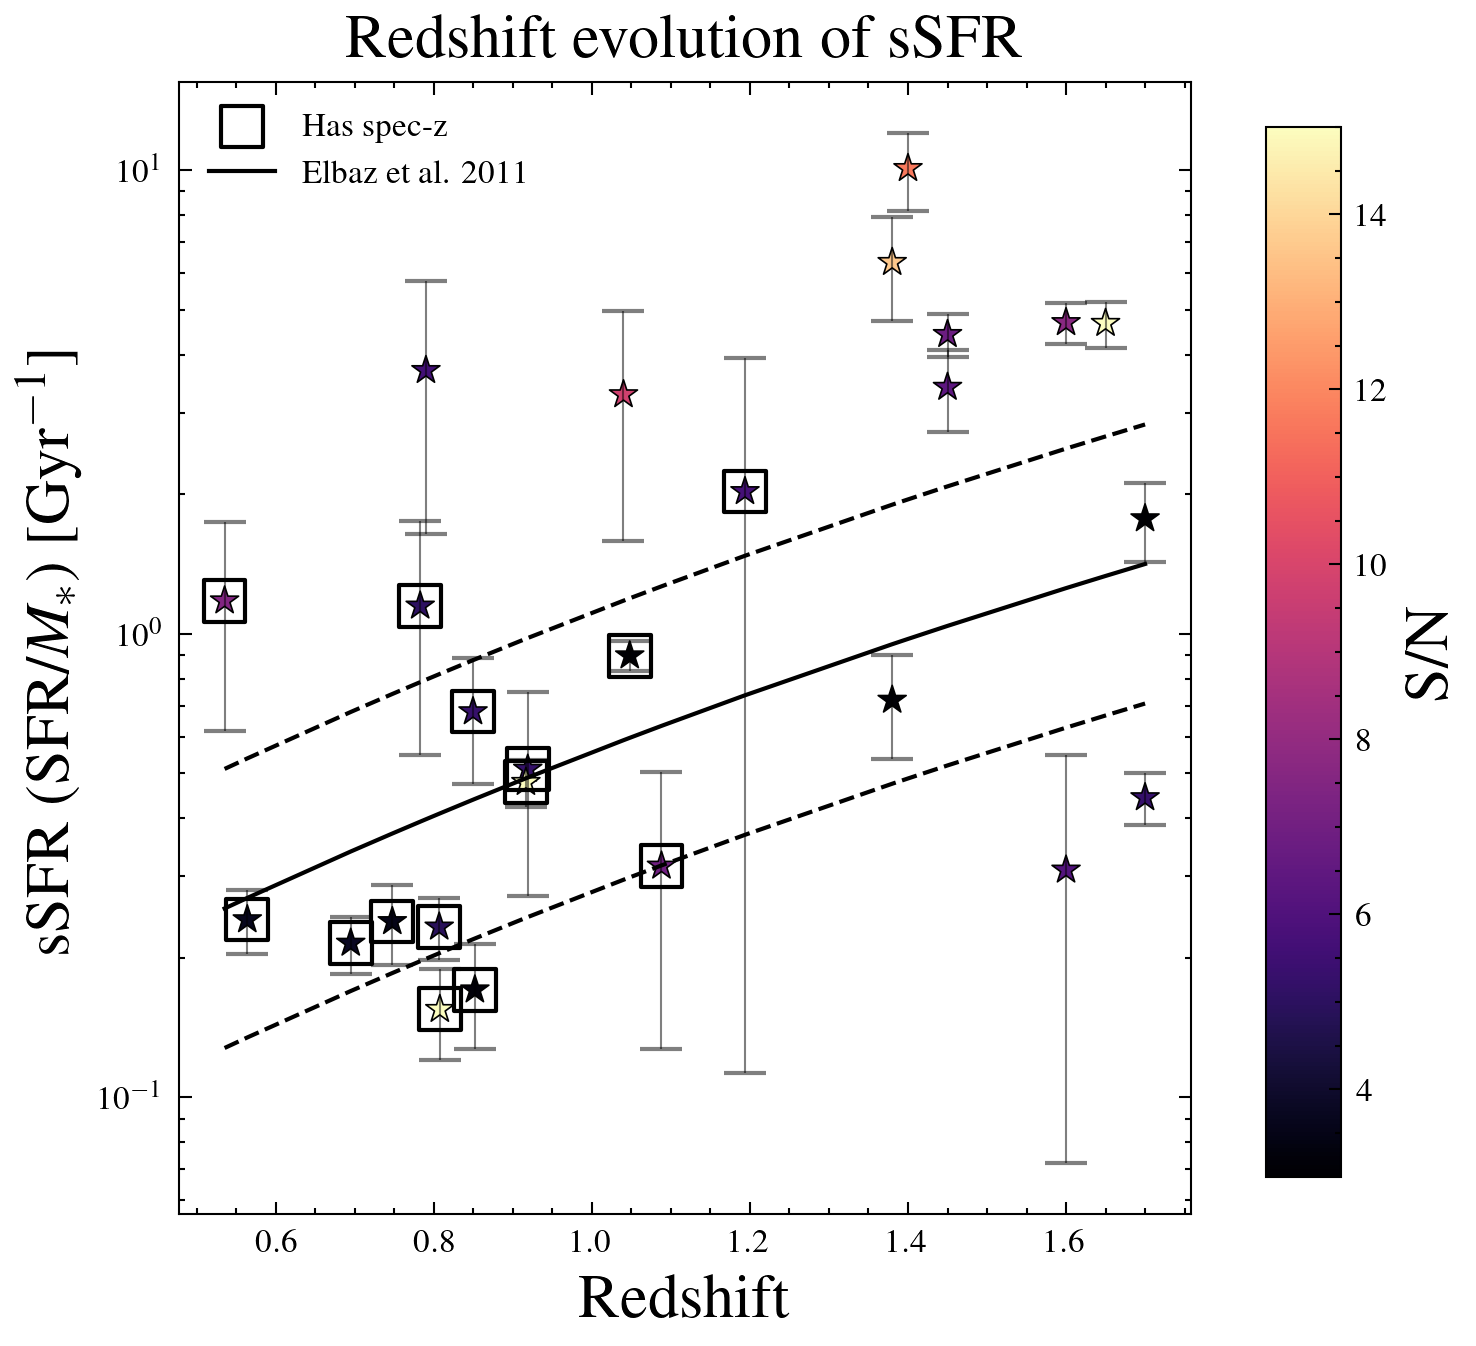

In [179]:
plt.style.use(["ieee","science"])
fig,ax = plt.subplots(1,1, dpi = 300, figsize = (5,5))
vmin = 3
vmax = 15
im=ax.scatter(master_df['redshift'], master_df['sSFR_gyr'], c = master_df['S/N'],  marker = '*', s = 50, vmin = vmin, vmax = vmax, cmap = 'magma', edgecolors='black', lw = 0.4)
ax.errorbar(master_df['redshift'], master_df['sSFR_gyr'], yerr = master_df['sSFR_err_gyr'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 0.5)
ax.set_yscale('log')

# ax[0].scatter(nr_data['redshift'], nr_data['sSFR_gyr'], marker = 'o', facecolors = 'none', color = 'green', linewidth = 1, s = 200)
ax.scatter(specz['redshift'], specz['sSFR_gyr'], marker = 's', color = 'black', linewidth = 1, label = 'Has spec-z', facecolors = 'none', s = 100)
# ax.scatter(sb_specz['redshift'], sb_specz['sSFR_gyr'], marker = '*', color = 'purple', linewidth = 1)
ax.set_ylabel("sSFR (SFR/$M_*$) [Gyr$^{-1}$]", size = 15)
ax.set_xlabel("Redshift", size = 15)
ax.plot(sorted(master_df['redshift']),sorted(master_df['sSFR_MS']), color = 'black', linewidth = 1, label = 'Elbaz et al. 2011')
ax.plot(sorted(master_df['redshift']),sorted(master_df['sSFR_MS']*2), color = 'black', ls = "--", linewidth = 1)
ax.plot(sorted(master_df['redshift']),sorted(master_df['sSFR_MS']/2), color = 'black', ls = "--", linewidth = 1)
ax.set_title("Redshift evolution of sSFR", size = 15)
ax.legend()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel("S/N", size = 15)
fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/ssfr_z.png", dpi = 300)

In [180]:
master_df.columns

Index(['id', 'SFR', 'SFR_err', 'Stellar_mass', 'Stellar_mass_err',
       'reduced_chi_square', 'redshift', 'spec_z', 'sSFR', 'sSFR_err',
       'sSFR_gyr', 'sSFR_err_gyr', 'Age', 'sSFR_MS', 'S/N', 'n', 're_arcsec',
       're_kpc_sersic', 're_kpc_gaussian', 're_kpc_gaussian_err'],
      dtype='object')

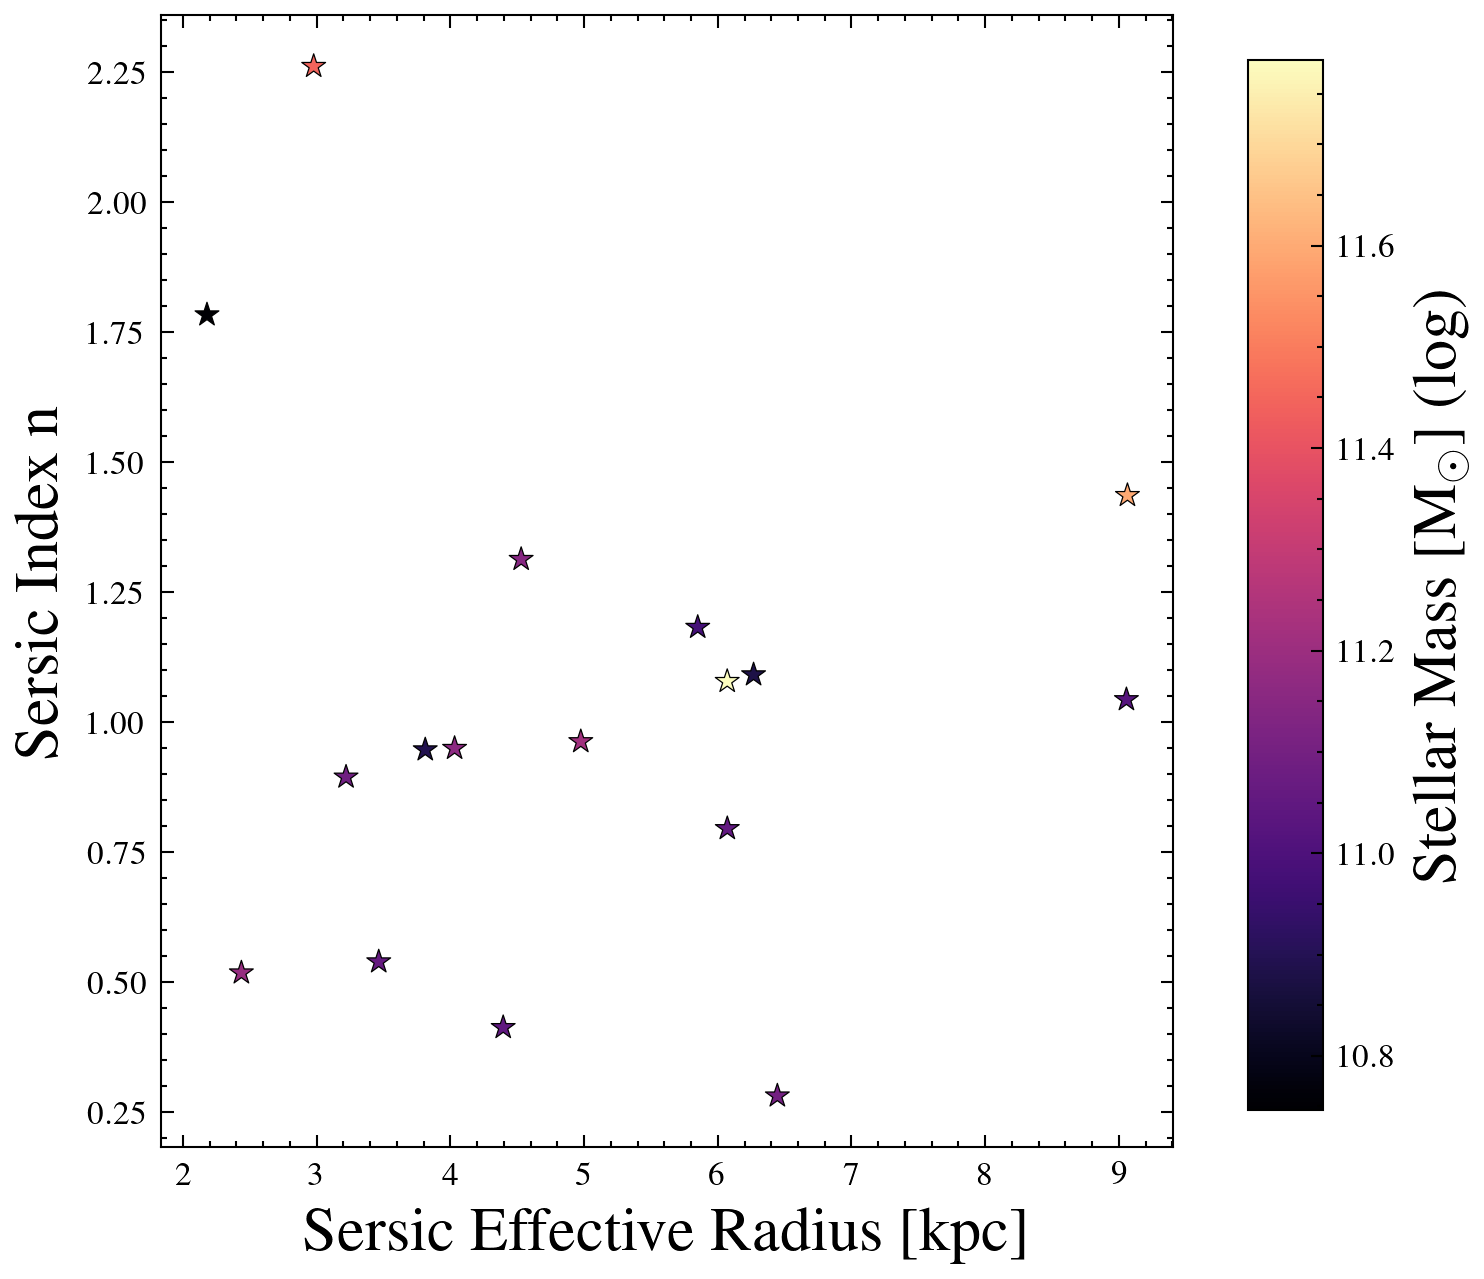

In [220]:
%matplotlib inline
vmin = np.min(np.log10(master_df['Stellar_mass']))
vmax = np.max(np.log10(master_df['Stellar_mass']))
plt.style.use(["ieee","science"])
fig, ax = plt.subplots(1,1,dpi = 300, figsize = (5,5))
im = ax.scatter(master_df['re_kpc_sersic'], master_df['n'], marker = '*',facecolors='none', edgecolors = 'black', lw = 0.3, c = np.log10(master_df['Stellar_mass']), vmin = vmin, vmax = vmax, cmap = 'magma')
ax.set_xlabel("Sersic Effective Radius [kpc]", size = 15)
ax.set_ylabel("Sersic Index n", size = 15)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel("Stellar Mass [M$_\odot$] (log)", size = 15)
fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/n_re.png", dpi = 300)

# Hodge SMGs

In [183]:
from uncertainties import ufloat
from uncertainties.umath import *
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
smg_sm = pd.read_csv("/Users/arames52/Research/Data/aless_smgs.txt", names = ["id", "MH", "z"], delim_whitespace=True)
def mh_to_mstar(mh):
    log_mstar = (ufloat(-0.393, 0.002) * mh) + ufloat(1.22, 0.04)
    return log_mstar
smg_morph = pd.read_csv("/Users/arames52/Research/Data/hodge_smg.txt", names=["id", "Re", "n"], 
                       delim_whitespace=True)
mh_arr = list(smg_sm['MH'])
hodge_smg = smg_sm.merge(smg_morph)
hodge_smg['mstar'] = mh_to_mstar(hodge_smg['MH'])
stellar_mass = []
stellar_mass_err = []
for ind, row in hodge_smg.iterrows():
    stellar_mass.append(row['mstar'].n)
    stellar_mass_err.append(row['mstar'].std_dev)
hodge_smg['stellar_mass'] = stellar_mass
hodge_smg['stellar_mass_err'] = stellar_mass_err
hodge_smg['Re_kpc'] = (cosmo.kpc_proper_per_arcmin(np.array(hodge_smg['z']))*(np.array(hodge_smg['Re']))/60).value
hodge_smg['rest_wave'] = 0.87/(1 + hodge_smg['z'])
hodge_smg['median_SFR'] = 500

In [184]:
etg = pd.read_csv("/Users/arames52/Research/Data/mnras0382-0109-SD1.csv")
# etg = etg[etg['z'].between(0.7,1.7)]
etg['re'] = etg['ae']*np.sqrt(1-etg['epsilon'])
etg['re_kpc'] = (cosmo.kpc_proper_per_arcmin(np.array(etg['z']))*(np.array(etg['re']))/60).value
etg['stellar_mass_log'] = np.log10(np.array(etg['stellar_mass'])*10**10)
etg['rest_wave'] = 0.00081/(1+etg['z'])
hst_bcgs = pd.read_csv("/Users/arames52/Downloads/table2.dat.txt", delim_whitespace=True, names = ["name", "class", "model", "mag", 
                                                                                                  "mean_sb", "re", "n", "b/a", "pa", 
                                                                                                   "align"])
hst_bcgs_tab1 = pd.read_csv("/Users/arames52/Downloads/table1.dat.txt", delim_whitespace=True, names = ["name", "ra",
                                                    "dec", "z", "class", "inst", "filter", "scale", "color"])
hst_bcgs_mass = pd.read_csv("/Users/arames52/Research/Data/hst_bcgs_mass.dat.txt", delim_whitespace = True, names = ["name", "ra", "dec", "r_pos",
                                                                                                                    "M200", "E_M200", "e_M200", "Method", "r-M200",
                                                                                                                    "PAcl", "e_PAcl","r"])
hst_bcgs_mass = hst_bcgs_mass[["name", "M200", "e_M200"]]
hst_bcgs = hst_bcgs.merge(hst_bcgs_tab1, on = "name")
hst_bcgs = hst_bcgs.merge(hst_bcgs_mass, on = "name")
hst_bcgs = hst_bcgs[hst_bcgs['model'] == "Sersic"]
# hst_bcgs = hst_bcgs[hst_bcgs['z'].between(0.7,1.7, inclusive = "both")]
# np.unique(hst_bcgs['filter'])
# hst_filters = {"F105W" : 1055.2, "F125W" : 1248.6, "F140W" : 1392.3, "F160W": 1536.9, "F814W": 8115.3, "F850LP":9145.2}
# hst_bcgs['rest_wave'] = 0
# for ind, row in hst_bcgs.iterrows():
#     hst_bcgs.loc[ind, 'rest_wave'] = hst_filters[row['filter']]*1e-6 / (1+ row['z'])

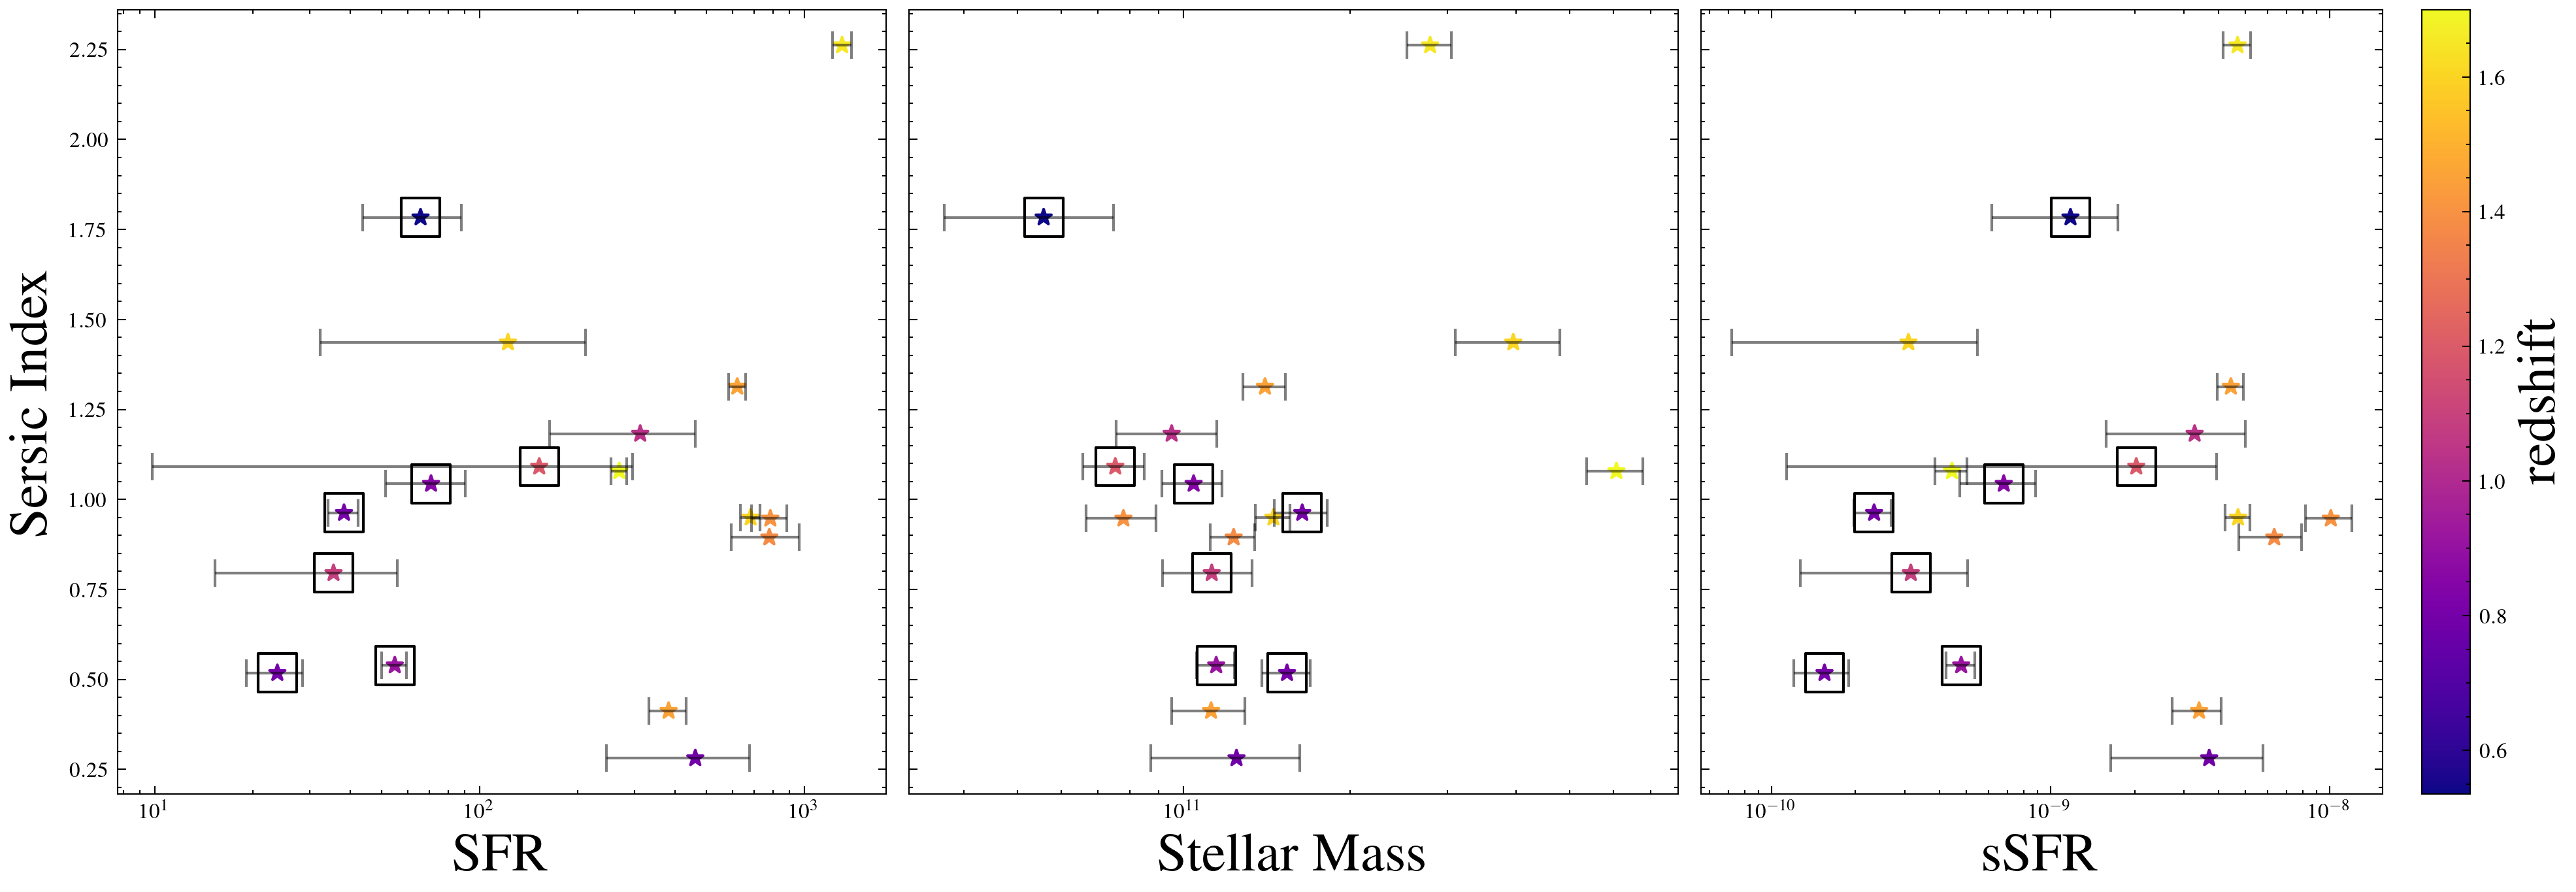

In [185]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use(["ieee","science"])
fig,ax = plt.subplots(1,3, figsize = (15,5), sharey = True, dpi = 300)
vmin, vmax = min(master_df['redshift']), max(master_df['redshift'])
ax[0].scatter(master_df['SFR'], master_df['n'], c = master_df['redshift'], vmin = vmin, vmax = vmax, cmap = "plasma", marker = "*")
ax[0].scatter(specz['SFR'], specz['n'], marker = 's', s = 200, color = 'black', facecolors = 'none', label = '$z_{spec}$')
ax[0].errorbar(master_df['SFR'], master_df['n'], xerr = master_df['SFR_err'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax[0].set_xscale("log")
ax[0].set_ylabel("Sersic Index", size = 20)
ax[0].set_xlabel("SFR",size = 20)
# ax[0].legend()

ax[1].scatter(master_df['Stellar_mass'], master_df['n'], c = master_df['redshift'], vmin = vmin, vmax = vmax, cmap = "plasma", marker = "*")
ax[1].errorbar(master_df['Stellar_mass'], master_df['n'], xerr = master_df['Stellar_mass_err'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax[1].scatter(specz['Stellar_mass'], specz['n'], marker = 's', s = 200, color = 'black', facecolors = 'none', label = '$z_{spec}$')
ax[1].set_xscale("log")
ax[1].set_xlabel("Stellar Mass", size = 20)
# ax[1].legend()

im = ax[2].scatter(master_df['sSFR'], master_df['n'], c = master_df['redshift'], vmin = vmin, vmax = vmax, cmap = "plasma", marker = "*")
ax[2].errorbar(master_df['sSFR'], master_df['n'], xerr = master_df['sSFR_err'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax[2].scatter(specz['sSFR'], specz['n'], marker = 's', s = 200, color = 'black', facecolors = 'none')
ax[2].set_xscale("log")
ax[2].set_xlabel("sSFR",size = 20)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size="7%", pad=0.2)
cbar = fig.colorbar(im, cax=cax);
cbar.ax.set_ylabel('redshift',size = 20)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.03,
                    hspace=0.05)

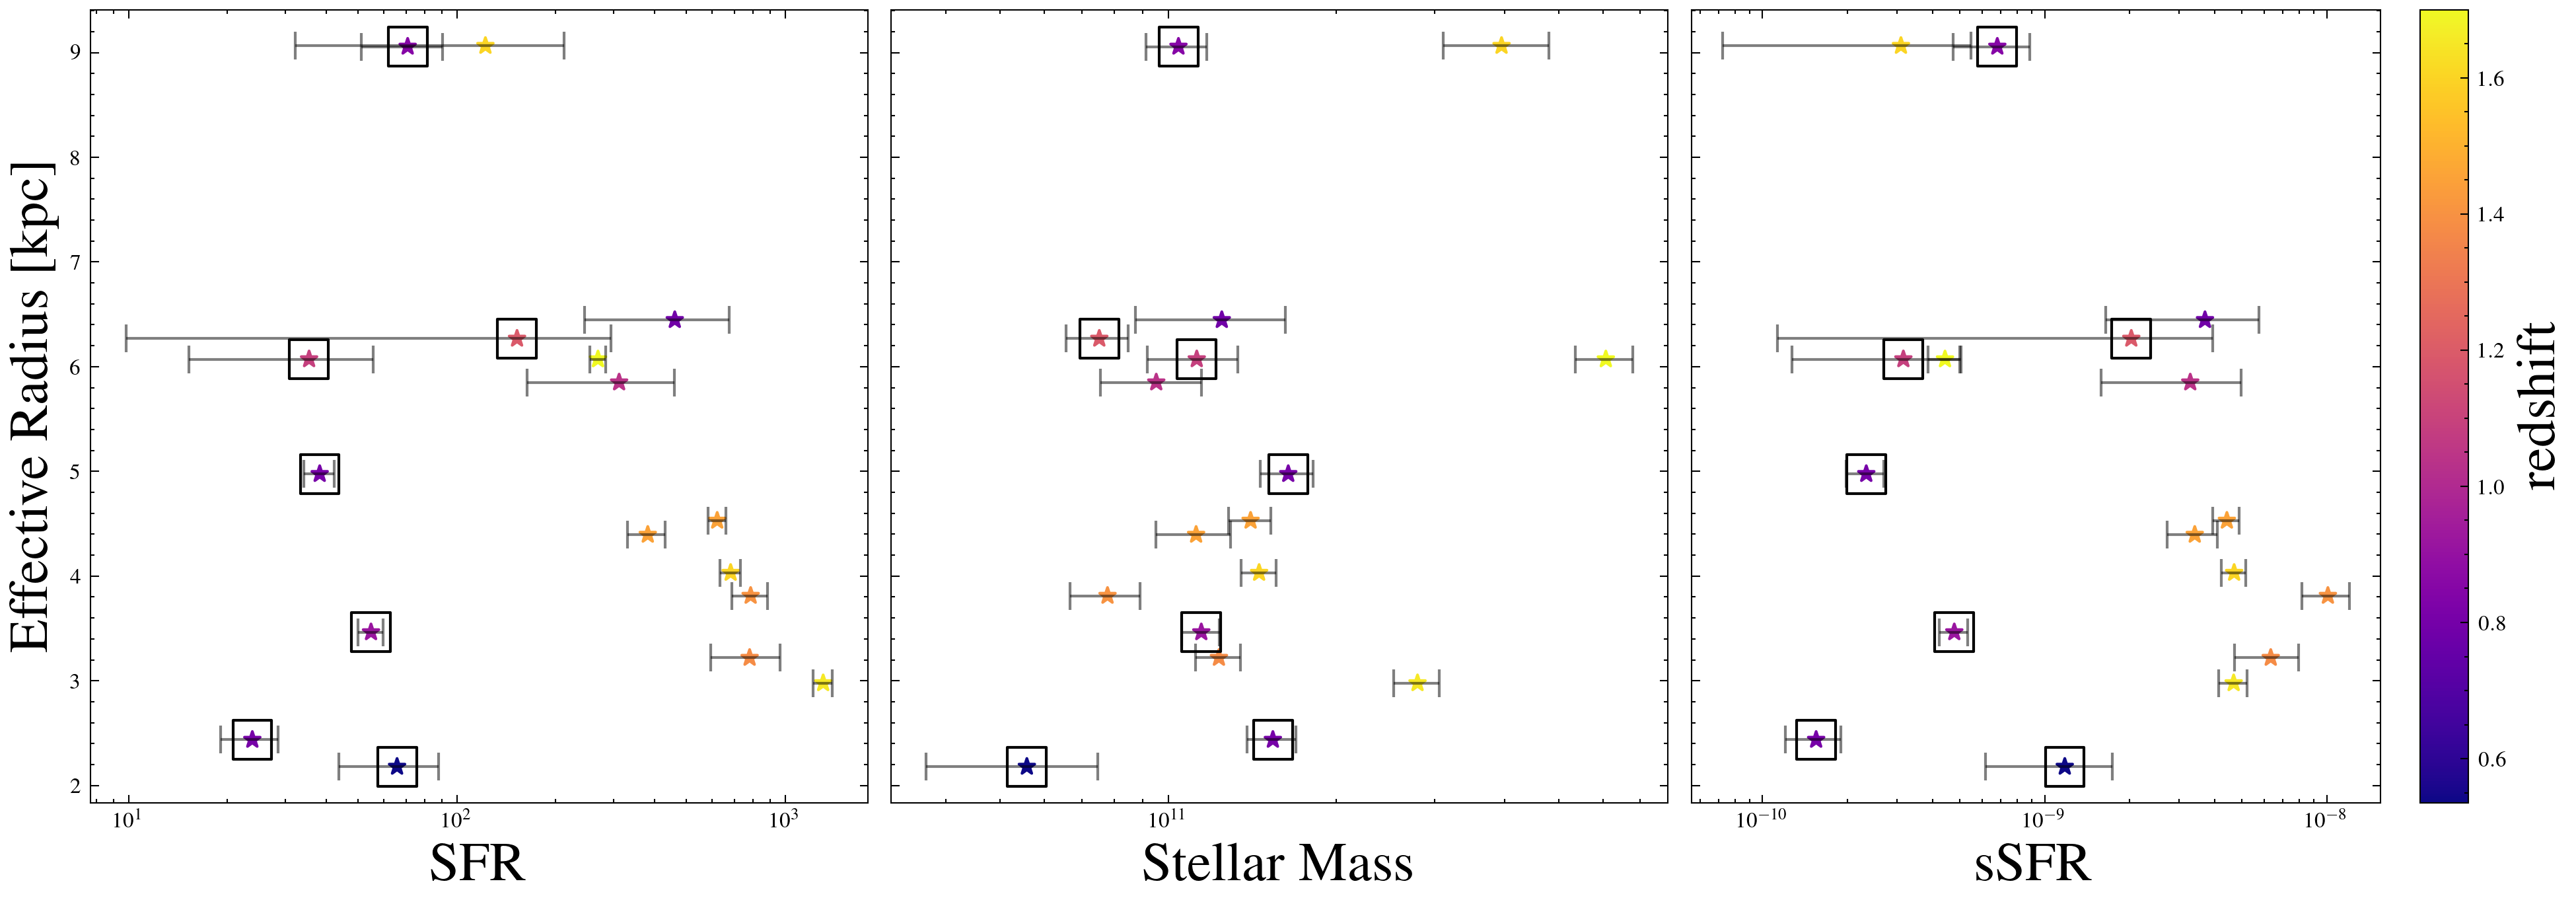

In [186]:
plt.style.use(["ieee","science"])
fig,ax = plt.subplots(1,3, figsize = (15,5), sharey = True, dpi = 300)
vmin, vmax = min(master_df['redshift']), max(master_df['redshift'])
ax[0].scatter(master_df['SFR'], master_df['re_kpc_sersic'], c = master_df['redshift'], vmin = vmin, vmax = vmax, cmap = "plasma", marker = "*")
ax[0].scatter(specz['SFR'], specz['re_kpc_sersic'], marker = 's', s = 200, color = 'black', facecolors = 'none', label = '$z_{spec}$')
ax[0].errorbar(master_df['SFR'], master_df['re_kpc_sersic'], xerr = master_df['SFR_err'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax[0].set_xscale("log")
ax[0].set_ylabel("Effective Radius [kpc]", size = 20)
ax[0].set_xlabel("SFR",size = 20)
# ax[0].legend()

ax[1].scatter(master_df['Stellar_mass'], master_df['re_kpc_sersic'], c = master_df['redshift'], vmin = vmin, vmax = vmax, cmap = "plasma", marker = "*")
ax[1].errorbar(master_df['Stellar_mass'], master_df['re_kpc_sersic'], xerr = master_df['Stellar_mass_err'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax[1].scatter(specz['Stellar_mass'], specz['re_kpc_sersic'], marker = 's', s = 200, color = 'black', facecolors = 'none', label = '$z_{spec}$')
ax[1].set_xscale("log")
ax[1].set_xlabel("Stellar Mass", size = 20)
# ax[1].legend()

im = ax[2].scatter(master_df['sSFR'], master_df['re_kpc_sersic'], c = master_df['redshift'], vmin = vmin, vmax = vmax, cmap = "plasma", marker = "*")
ax[2].errorbar(master_df['sSFR'], master_df['re_kpc_sersic'], xerr = master_df['sSFR_err'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax[2].scatter(specz['sSFR'], specz['re_kpc_sersic'], marker = 's', s = 200, color = 'black', facecolors = 'none')
ax[2].set_xscale("log")
ax[2].set_xlabel("sSFR",size = 20)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size="7%", pad=0.2)
cbar = fig.colorbar(im, cax=cax);
cbar.ax.set_ylabel('redshift',size = 20)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.03,
                    hspace=0.05)

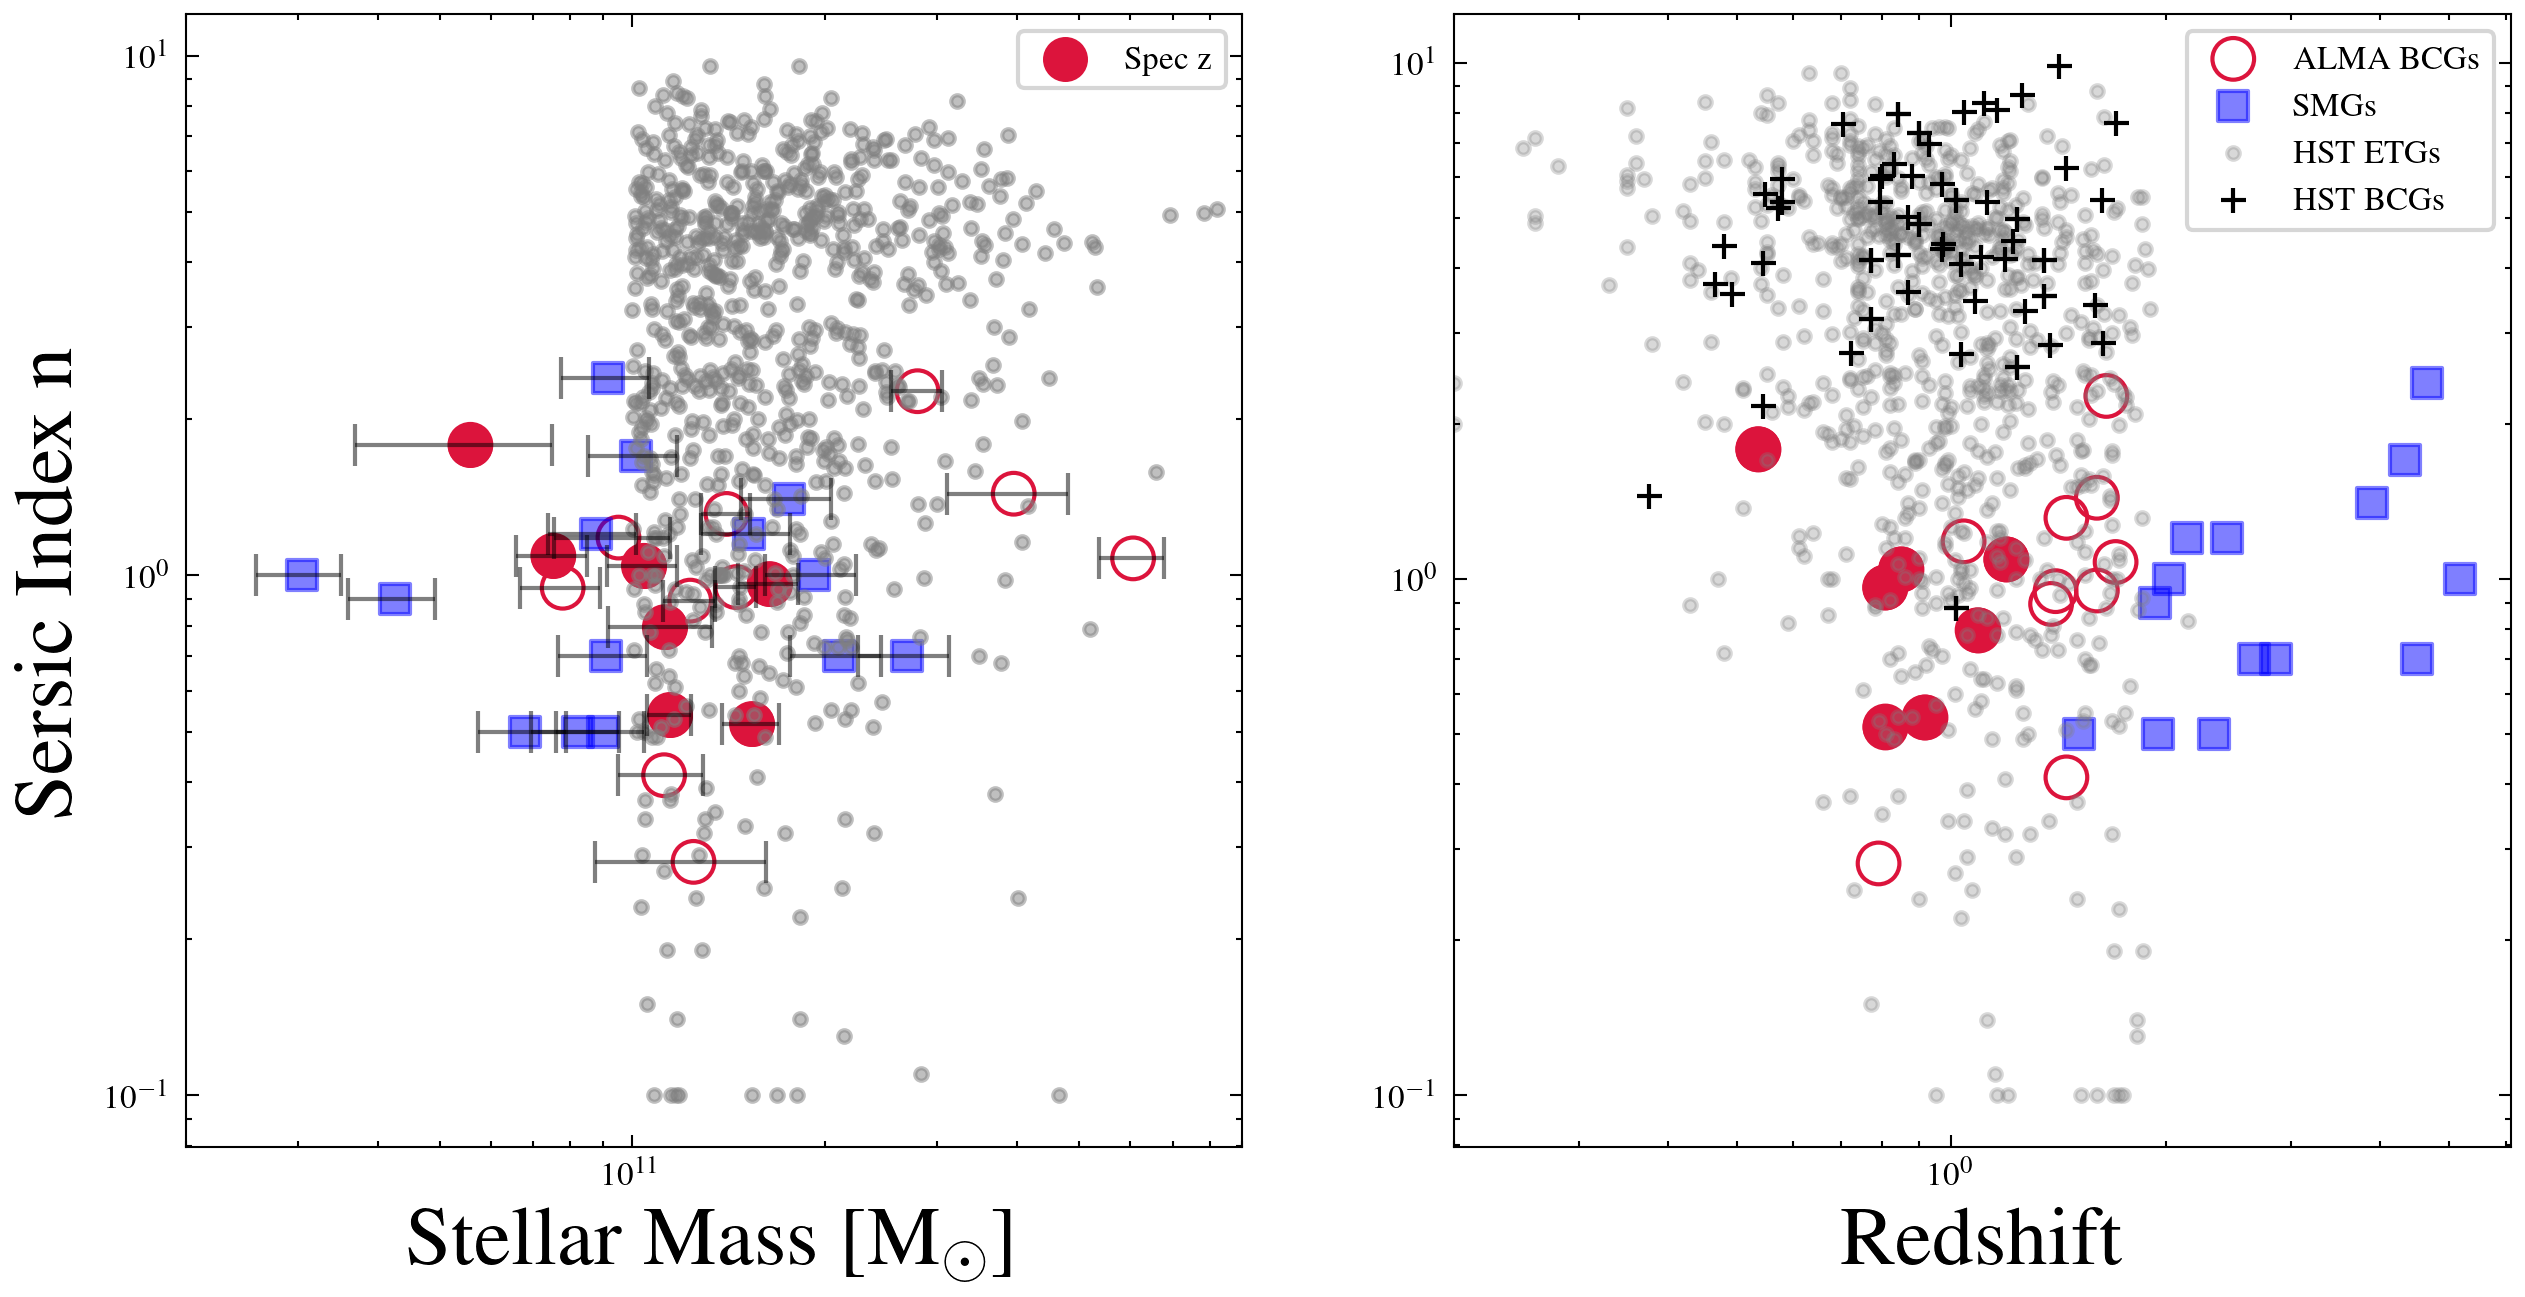

In [219]:
final_results = master_df.copy()
plt.style.use(["ieee","science"])
fig,ax = plt.subplots(1,2, dpi = 300, figsize = (10,5))
ax[0].scatter(final_results['Stellar_mass'], final_results['n'], marker = 'o', s = 100, color = 'crimson', facecolors = 'none')
ax[0].errorbar(final_results['Stellar_mass'], final_results['n'], xerr = final_results['Stellar_mass_err'],ls = 'none', ecolor = 'black', alpha = 0.5, solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax[0].scatter(specz['Stellar_mass'], specz['n'], marker = 'o', s = 100, color = 'crimson', lw = 0.8, label = 'Spec z')
ax[0].scatter(10**hodge_smg['stellar_mass'], hodge_smg['n'], marker = 's',s = 50, color = 'blue', alpha = 0.5)
ax[0].errorbar(10**hodge_smg['stellar_mass'], hodge_smg['n'], xerr = (10**(hodge_smg['stellar_mass'] + hodge_smg['stellar_mass_err']) - 10**(hodge_smg['stellar_mass'])),ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax[0].scatter(etg['stellar_mass'] * 10**10, etg['n'], color = 'grey', marker = '.', alpha = 0.5)
ax[0].set_ylabel("Sersic Index n", size = 20)
ax[0].set_xlabel("Stellar Mass [M$_\odot$]", size = 20)
ax[0].set_xscale('log')
ax[0].legend(scatterpoints=1, frameon = True)
ax[0].set_yscale('log')
# ax[0].set_ylim(10**-1)
ax[0].set_xlim(2*10**10, 9*10**11)

ax[1].scatter(final_results['redshift'], final_results['n'], marker = 'o', s = 100, color = 'crimson', facecolors = 'none', label = "ALMA BCGs")
ax[1].scatter(specz['redshift'], specz['n'], marker = 'o', s = 100, color = 'crimson')
ax[1].scatter(hodge_smg['z'], hodge_smg['n'], marker = 's',s = 50, color = 'blue', label = "SMGs", alpha = 0.5)
ax[1].scatter(etg['z'], etg['n'], color = 'grey', marker = '.', alpha = 0.3, label = "HST ETGs")
ax[1].scatter(hst_bcgs['z'], hst_bcgs['n'],  color = 'black', marker = '+', label = 'HST BCGs')
# ax[1].set_ylabel("Effective Radius [kpc]")
ax[1].set_xlabel("Redshift", size = 20)
ax[1].legend(scatterpoints=1, frameon = True)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlim(2*10**-1)

fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/n_mstar_z.png", dpi = 300)

# plt.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/sn_mass_plot.jpg", dpi = 300,bbox_inches = "tight")

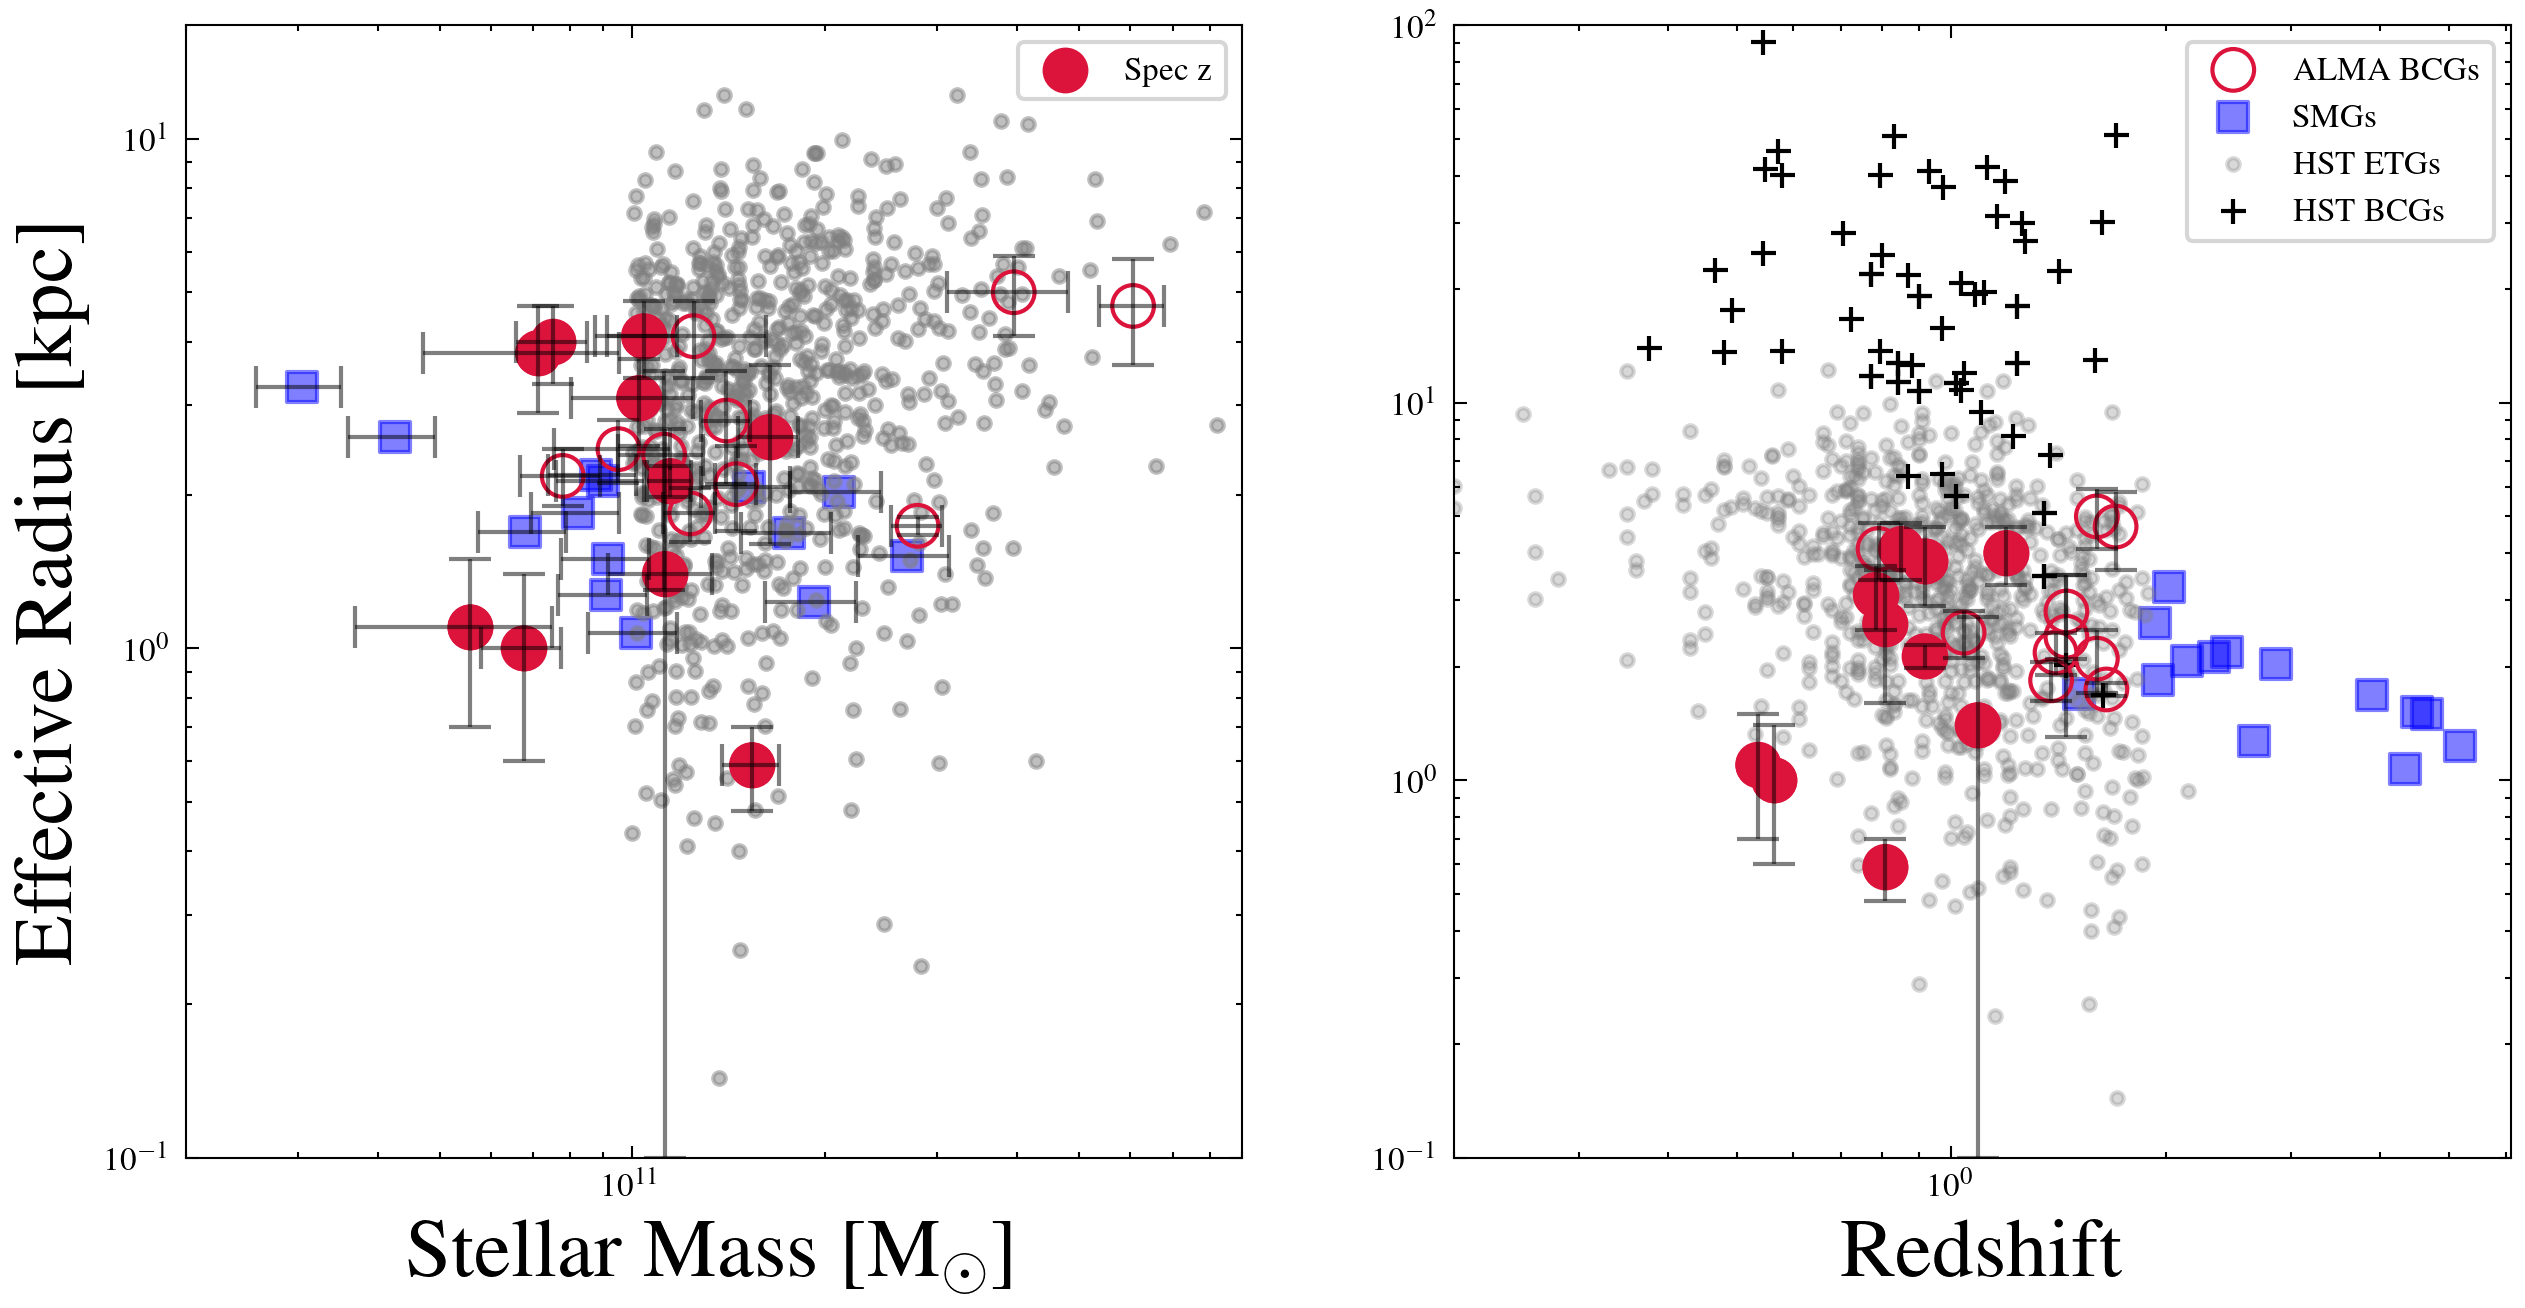

In [217]:
fig,ax = plt.subplots(1,2, figsize = (10,5), dpi = 300)
ax[0].scatter(final_results['Stellar_mass'], final_results['re_kpc_gaussian'], marker = 'o', s = 100, color = 'crimson', facecolors = 'none', zorder = 2)
ax[0].scatter(specz['Stellar_mass'], specz['re_kpc_gaussian'], marker = 'o', s = 100, color = 'crimson', label = "Spec z", zorder = 2)
ax[0].errorbar(final_results['Stellar_mass'], final_results['re_kpc_gaussian'], xerr = final_results['Stellar_mass_err'], yerr = final_results['re_kpc_gaussian_err'], ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1, zorder = 2)
ax[0].scatter(10**hodge_smg['stellar_mass'], hodge_smg['Re_kpc'], marker = 's',s = 50, color = 'blue', alpha = 0.5)
ax[0].errorbar(10**hodge_smg['stellar_mass'], hodge_smg['Re_kpc'], xerr = (10**(hodge_smg['stellar_mass'] + hodge_smg['stellar_mass_err']) - 10**(hodge_smg['stellar_mass'])),ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax[0].scatter(etg['stellar_mass'] * 10**10, etg['re_kpc'], color = 'grey', marker = '.', alpha = 0.5)
ax[0].set_ylabel("Effective Radius [kpc]", size = 20)
ax[0].set_xlabel("Stellar Mass [M$_\odot$]", size = 20)
ax[0].set_xscale('log')
ax[0].legend(scatterpoints=1, frameon = True)
ax[0].set_yscale('log')
ax[0].set_ylim(10**-1)
ax[0].set_xlim(2*10**10, 9*10**11)

ax[1].scatter(final_results['redshift'], final_results['re_kpc_gaussian'], marker = 'o', facecolors= 'none', s = 100, color = 'crimson', label = "ALMA BCGs", zorder = 2)
ax[1].scatter(specz['redshift'], specz['re_kpc_gaussian'], marker = 'o', s = 100, color = 'crimson', zorder = 2)
ax[1].errorbar(final_results['redshift'], final_results['re_kpc_gaussian'], yerr = final_results['re_kpc_gaussian_err'], ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1, zorder = 2)
ax[1].scatter(hodge_smg['z'], hodge_smg['Re_kpc'], marker = 's',s = 50, color = 'blue', label = "SMGs", alpha = 0.5)
ax[1].scatter(etg['z'], etg['re_kpc'], color = 'grey', marker = '.', alpha = 0.3, label = "HST ETGs")
ax[1].scatter(hst_bcgs['z'], hst_bcgs['re'],  color = 'black', marker = '+', label = 'HST BCGs')
# ax[1].set_ylabel("Effective Radius [kpc]")
ax[1].set_xlabel("Redshift", size = 20)
ax[1].legend(scatterpoints=1, frameon = True)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_ylim(10**-1, 10**2)
ax[1].set_xlim(2*10**-1)

fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/gaussian_re_mstar_z.png", dpi = 300)

(0.2, 6.095295259760461)

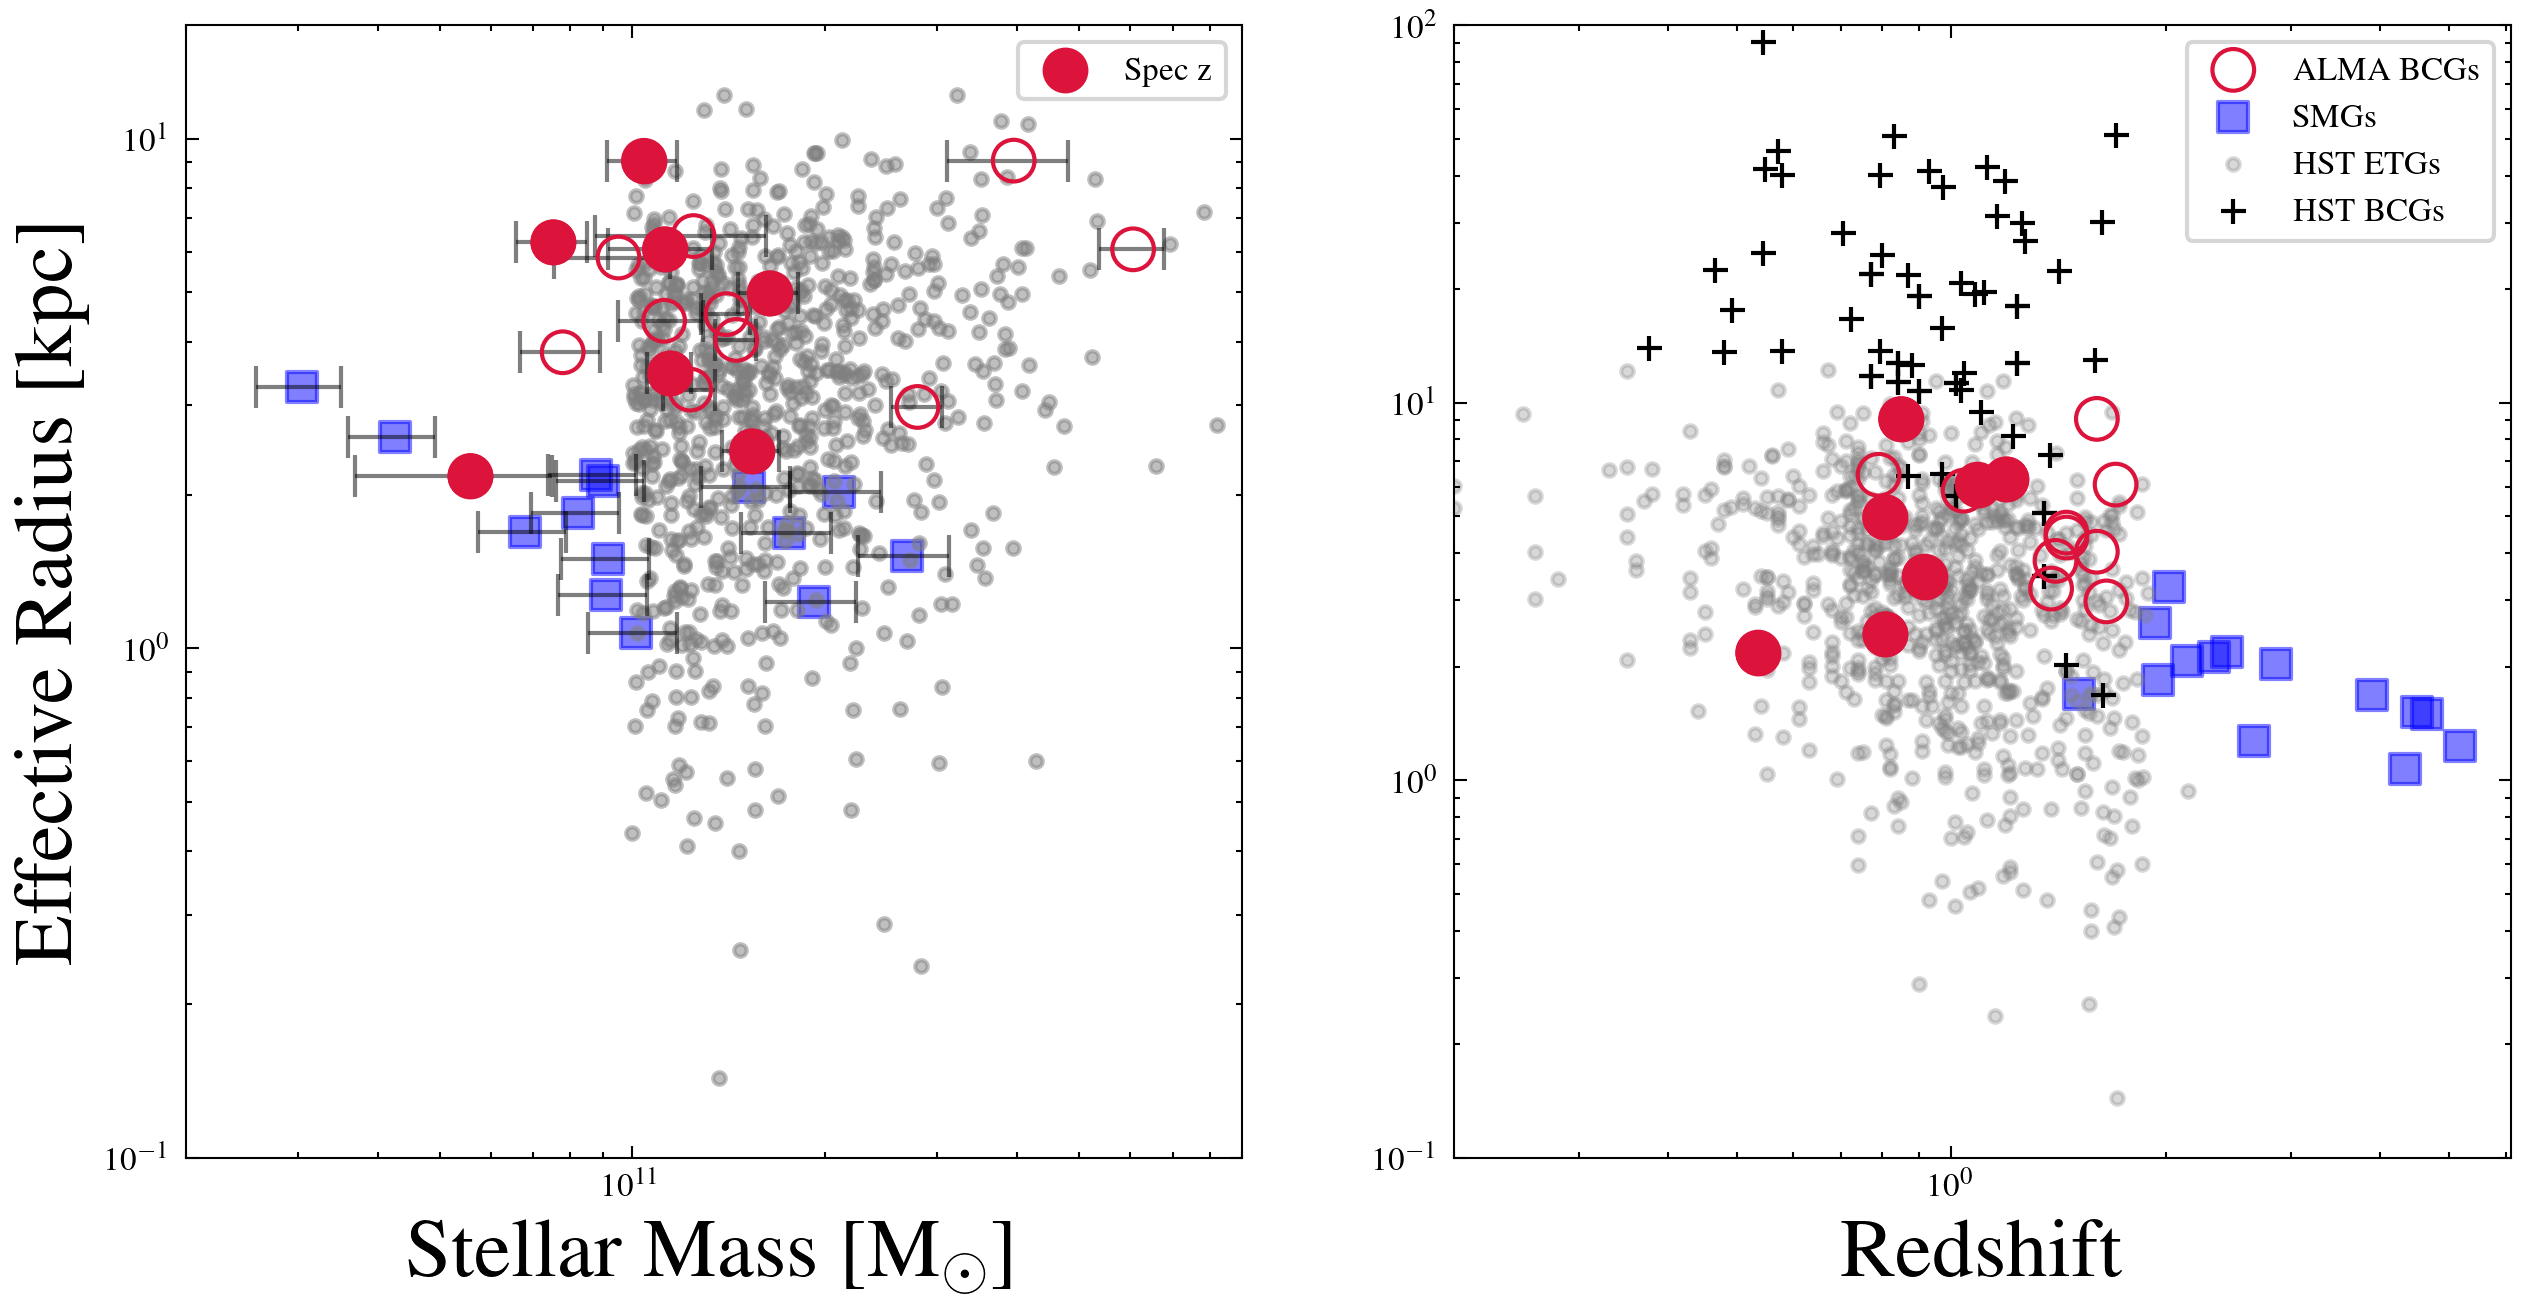

In [189]:
fig,ax = plt.subplots(1,2, figsize = (10,5), dpi = 300)
ax[0].scatter(final_results['Stellar_mass'], final_results['re_kpc_sersic'], marker = 'o', s = 100, color = 'crimson', facecolors = 'none', zorder = 10)
ax[0].scatter(specz['Stellar_mass'], specz['re_kpc_sersic'], marker = 'o', s = 100, color = 'crimson', label = "Spec z", zorder = 10)
ax[0].errorbar(final_results['Stellar_mass'], final_results['re_kpc_sersic'], xerr = final_results['Stellar_mass_err'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax[0].scatter(10**hodge_smg['stellar_mass'], hodge_smg['Re_kpc'], marker = 's',s = 50, color = 'blue', alpha = 0.5)
ax[0].errorbar(10**hodge_smg['stellar_mass'], hodge_smg['Re_kpc'], xerr = (10**(hodge_smg['stellar_mass'] + hodge_smg['stellar_mass_err']) - 10**(hodge_smg['stellar_mass'])),ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax[0].scatter(etg['stellar_mass'] * 10**10, etg['re_kpc'], color = 'grey', marker = '.', alpha = 0.5)
ax[0].set_ylabel("Effective Radius [kpc]", size = 20)
ax[0].set_xlabel("Stellar Mass [M$_\odot$]", size = 20)
ax[0].set_xscale('log')
ax[0].legend(scatterpoints=1, frameon = True)
ax[0].set_yscale('log')
ax[0].set_ylim(10**-1)
ax[0].set_xlim(2*10**10, 9*10**11)

ax[1].scatter(final_results['redshift'], final_results['re_kpc_sersic'], marker = 'o', facecolors= 'none', s = 100, color = 'crimson', label = "ALMA BCGs", zorder = 10)
ax[1].scatter(specz['redshift'], specz['re_kpc_sersic'], marker = 'o', s = 100, color = 'crimson', zorder = 10)
ax[1].scatter(hodge_smg['z'], hodge_smg['Re_kpc'], marker = 's',s = 50, color = 'blue', label = "SMGs", alpha = 0.5)
ax[1].scatter(etg['z'], etg['re_kpc'], color = 'grey', marker = '.', alpha = 0.3, label = "HST ETGs")
ax[1].scatter(hst_bcgs['z'], hst_bcgs['re'],  color = 'black', marker = '+', label = 'HST BCGs')
# ax[1].set_ylabel("Effective Radius [kpc]")
ax[1].set_xlabel("Redshift", size = 20)
ax[1].legend(scatterpoints=1, frameon = True)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_ylim(10**-1, 10**2)
ax[1].set_xlim(2*10**-1)

# fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/re_mstar_z.png", dpi = 300)

In [450]:
detected_bcgs = ["CDFS-18", "ES1-18", "ES1-25", "ES1_z_0.99",
"ES1_z_0.99b", "ES1_z_1.04", "ES1_z_1.38", "ES1_z_1.40", 
"ES1_z_1.60", "ES1_z_1.65", "ES1_z_1.70", "XMM-113", "XMM-11", "XMM-29", "XMM-30",
"XMM_z_0.9", "XMM_z_1.0"]

In [451]:
with open("/Users/arames52/bcg_dust_continuum/notebook/data/CASA_imaging/all_imfit_results.pkl", "rb") as f:
    all_imfit_results = pickle.load(f)

In [452]:
def extract_imfit_results():

    flux_dict = {}
    flux_err_dict = {}
    beam_dict = {}

    with open("/Users/arames52/bcg_dust_continuum/notebook/data/CASA_imaging/all_imfit_results.pkl", "rb") as f:
        imfit_results = pickle.load(f)
    
    for i in range(4):
        flux_dict[i] = [val[i]['deconvolved']['component0']['flux']['value'][0] if val[i] != False else np.nan for key, val in imfit_results.items()]
        flux_err_dict[i] = [val[i]['deconvolved']['component0']['flux']['error'][0] if val[i] != False else np.nan for key, val in imfit_results.items()]
        beam_dict[i] = [round(val[i]['deconvolved']['component0']['beam']['beamarcsec']['major']['value'],1) if val[i] != False else np.nan for key, val in imfit_results.items()]
    
    return flux_dict, flux_err_dict, beam_dict, list(imfit_results.keys())

def plot_imfit_results():

    fig, ax = plt.subplots(4,4, figsize = (12,8), dpi = 300, sharex = True)
    ax = ax.ravel()
    flux, fluxerr, beam, bcgs = extract_imfit_results()
    for i in range(16):
        for j in range(4):
            ax[i].scatter(beam[j][i], flux[j][i] * 1000, marker = 'o', color = 'green')
            ax[i].errorbar(beam[j][i], flux[j][i] * 1000, yerr =  fluxerr[j][i] * 1000, ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 0.5)
        ax[i].set_title(bcgs[i])

    return fig

/Users/arames52/opt/anaconda3/envs/anjali/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1146: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/Users/arames52/opt/anaconda3/envs/anjali/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1147: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/Users/arames52/opt/anaconda3/envs/anjali/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/arames52/opt/anaconda3/envs/anjali/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


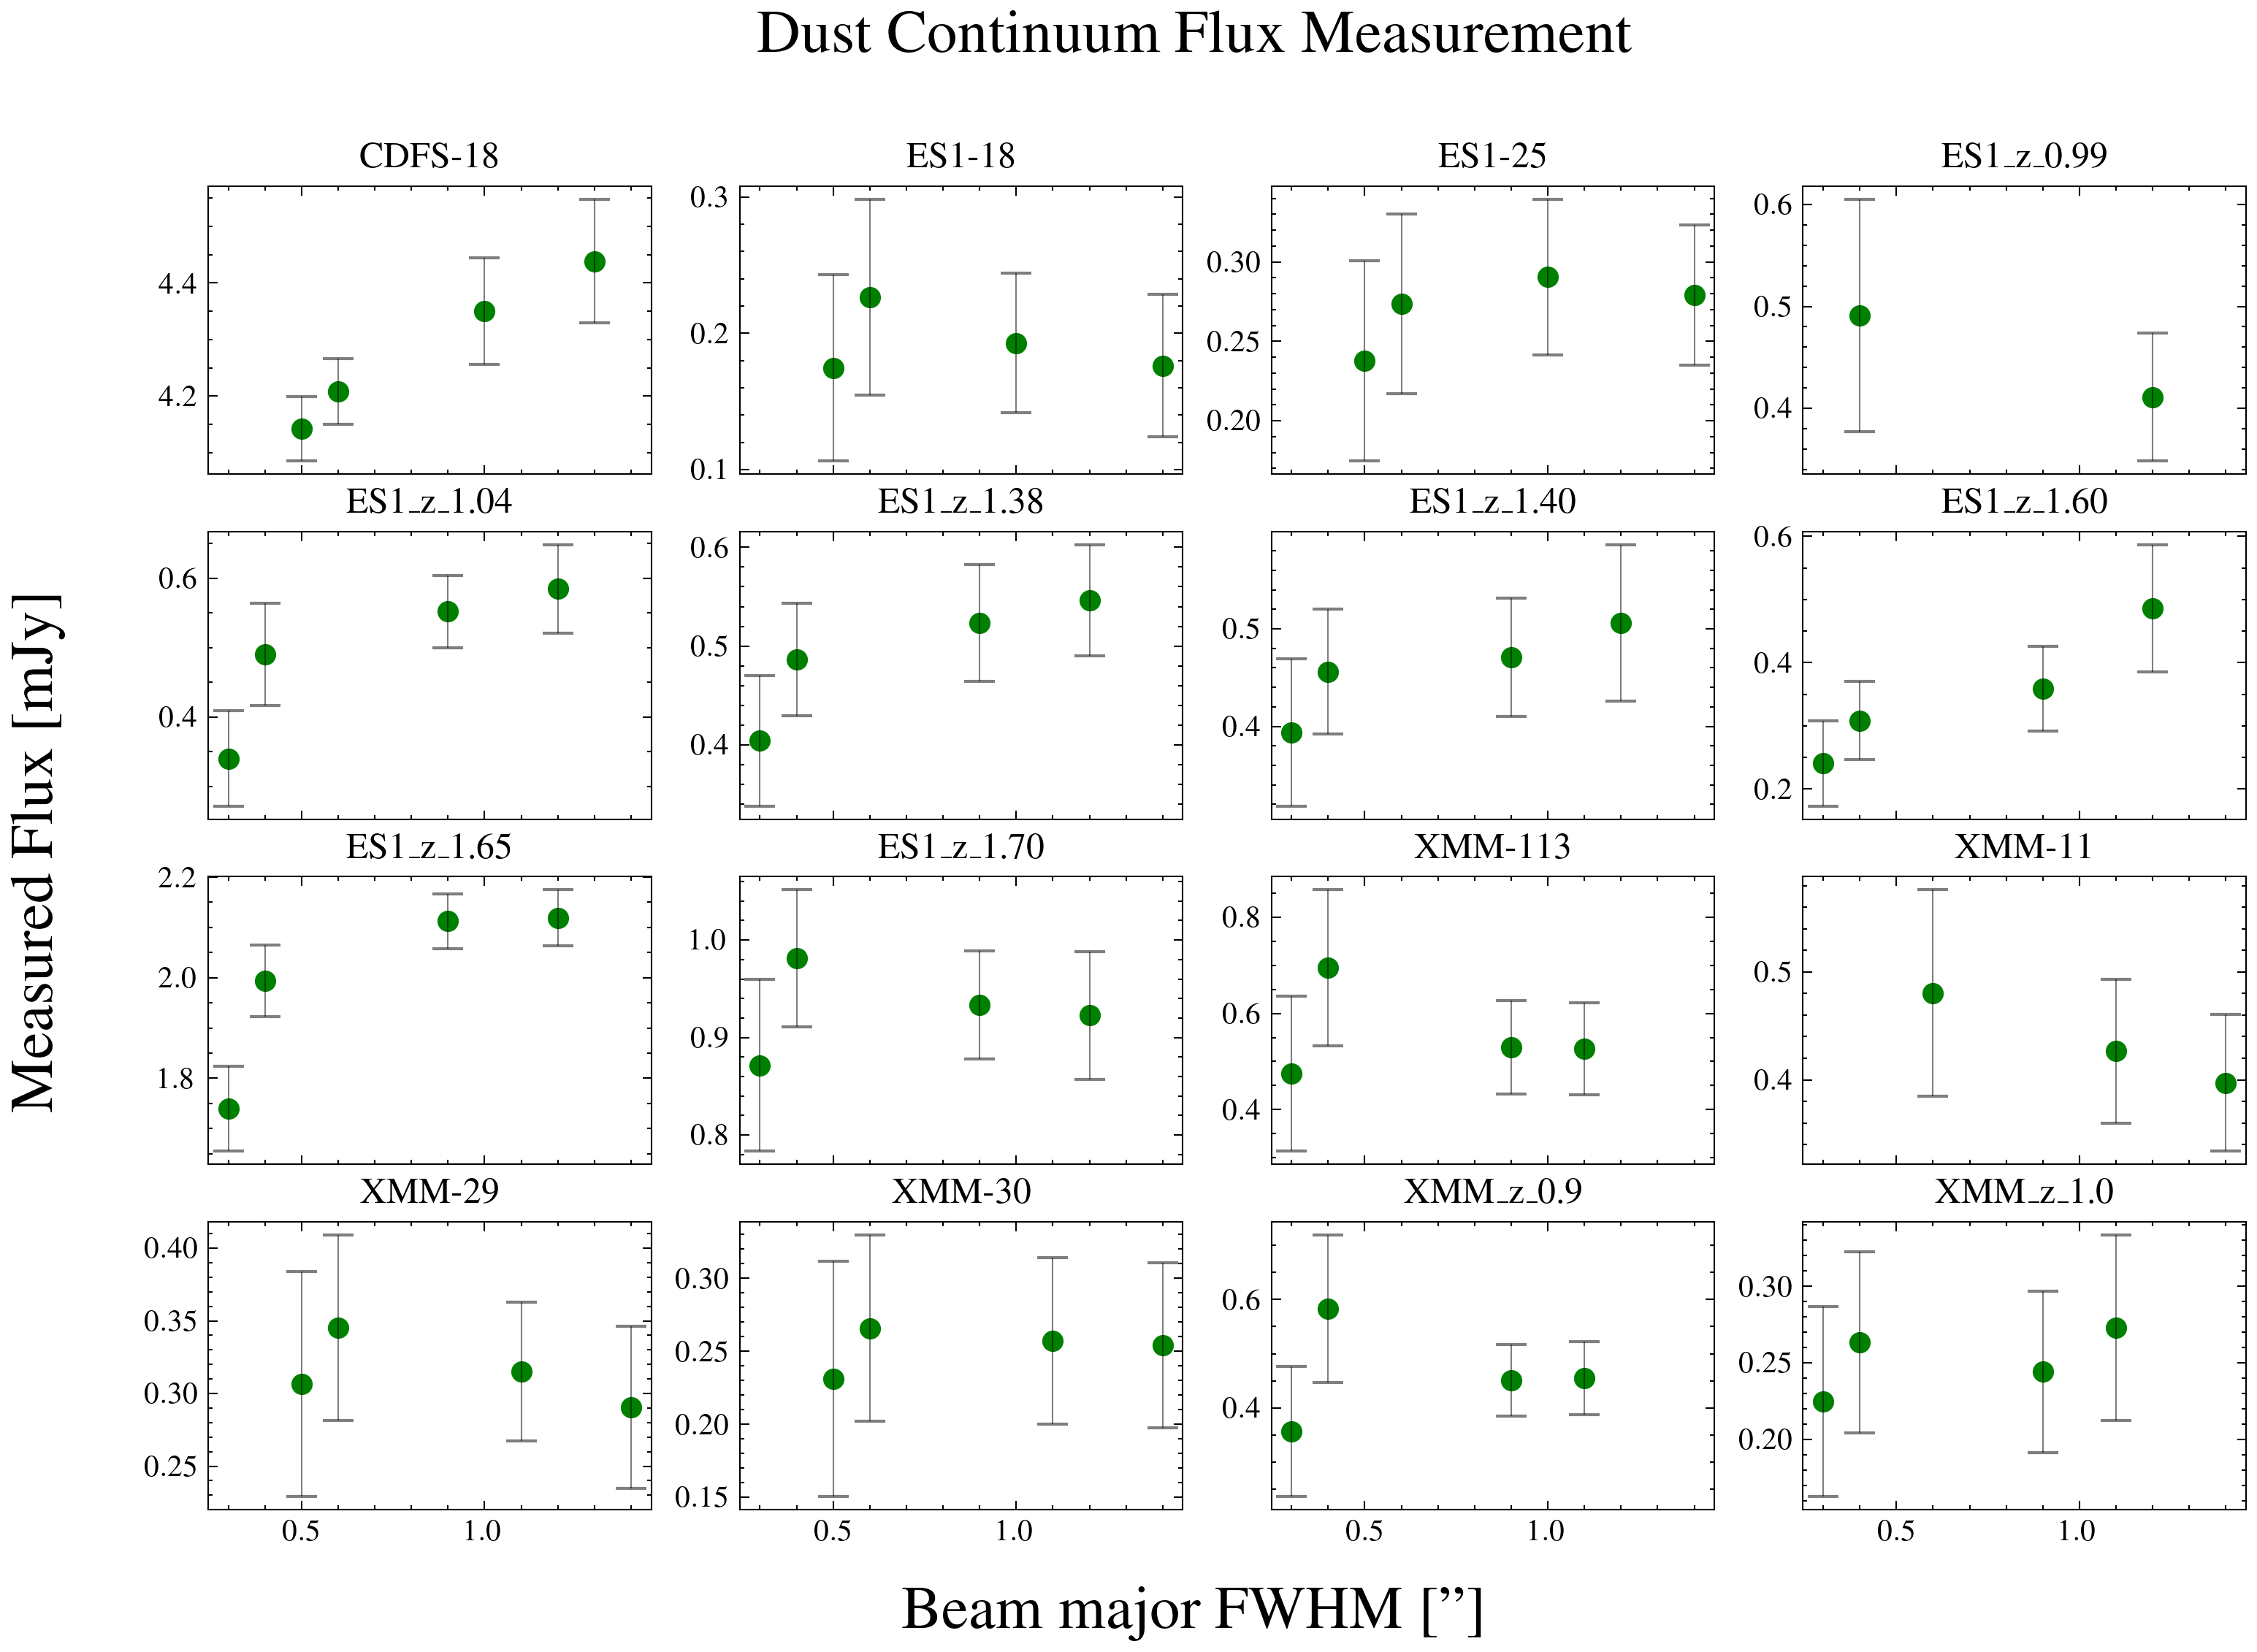

In [173]:
%matplotlib inline
plt.style.use("science")
fig = plot_imfit_results()
fig.suptitle("Dust Continuum Flux Measurement", size = 20)
fig.supxlabel("Beam major FWHM ['']", size = 20, y = 0.05)
fig.supylabel("Measured Flux [mJy]", size = 20, x = 0.05)
fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/imfit_plot.png", dpi = 300)

In [453]:
def extract_natural_imfit_results():

    with open("/Users/arames52/bcg_dust_continuum/notebook/data/CASA_imaging/natural_imfit_results.pkl", "rb") as f:
        imfit_results = pickle.load(f)

    shape_dict = {}
    flux_dict = {}
    alma_centroid = {}

    for key,val in imfit_results.items():
        flux_dict[key] = [val['deconvolved']['component0']['flux']['value'][0] * 1000, val['deconvolved']['component0']['flux']['error'][0] * 1000, round(val['deconvolved']['component0']['beam']['beamarcsec']['major']['value'],1)]
        shape_dict[key] = [val['deconvolved']['component0']['shape']['majoraxis']['value'], val['deconvolved']['component0']['shape']['majoraxiserror']['value'], val['deconvolved']['component0']['shape']['minoraxis']['value'], 
        val['deconvolved']['component0']['shape']['minoraxiserror']['value'], val['deconvolved']['component0']['shape']['positionangle']['value'], val['deconvolved']['component0']['shape']['positionangleerror']['value']]
        alma_centroid[key] = val['results']['component0']['pixelcoords']
    return flux_dict, shape_dict, alma_centroid

In [454]:
non_detections = ["ES1-12", "ES1-26", "ES1-35", "CDFS19", "XMM-19", "XMM-27"]
good_detections = ["CDFS-18", "ES1-18", "ES1-25", "ES1_z_0.99", "ES1_z_1.04", "ES1_z_1.38", "ES1_z_1.40", 
"ES1_z_1.60", "ES1_z_1.65", "ES1_z_1.70", "XMM-113", "XMM-11", "XMM-29", "XMM-30",
"XMM_z_0.9", "XMM_z_1.0"]
weak_detections = ["ES1-34", "ES1_z_0.88","ES1_z_0.99b", "XMM_z_0.81"]

In [455]:
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.modeling.functional_models import Ellipse2D
from matplotlib.lines import Line2D
import matplotlib.colors as colors
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm, ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization.stretch import LinearStretch, LogStretch
import pandas as pd
import sys
sys.path.append("/Users/arames52/bcg_dust_continuum/src/")
import image_properties as img_prop
import data_ingestion as dload
import multiwavelength_catalog as mwcat
import cmocean
import numpy as np
import pickle

In [458]:
# Image Path 
des_images_path = "/Users/arames52/bcg_dust_continuum/notebook/data/MW_images/DES_images/"
sparcs_images_path = "/Users/arames52/bcg_dust_continuum/notebook/data/MW_images/Sparcs_z_images/"
irac_images_path = "/Users/arames52/bcg_dust_continuum/notebook/data/MW_images/IRAC_images/"
mips_images_path = "/Users/arames52/bcg_dust_continuum/notebook/data/MW_images/MIPS_images/"
alma_images_path = "/Users/arames52/bcg_dust_continuum/notebook/data/MW_images/ALMA_images/"

In [459]:
def calculate_offsets():
    offset_dict = {}
    for bcg_name in good_detections:
        _,_,alma_centroid = extract_natural_imfit_results()
        _, mw_cat, _ = mwcat.multiwavelength_catalog(bcg_name)
        redshift = bcg_redshift_df[bcg_redshift_df['bcg'] == bcg_name]['redshift'].values[0]
        alma_img = img_prop.file_from_string(alma_images_path, bcg_name)
        z_img = img_prop.file_from_string(sparcs_images_path, bcg_name)
        data_z, header_z, wcs_z = dload.read_any_fits(z_img)
        data_alma, header_alma, wcs_alma = dload.read_alma_fits(alma_img)
        alma_center_pix = alma_centroid[bcg_name]
        alma_center = wcs_alma.pixel_to_world(alma_center_pix[0], alma_center_pix[1])
        alma_center_skycoord = SkyCoord(alma_center.ra, alma_center.dec, distance = cosmo.angular_diameter_distance(redshift), frame = 'icrs')
        z_center = mw_cat['sparcs_nn'].iloc[0]
        z_center_skycoord = SkyCoord(z_center['ra']*u.degree, z_center['dec']*u.degree, frame = 'icrs', distance = cosmo.angular_diameter_distance(redshift))
        sep = z_center_skycoord.separation(alma_center_skycoord)
        sep_kpc = round((sep.arcsecond/(cosmo.kpc_proper_per_arcmin(redshift)/60).value), 2)
        pa = z_center_skycoord.position_angle(alma_center_skycoord)
        dra, ddec = z_center_skycoord.spherical_offsets_to(alma_center_skycoord)    
        return_dict = {"alma_ra": alma_center_skycoord.ra.value, "alma_dec": alma_center_skycoord.dec.value,
        "z_ra": z_center_skycoord.ra.value, "z_dec":z_center_skycoord.dec.value, "alma_wcs": wcs_alma, "z_wcs": wcs_z,
        "sep_arcsec" : sep.arcsecond, "sep_kpc": sep_kpc, "dra_arcsec": dra.to(u.arcsec).value, 
        "ddec_arcsec": ddec.to(u.arcsec).value, "redshift": redshift}
        offset_dict[bcg_name] = return_dict

    return offset_dict

In [460]:
offset_dict = calculate_offsets()

In [322]:
import sys
sys.path.append("/Users/arames52/bcg_dust_continuum/src/")
import results_table as rt

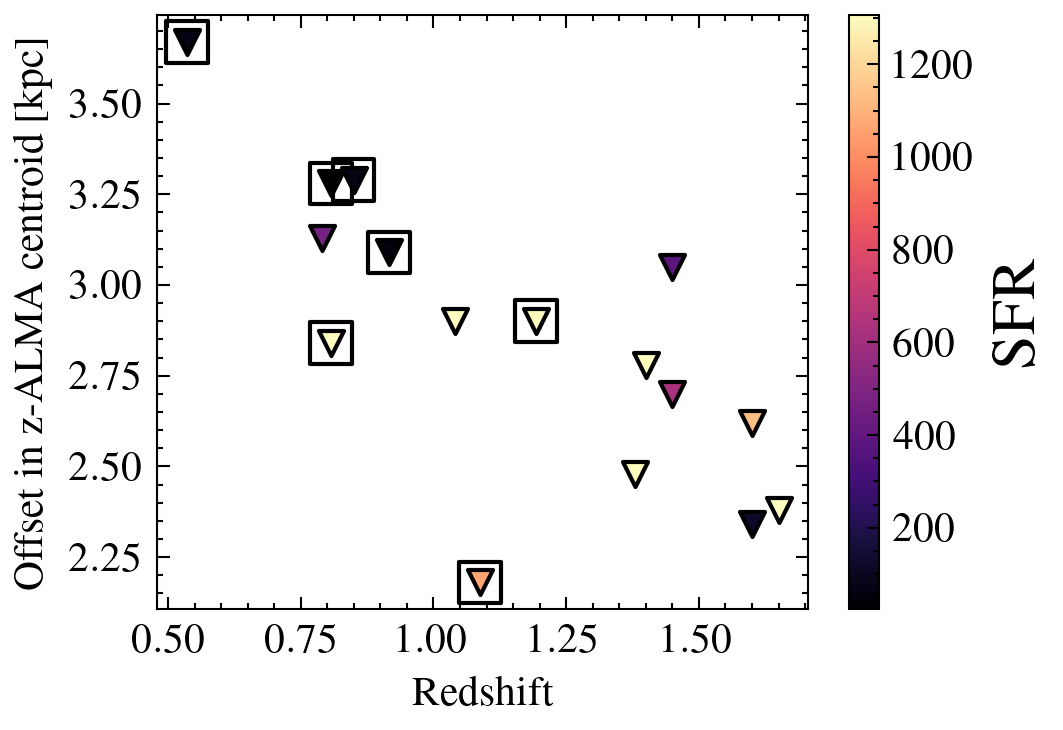

In [338]:
plt.style.use("science")
color_bar_vals = []
fig,ax = plt.subplots(1,1, dpi = 300)
for key,val in offset_dict.items():
    sfr_mstar_df = rt.sfr_mstar_results(key)
    color_bar_vals.append(sfr_mstar_df['SFR'])
    vmin = min(np.array(color_bar_vals))
    vmax = max(np.array(color_bar_vals))
    redshift = bcg_redshift_df[bcg_redshift_df['bcg'] == key]['redshift'].values[0]
    specz = bcg_redshift_df[bcg_redshift_df['bcg'] == key]['spec_z'].values[0]
    offset = val['sep_kpc']
    redshift = val['redshift']
    if specz == 1:
        ax.scatter(redshift, offset, marker = 's', facecolor = 'none', edgecolor = 'black', s = 100)
    im = ax.scatter(redshift, offset, marker = 'v', c = sfr_mstar_df['SFR'], edgecolor = 'black', vmin = vmin, vmax = vmax, cmap = 'magma')
ax.set_ylabel("Offset in z-ALMA centroid [kpc]")
ax.set_xlabel("Redshift")
cbar_ax = fig.colorbar(im)
cbar_ax.set_label("SFR", size = 15)
fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/offset_z_sfr.png", dpi = 300)

In [461]:
def offset_plot_stamps(bcg_name):
    
    fig = plt.figure(dpi = 300)

    alma_img = img_prop.file_from_string(alma_images_path, bcg_name)
    z_img = img_prop.file_from_string(sparcs_images_path, bcg_name)
    data_z, header_z, wcs_z = dload.read_any_fits(z_img)
    data_alma, header_alma, wcs_alma = dload.read_alma_fits(alma_img)
    img_prop_df = bcg_properties[bcg_properties['id'] == bcg_name]
    s_n = img_prop_df['S/N'].values[0]
    rms = img_prop_df['RMS'].values[0]
    dex = img_prop_df['contour_steps'].values[0]
    levels = np.arange(2.5*rms, s_n*rms, dex*rms, dtype = None)
    if bcg_name.startswith("ES1"):
        vmax = 80
    elif bcg_name.startswith("XMM"):
        vmax = 10
    else:
        vmax = 200
    ax = fig.add_subplot(projection=wcs_alma)
    z_trans = ax.get_transform(wcs_z)
    scale = wcs_alma.proj_plane_pixel_scales()[0].to(u.arcsec).value
    ax.imshow(data_z, transform = z_trans, origin = 'lower',vmin = 0, vmax=vmax, cmap = 'Greys_r')
    ax.contour(data_alma, levels=levels, colors='red', linewidths = 1, zorder = 1)
    ax.coords[0].set_ticks_visible(False)
    ax.coords[0].set_ticklabel_visible(False)
    ax.coords[1].set_ticks_visible(False)
    ax.coords[1].set_ticklabel_visible(False)
    ax.set_xlim(header_alma['CRPIX1']-50,header_alma['CRPIX1']+50)
    ax.set_ylim(header_alma['CRPIX2']-50,header_alma['CRPIX2']+50)

    return fig

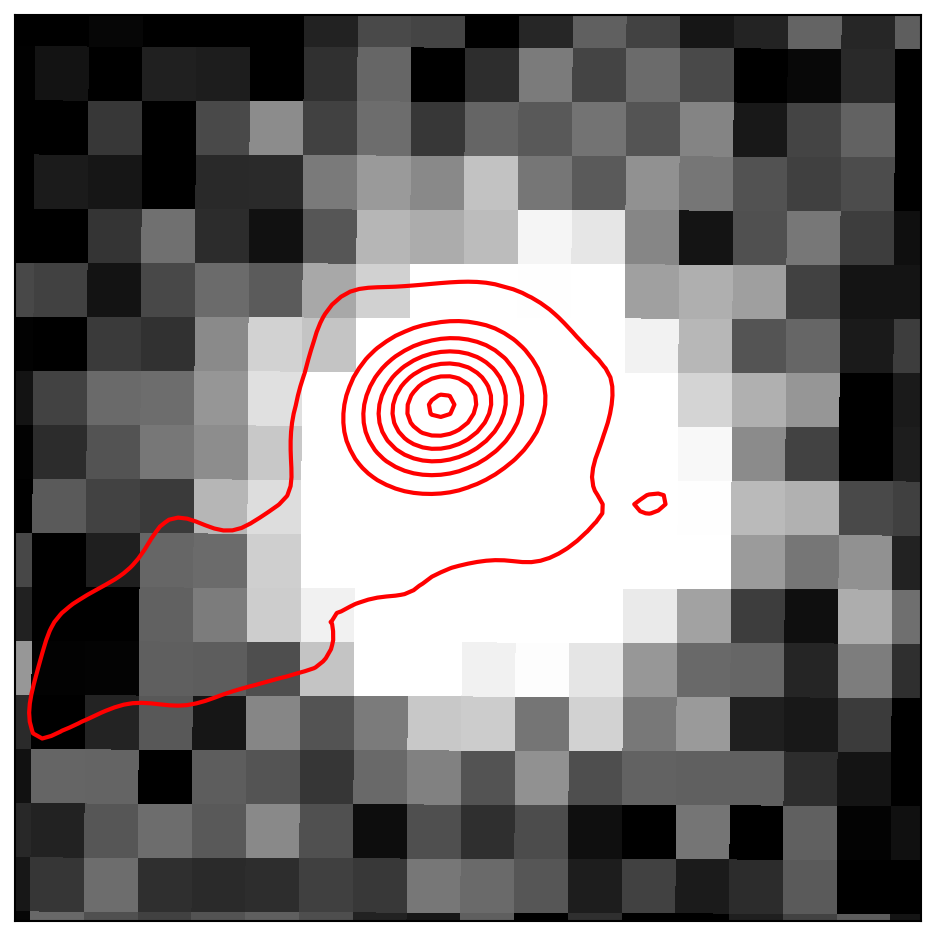

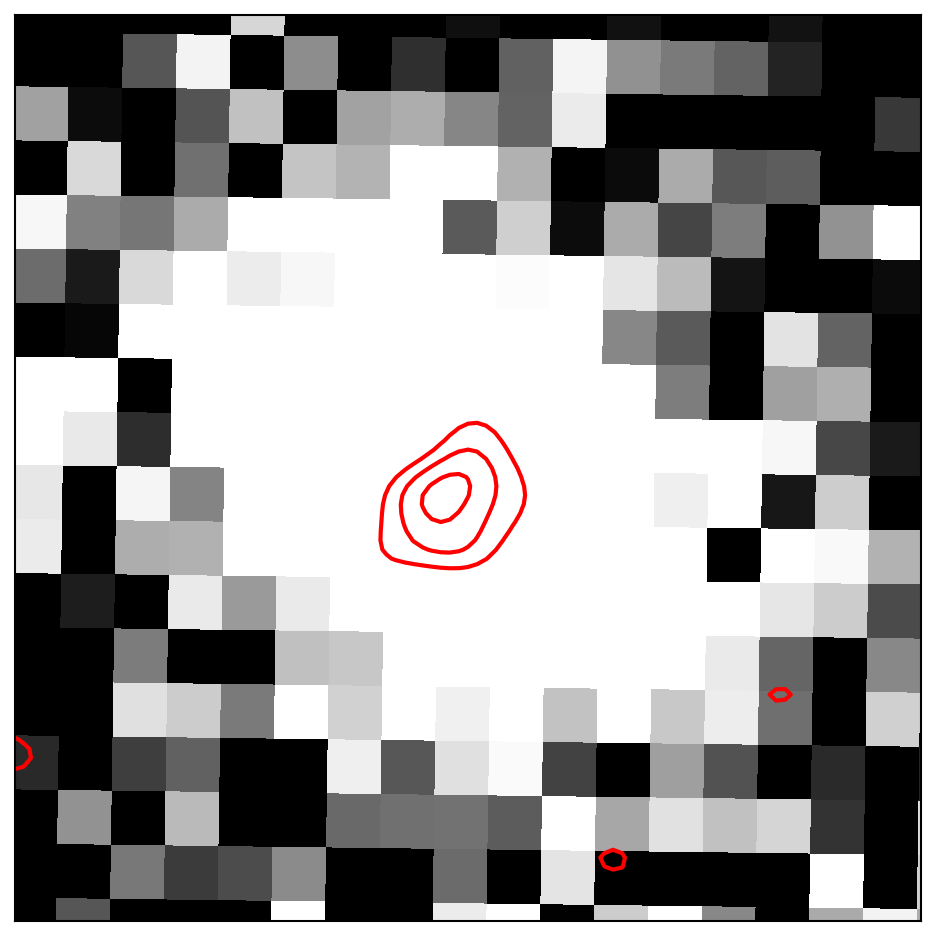

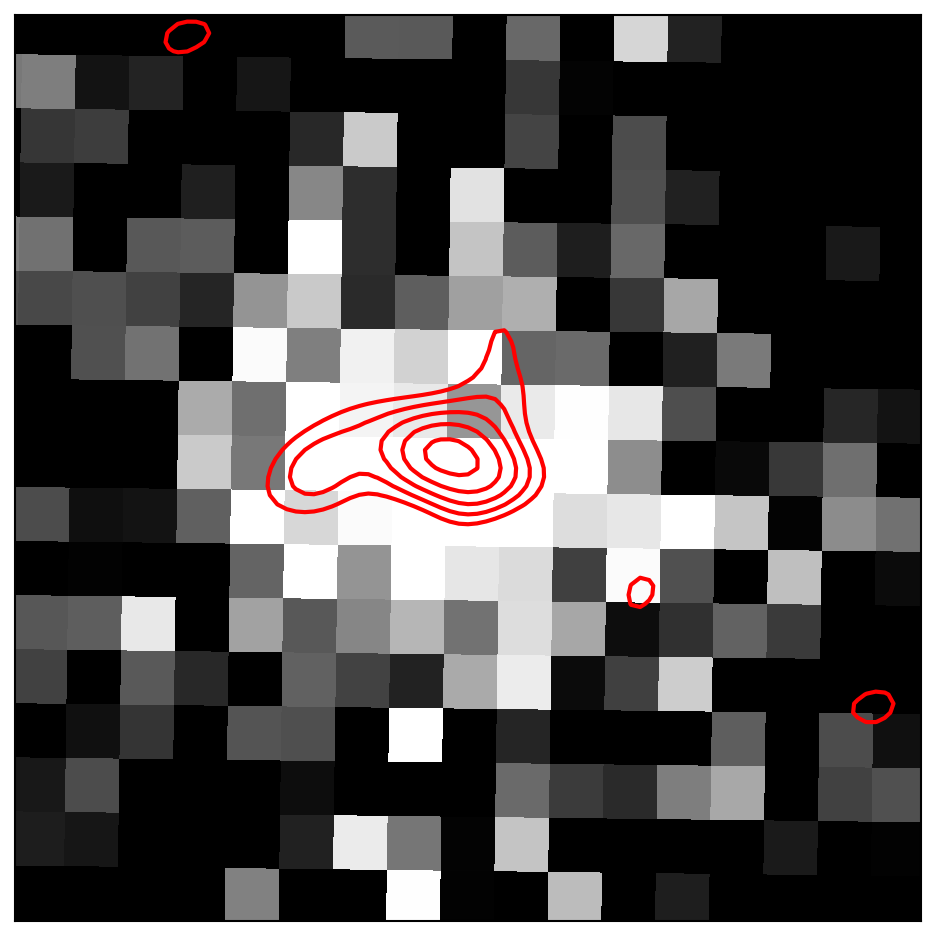

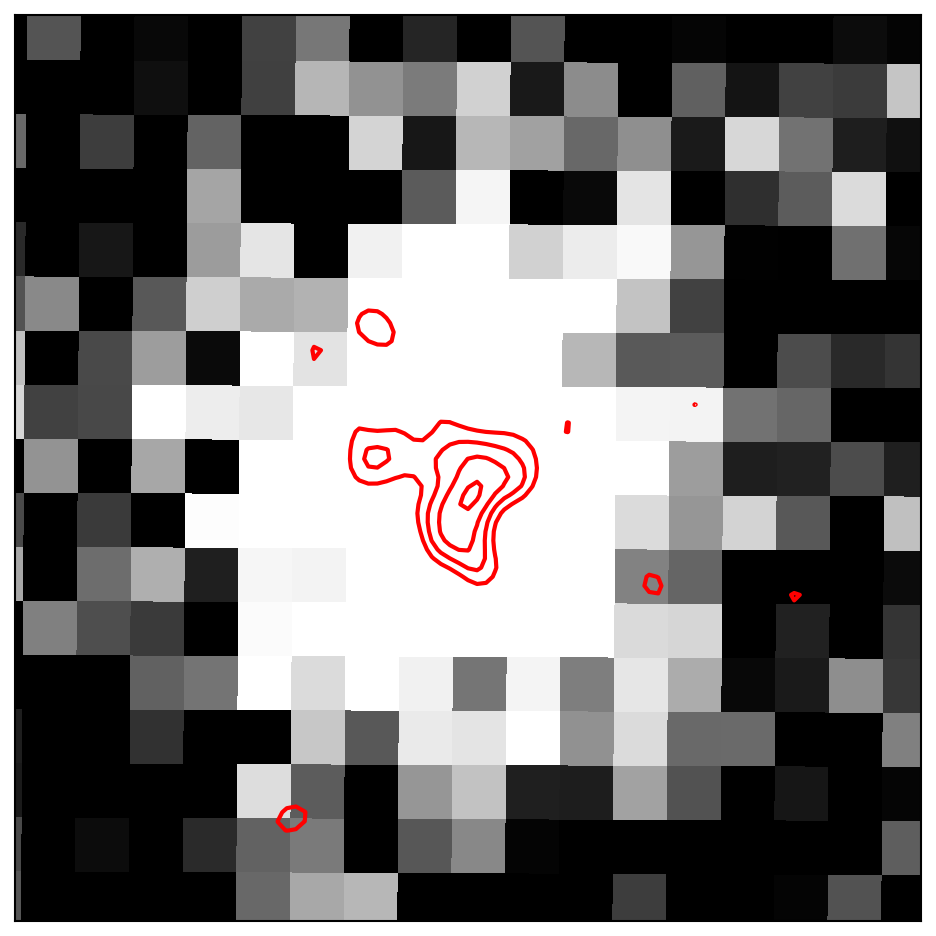

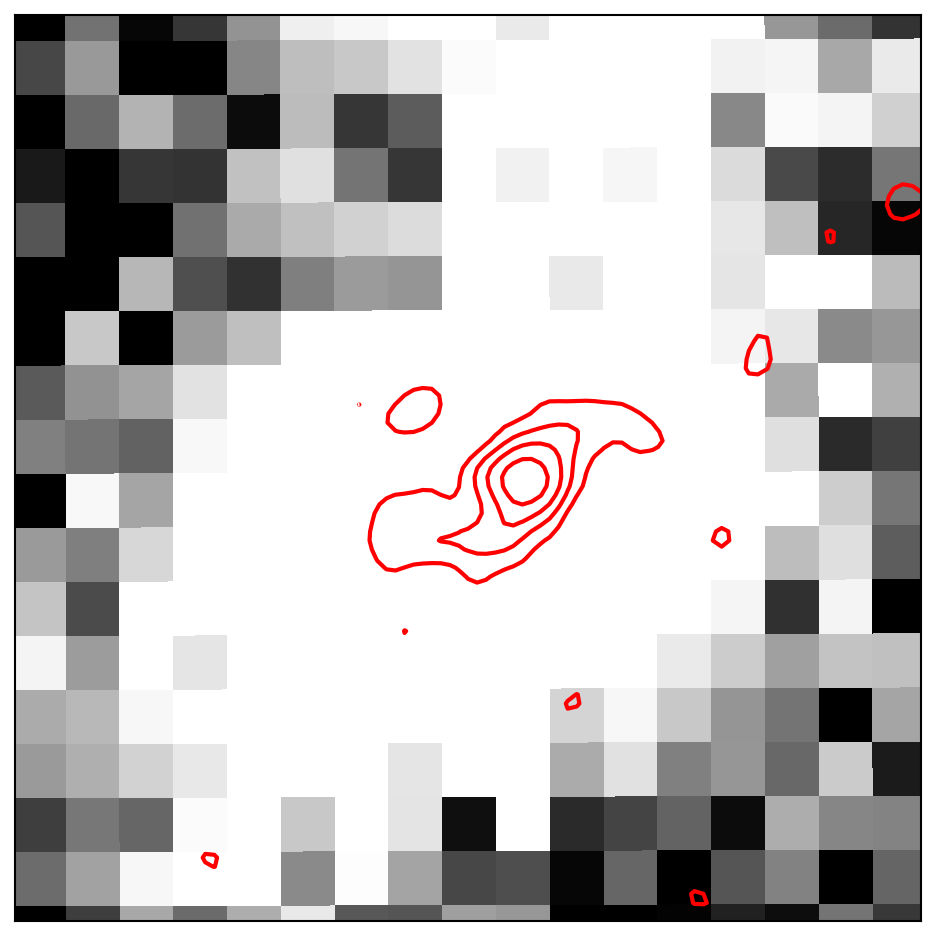

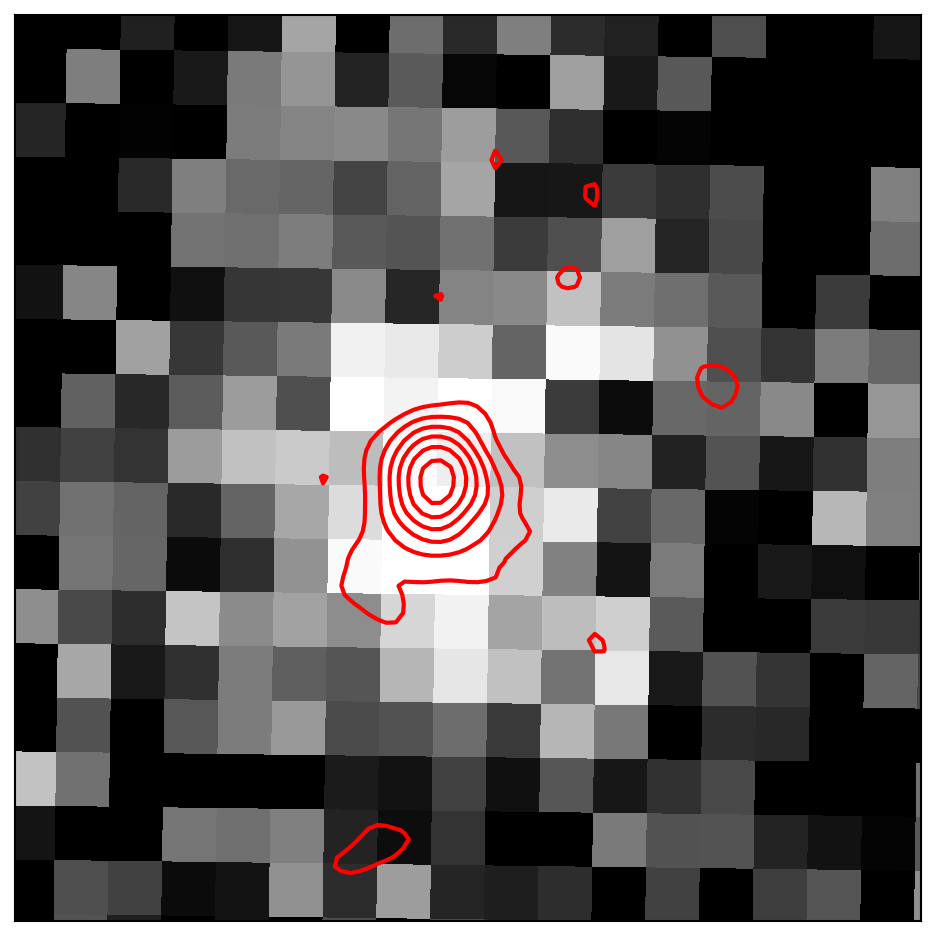

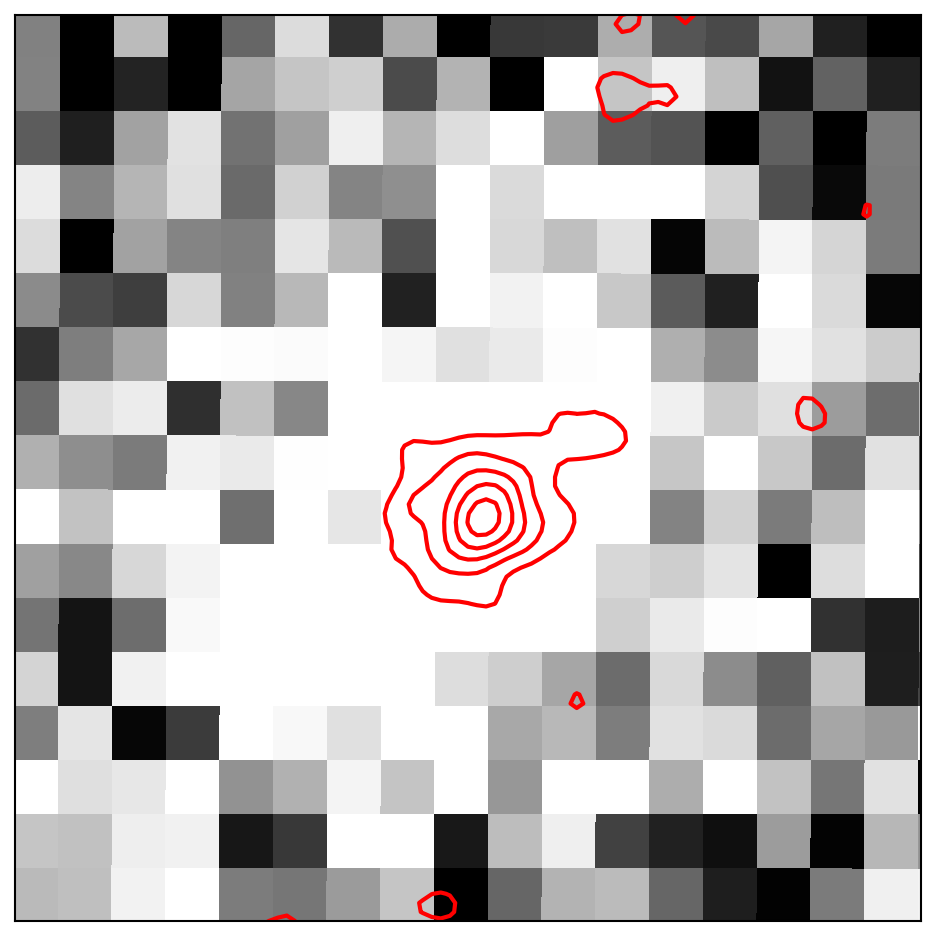

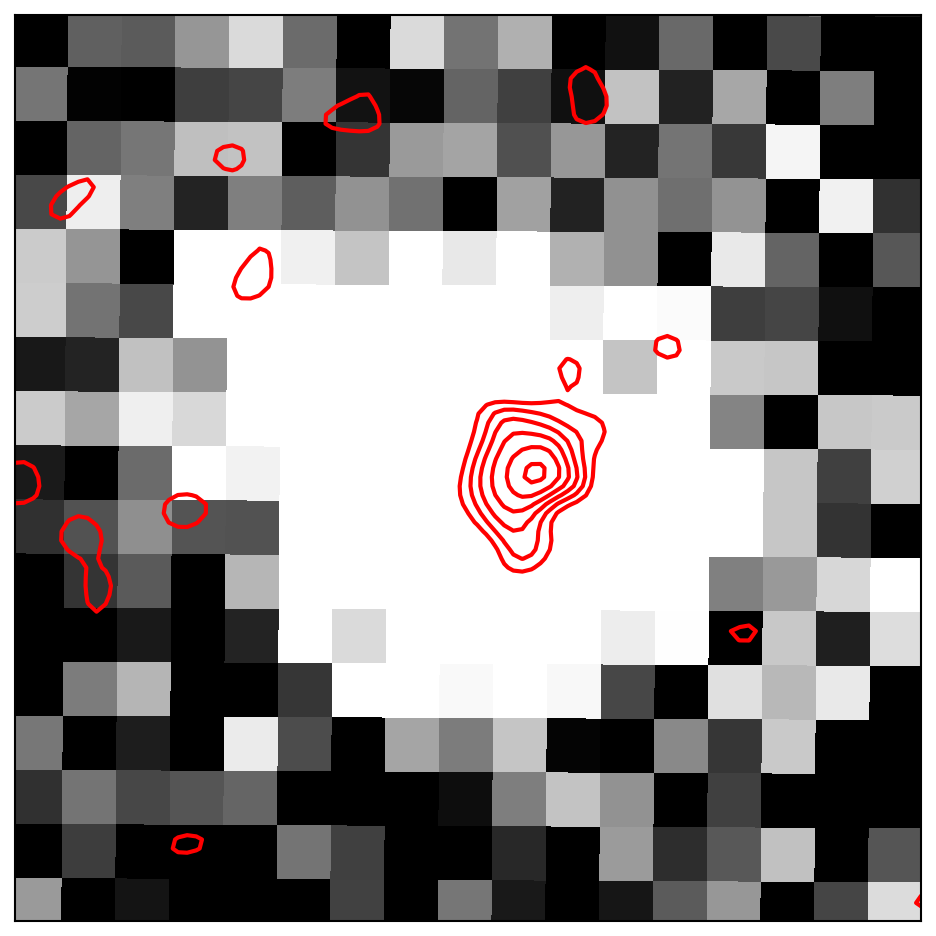

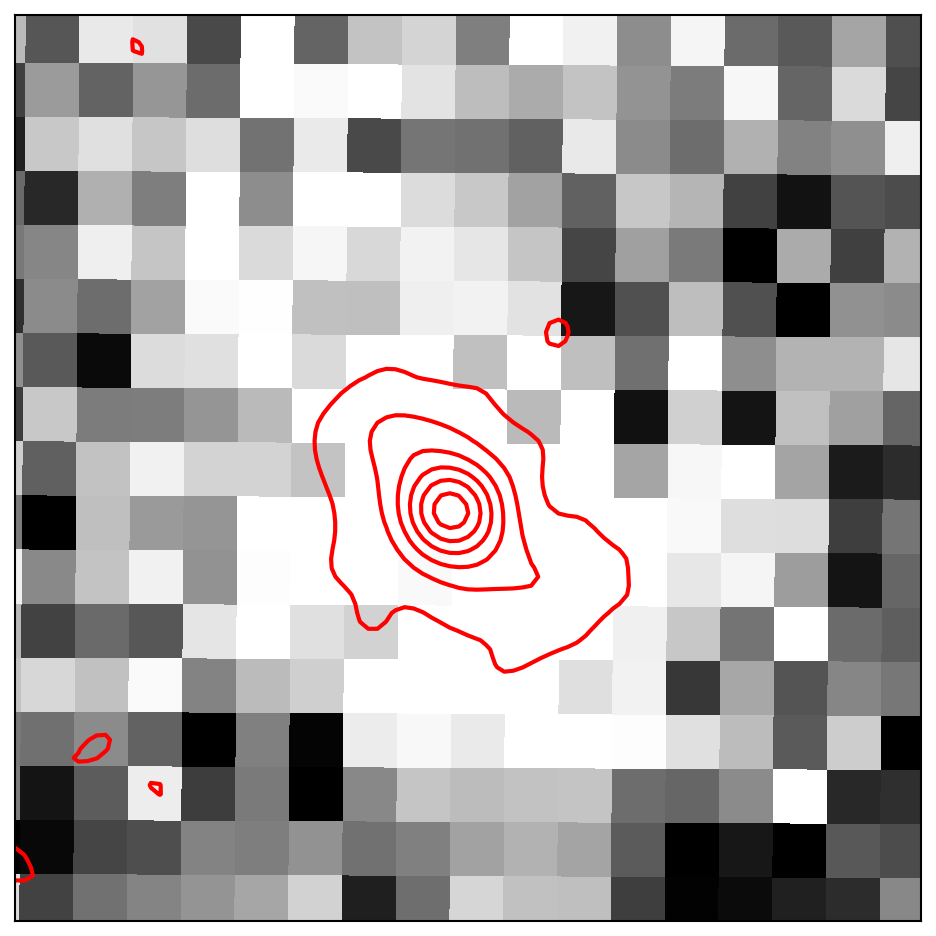

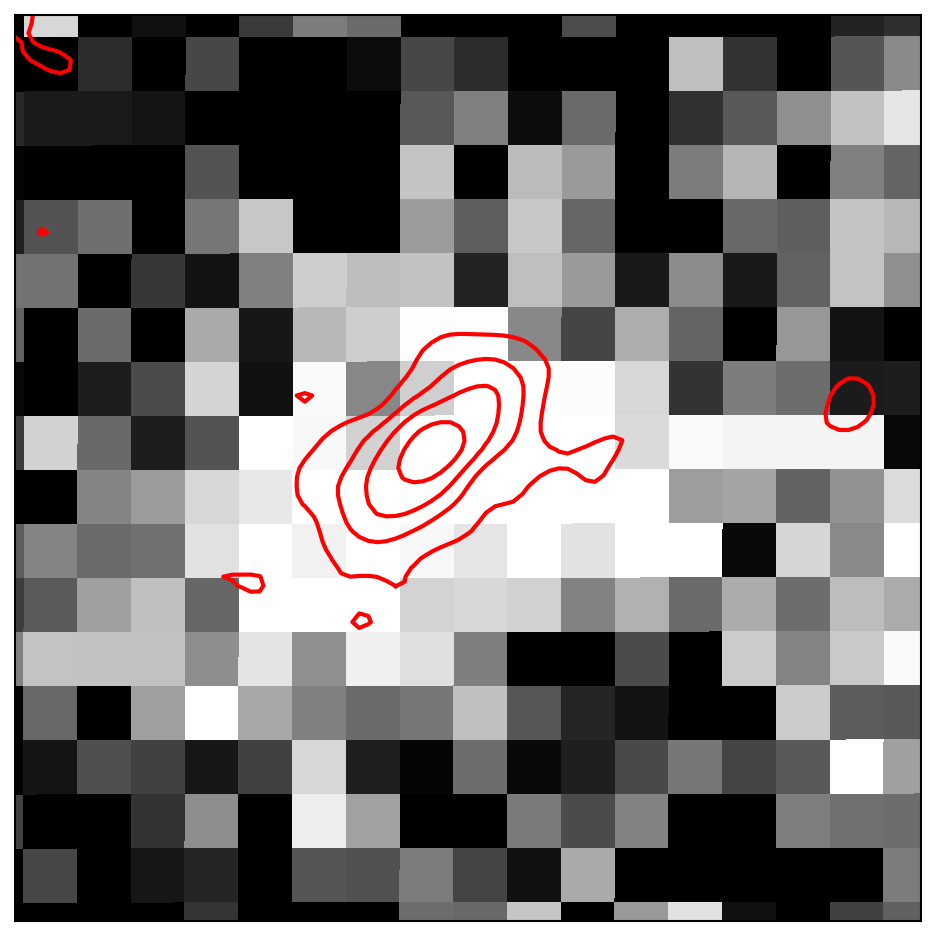

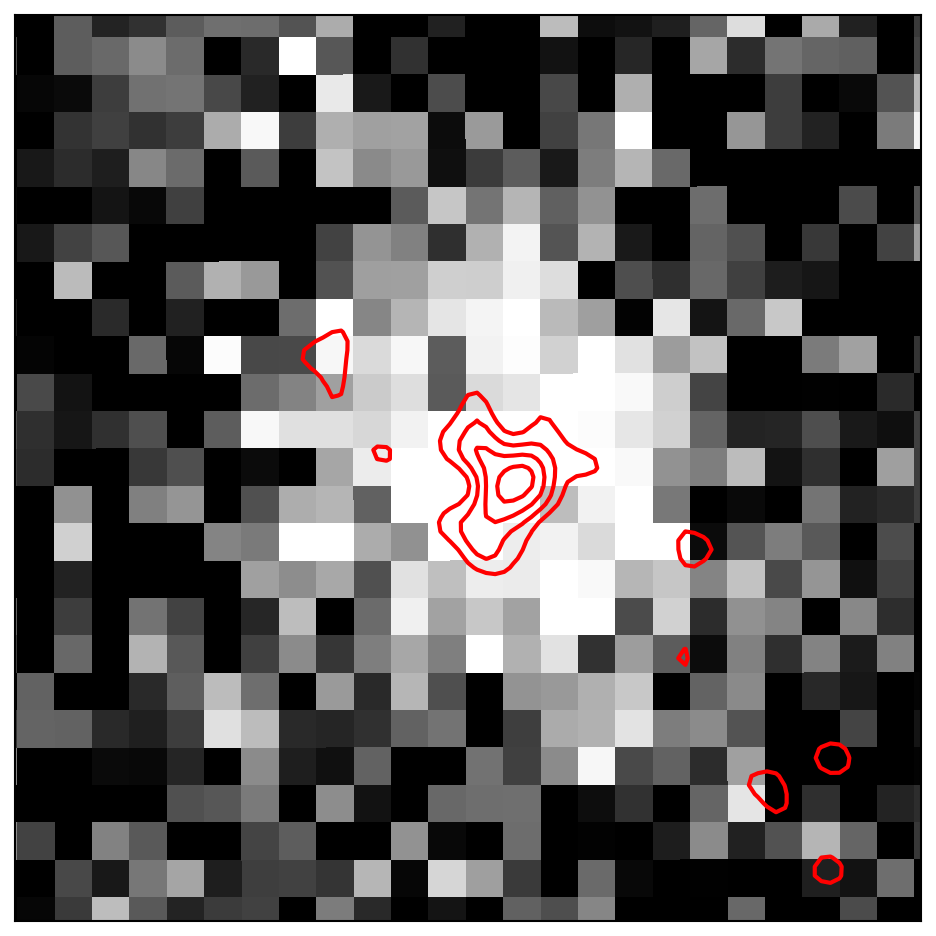

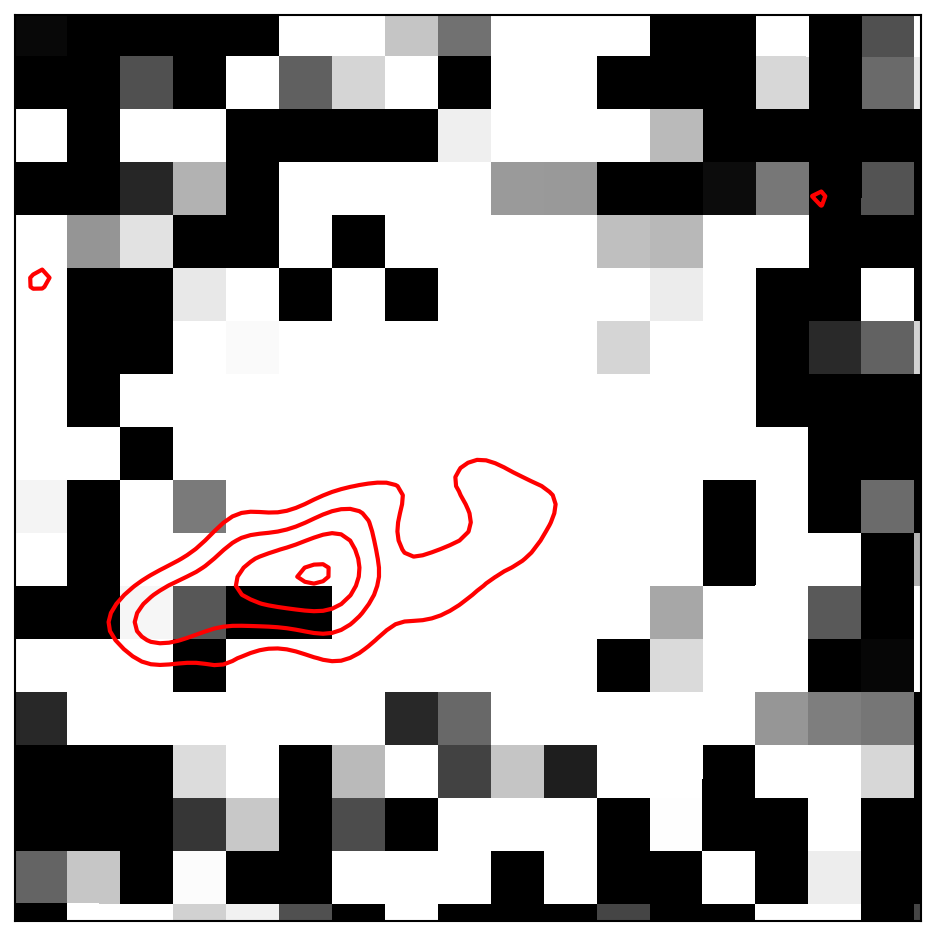

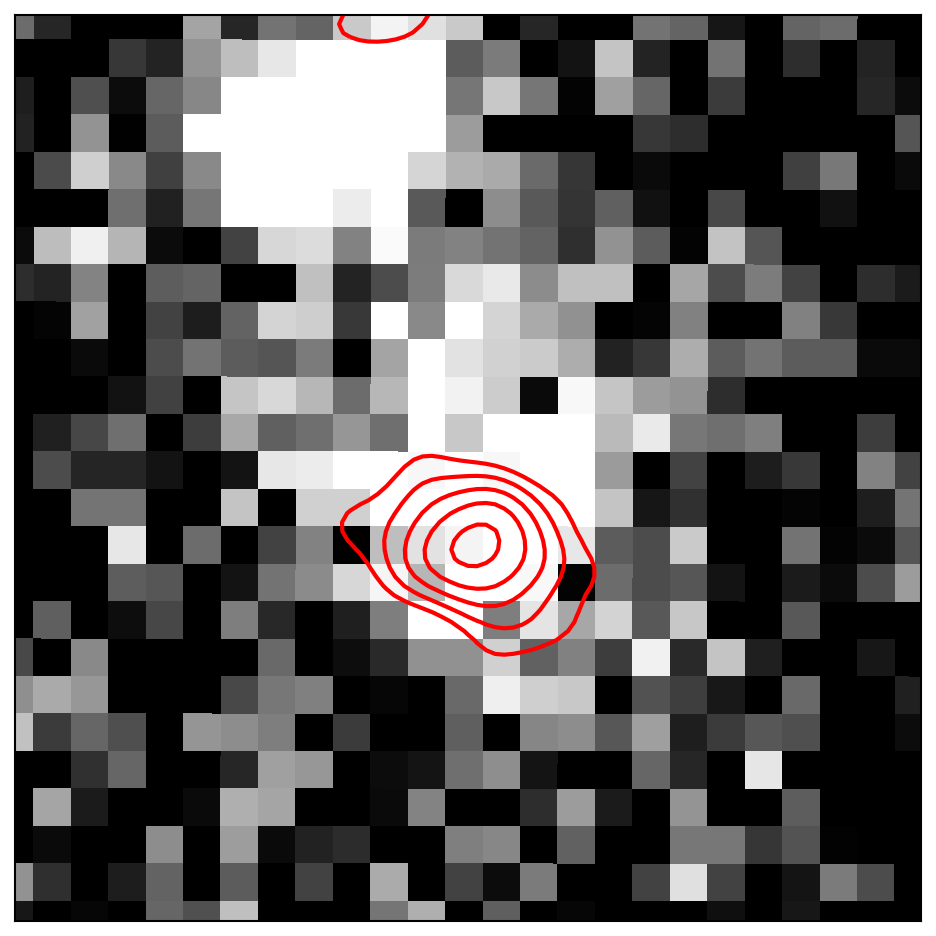

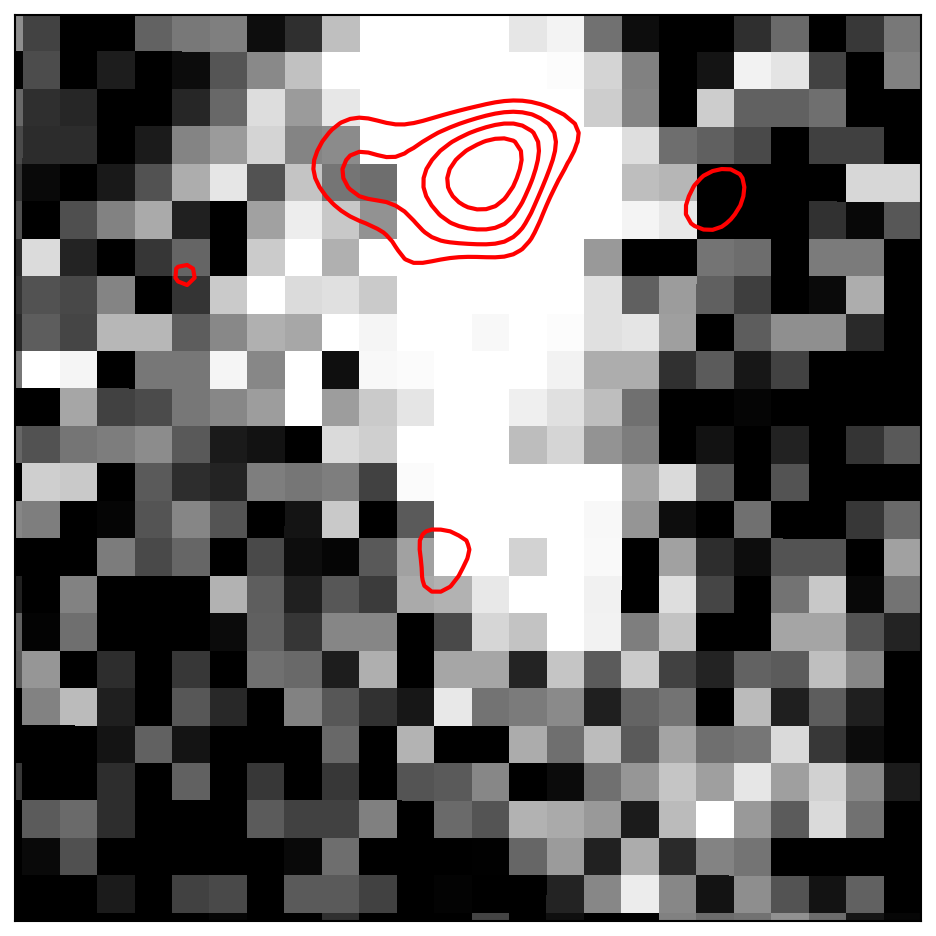

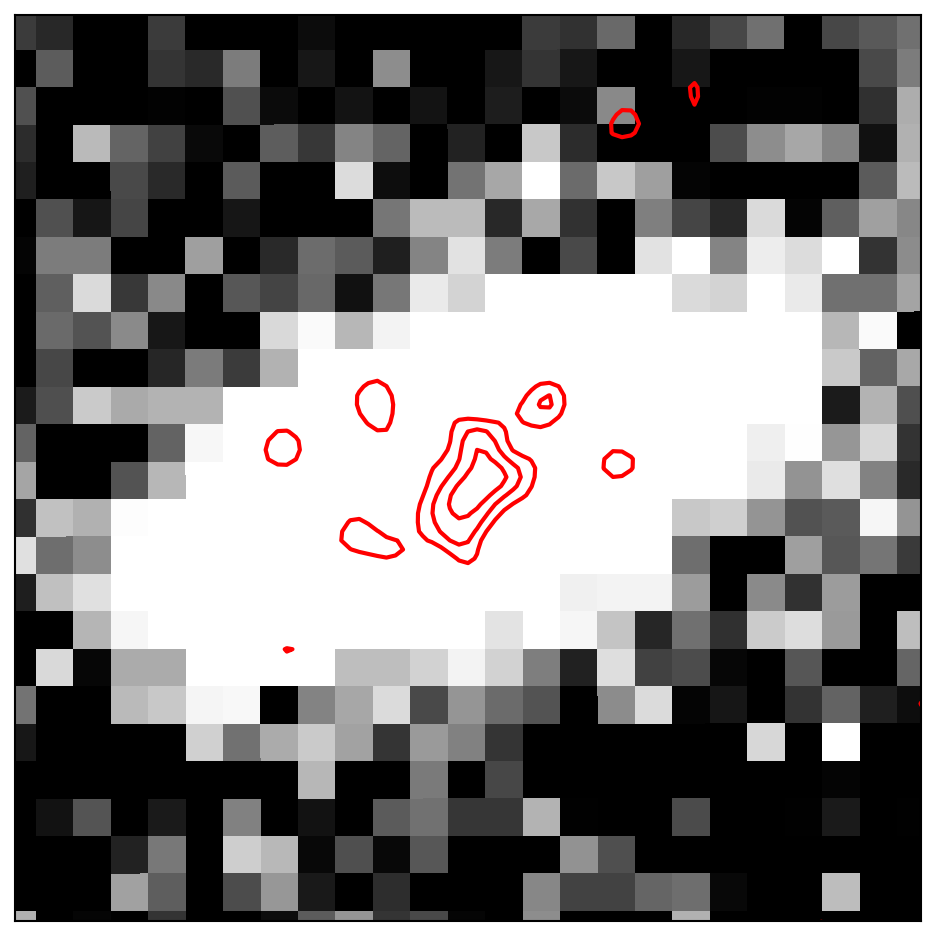

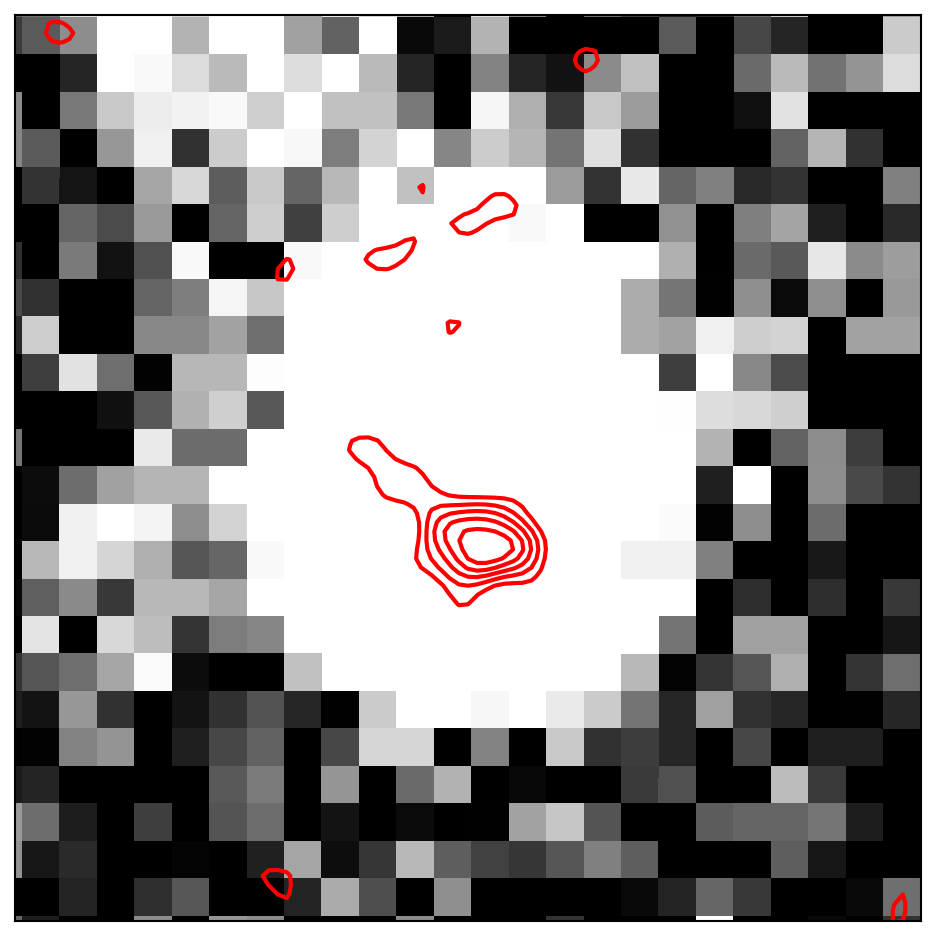

In [433]:
%matplotlib inline
bcg_properties = pd.read_csv("/Users/arames52/bcg_dust_continuum/notebook/data/Derived_Data/bcg_properties.csv")
for bcg_name in good_detections:
    z_alma_fig = offset_plot_stamps(bcg_name)
    z_alma_fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/" + bcg_name + "_z_alma.png", dpi = 300)

In [476]:
import matplotlib.pyplot as plt
import glob
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.lines as mlines
def getImage(path, zoom=0.15):
    return OffsetImage(plt.imread(path), zoom=zoom)

image_path = "/Users/arames52/bcg_dust_continuum/notebook/plots/"
paths = [glob.glob(image_path + key + "_z_alma.png")[0] for key in offset_dict.keys()]
x = [round(val['redshift'],2) for key, val in offset_dict.items()]
y = [round(val['sep_kpc'],1) for key, val in offset_dict.items()]
y[0] = y[0] + 0.2
x[6] = 1.38
fig, ax = plt.subplots(figsize = (40,15))
ax.scatter(x,y)
ax.tick_params(axis='both', which='major', labelsize=50)
ax.tick_params(axis='both', which='minor', labelsize=50)

for x0, y0, path in zip(x, y, paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=True)
    ax.add_artist(ab)
ax.set_xlabel("Redshift", size = 50)
ax.set_ylabel("z-ALMA offset [kpc]", size = 50)
plt.grid()
# plt.xticks(y = -0.05)
fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/offset_z_with_stamps.png", dpi = 300)

In [35]:
def extract_natural_imfit_results():

    with open("/Users/arames52/bcg_dust_continuum/notebook/data/CASA_imaging/natural_imfit_results.pkl", "rb") as f:
        imfit_results = pickle.load(f)

    shape_dict = {}
    flux_dict = {}
    alma_centroid = {}

    for key,val in imfit_results.items():
        flux_dict[key] = [val['deconvolved']['component0']['flux']['value'][0] * 1000, val['deconvolved']['component0']['flux']['error'][0] * 1000, round(val['deconvolved']['component0']['beam']['beamarcsec']['major']['value'],1)]
        shape_dict[key] = [val['deconvolved']['component0']['shape']['majoraxis']['value'], val['deconvolved']['component0']['shape']['majoraxiserror']['value'], val['deconvolved']['component0']['shape']['minoraxis']['value'], 
        val['deconvolved']['component0']['shape']['minoraxiserror']['value'], val['deconvolved']['component0']['shape']['positionangle']['value'], val['deconvolved']['component0']['shape']['positionangleerror']['value']]
        alma_centroid[key] = val['results']['component0']['pixelcoords']
    return flux_dict, shape_dict, alma_centroid

In [36]:
_,shape_dict,_ = extract_natural_imfit_results()

In [ ]:
bcg_redshift_df

In [38]:
from uncertainties import ufloat
from uncertainties.umath import *

In [53]:
gaussian_re = {}
for key,val in shape_dict.items():
    z = bcg_redshift_df[bcg_redshift_df['bcg'] == key]['redshift'].values[0]
    R_maj = ufloat(val[0], val[1])
    R_min = ufloat(val[2], val[3])
    c_fac = (cosmo.kpc_proper_per_arcmin(z)/60).value
    Re = sqrt(R_maj * R_min)/2
    Re_kpc = Re * c_fac
    gaussian_re[key] = Re_kpc

In [78]:
sersic_df = pd.DataFrame({'id': list(sersic_dict.keys()), "n": [val['n'] for val in sersic_dict.values()], "re_arcsec": [val['re'] for val in sersic_dict.values()]})

In [86]:
all_df = master_df.merge(sersic_df, on = 'id', how = 'left')
all_df['re_kpc_sersic'] = all_df['re_arcsec'] * (cosmo.kpc_proper_per_arcmin(np.array(all_df['redshift'])).value)/60

In [140]:
re_kpc_g = pd.DataFrame({"id": [key for key in gaussian_re.keys()],"re_kpc_gaussian":[float(format(gaussian_re[key]).split("+/-")[0]) for key in gaussian_re.keys()],"re_kpc_gaussian_err" : [float(format(gaussian_re[key]).split("+/-")[1]) for key in gaussian_re.keys()]})
re_kpc_g

id  re_kpc_gaussian  re_kpc_gaussian_err
0       CDFS-18             0.59                 0.11
1        ES1-18             2.60                 1.00
2        ES1-25             1.40                 1.30
3    ES1_z_0.99             4.00                 0.70
4    ES1_z_1.04             2.46                 0.35
5    ES1_z_1.38             1.84                 0.22
6    ES1_z_1.40             2.18                 0.28
7    ES1_z_1.60             2.10                 0.40
8    ES1_z_1.65             1.74                 0.07
9    ES1_z_1.70             2.13                 0.15
10      XMM-113             5.00                 0.90
11       XMM-11             4.10                 0.70
12       XMM-29             2.80                 0.70
13       XMM-30             2.40                 1.10
14    XMM_z_0.9             4.10                 0.70
15    XMM_z_1.0             1.10                 0.40
16       ES1-34             4.70                 1.10
17   ES1_z_0.88             1.00                 0.40
18  ES1_z_0.99b             3.80                 0.90
19   XMM_z_0.81             3.10                 0.60

In [141]:
results_df = all_df.merge(re_kpc_g, on = 'id', how = 'left')
results_df

id          SFR     SFR_err  Stellar_mass  Stellar_mass_err  \
0       CDFS-18    23.824306    4.727115  1.538661e+11      1.550262e+10   
1        CDFS19    33.475627    4.083425  1.555707e+11      1.086400e+10   
2    ES1_z_0.88    16.339344    1.017821  6.758220e+10      9.687966e+09   
3    ES1_z_0.99   152.570824  142.756763  7.522039e+10      9.566821e+09   
4   ES1_z_0.99b    36.365577   11.760642  7.119149e+10      2.409869e+10   
5    ES1_z_1.04   312.219795  148.304865  9.512975e+10      1.959103e+10   
6    ES1_z_1.38   779.855401  185.052349  1.231801e+11      1.131030e+10   
7    ES1_z_1.40   785.503591   97.363627  7.781236e+10      1.121162e+10   
8    ES1_z_1.60   682.670994   48.321684  1.453804e+11      1.047361e+10   
9    ES1_z_1.65  1306.491825   86.606746  2.793319e+11      2.580349e+10   
10   ES1_z_1.70    54.777962    4.758204  1.145421e+11      8.975100e+09   
11       ES1-12    47.812017    6.006869  1.995936e+11      3.011822e+10   
12       ES1-18    38.219397    4.054495  1.639366e+11      1.784595e+10   
13       ES1-25    35.479174   20.181078  1.124215e+11      2.072337e+10   
14       ES1-26    50.997303   12.405896  2.988946e+11      2.188373e+10   
15       ES1-34   269.194180   14.891471  6.072108e+11      7.113255e+10   
16       ES1-35   435.795776   60.301348  2.459066e+11      3.289271e+10   
17    XMM_z_0.9    70.836925   19.586493  1.042527e+11      1.300711e+10   
18   XMM_z_0.81   117.641453   55.926071  1.024312e+11      2.219733e+10   
19    XMM_z_1.0    65.761578   22.044591  5.580171e+10      1.894427e+10   
20       XMM-11   461.356198  215.942380  1.246505e+11      3.739041e+10   
21       XMM-19    78.394902    3.919745  8.740998e+10      4.867738e+09   
22       XMM-27   154.177812   32.596748  2.143111e+11      2.945263e+10   
23       XMM-29   621.233288   37.802112  1.403555e+11      1.232890e+10   
24       XMM-30   381.735158   50.399395  1.121162e+11      1.703403e+10   
25      XMM-113   122.218776   89.956725  3.950012e+11      8.475127e+10   

    reduced_chi_square  redshift  spec_z          sSFR      sSFR_err  \
0             9.306043  0.807580       1  1.548379e-10  3.445627e-11   
1             1.182378  0.694840       1  2.151794e-10  3.024499e-11   
2             2.009905  0.563950       1  2.417699e-10  3.778875e-11   
3             1.244926  1.193720       1  2.028317e-09  1.915299e-09   
4             1.009473  0.918860       1  5.108135e-10  2.391424e-10   
5             5.153100  1.040000       0  3.282042e-09  1.699191e-09   
6             5.326554  1.380000       0  6.331018e-09  1.610838e-09   
7             5.085912  1.400000       0  1.009484e-08  1.918666e-09   
8             9.750097  1.600000       0  4.695757e-09  4.742585e-10   
9             5.305960  1.650000       0  4.677203e-09  5.317956e-10   
10            2.810916  0.916510       1  4.782344e-10  5.594521e-11   
11            2.378459  0.747440       1  2.395469e-10  4.703564e-11   
12            1.720605  0.806800       1  2.331352e-10  3.543672e-11   
13            1.620694  1.088070       1  3.155908e-10  1.887038e-10   
14            2.953507  0.851920       1  1.706197e-10  4.334503e-11   
15            3.619022  1.700000       0  4.433290e-10  5.743367e-11   
16            2.413791  1.700000       0  1.772201e-09  3.410666e-10   
17            0.715005  0.849570       1  6.794732e-10  2.061160e-10   
18            2.232051  0.782721       1  1.148493e-09  6.000373e-10   
19            6.436920  0.535235       1  1.178487e-09  5.622600e-10   
20            1.790640  0.790000       0  3.701197e-09  2.057604e-09   
21            5.393139  1.047890       1  8.968644e-10  6.712248e-11   
22            6.010726  1.380000       0  7.194113e-10  1.814094e-10   
23            3.043430  1.450000       0  4.426140e-09  4.729696e-10   
24            1.367169  1.450000       0  3.404818e-09  6.853288e-10   
25            2.354772  1.600000       0  3.094137e-10  2.372169e-10   

     sSFR_gyr  

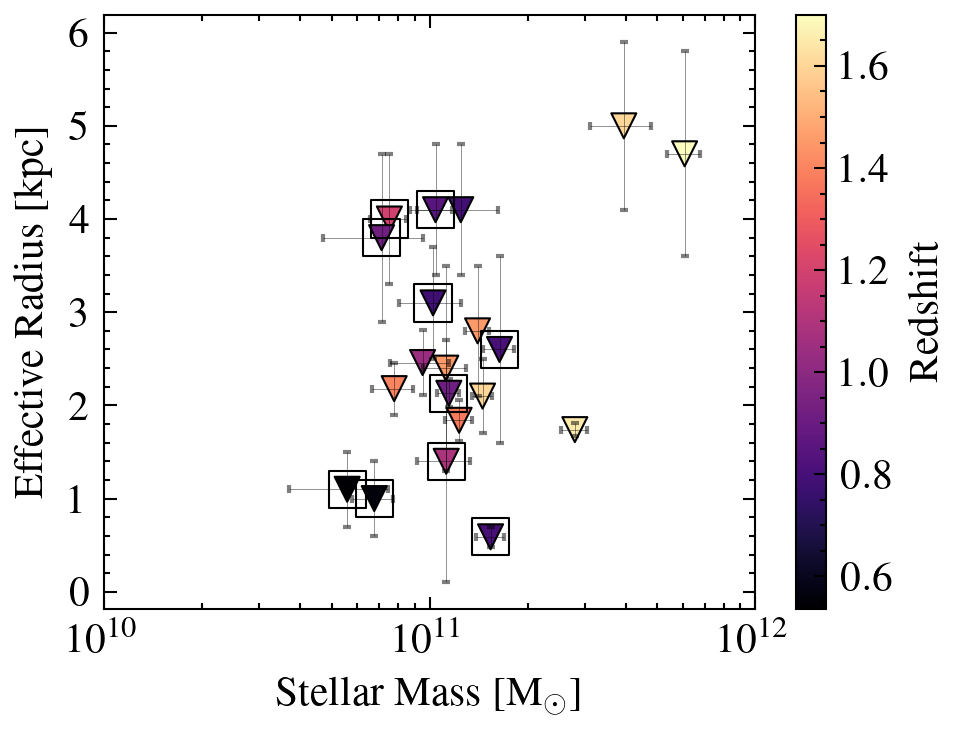

In [427]:
%matplotlib inline
plt.style.use("science")
specz = results_df[results_df['spec_z'] == 1]
fig,ax = plt.subplots(1,1, dpi = 300)
im = ax.scatter(results_df['Stellar_mass'], results_df['re_kpc_gaussian'], marker = 'v', edgecolor = 'black', c = results_df['redshift'], cmap = 'magma', linewidth = 0.5)
ax.scatter(specz['Stellar_mass'], specz['re_kpc_gaussian'], marker = 's', edgecolor = 'black', linewidth = 0.5, facecolor = 'none', s = 80)
ax.errorbar(results_df['Stellar_mass'], results_df['re_kpc_gaussian'], xerr = results_df['Stellar_mass_err'], yerr=results_df['re_kpc_gaussian_err'],ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=1, elinewidth = 0.2)
ax.set_xscale('log')
ax.set_ylabel("Effective Radius [kpc]", size = 10)
ax.set_xlabel("Stellar Mass [M$_\odot$]", size = 10)
ax.set_xlim(10**10, 10**12)
cbar_ax = fig.colorbar(im)
cbar_ax.set_label("Redshift", size = 10)
fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/re_mstar_z.png", dpi = 300)

<ipython-input-425-264c83bcba57>:14: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar_ax = fig.colorbar(im)


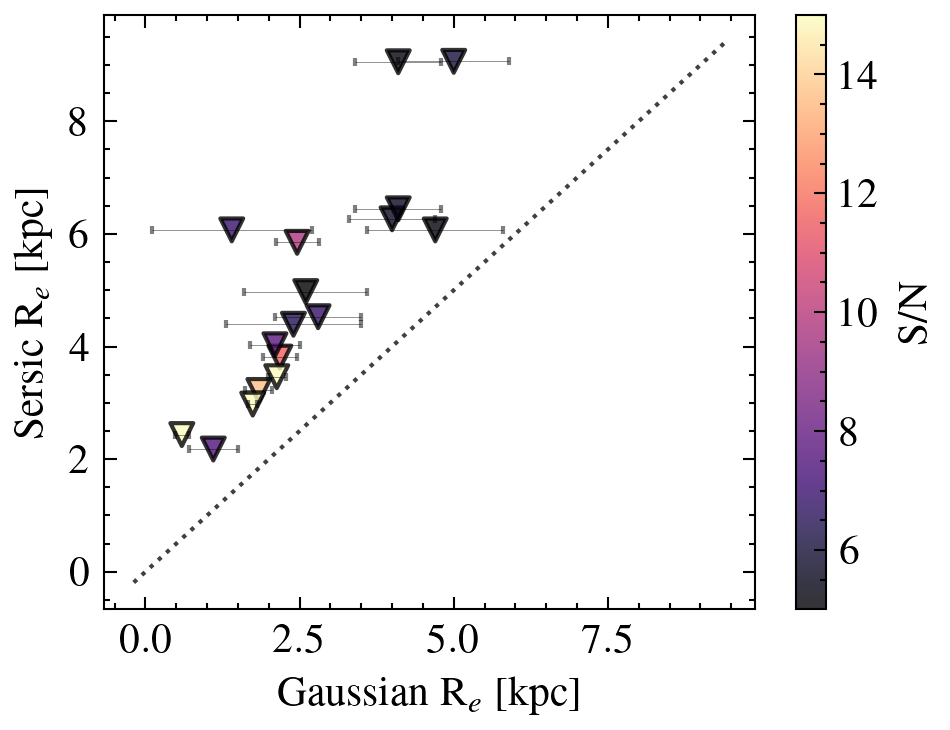

In [425]:
plt.style.use("science")
fig,ax = plt.subplots(1,1, dpi = 300)
vmin = 5
vmax = 15
ax.scatter(master_df['re_kpc_gaussian'], master_df['re_kpc_sersic'], marker = 'v', s =  30, alpha = 0.8, edgecolor = 'black', c = master_df['S/N'], cmap = 'magma', vmin = vmin, vmax = vmax)
ax.errorbar(master_df['re_kpc_gaussian'], master_df['re_kpc_sersic'], xerr=master_df['re_kpc_gaussian_err'], ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=1, elinewidth = 0.2)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, ':', color = 'black',alpha=0.75, zorder=0)
cbar_ax = fig.colorbar(im)
cbar_ax.set_label("S/N", size = 10)

ax.set_xlabel("Gaussian R$_e$ [kpc]")
ax.set_ylabel("Sersic R$_e$ [kpc]")
fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/re_g_s.png", dpi = 300)

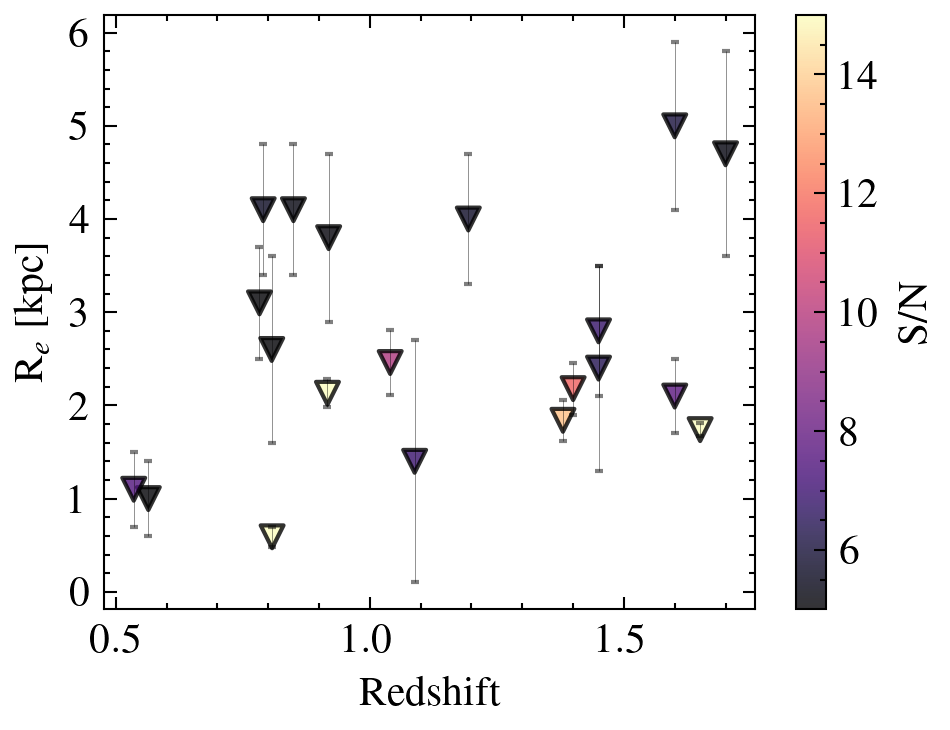

In [426]:
fig,ax = plt.subplots(1,1, dpi = 300)
vmin = 5
vmax = 15
im=ax.scatter(master_df['redshift'], master_df['re_kpc_gaussian'], c = master_df['S/N'], marker = 'v', s =  30, alpha = 0.8, edgecolor = 'black', cmap = 'magma', vmin = vmin, vmax = vmax)
ax.errorbar(master_df['redshift'], master_df['re_kpc_gaussian'], yerr=master_df['re_kpc_gaussian_err'], ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=1, elinewidth = 0.2)
# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]

# # now plot both limits against eachother
# ax.plot(lims, lims, ':', color = 'black',alpha=0.75, zorder=0)
cbar_ax = fig.colorbar(im)
cbar_ax.set_label("S/N", size = 10)
ax.set_ylabel("R$_e$ [kpc]")
ax.set_xlabel("Redshift")
fig.savefig("/Users/arames52/bcg_dust_continuum/notebook/plots/re_z_sn.png", dpi = 300)
# ax.set_xscale('log')
# ax.set_yscale('log')

In [386]:
table_df = master_df[['id', 'SFR', 'SFR_err', 'Stellar_mass', 'Stellar_mass_err', 'redshift','spec_z','sSFR_gyr', 'sSFR_err_gyr', 'S/N', 'n', 're_kpc_sersic', 're_kpc_gaussian','re_kpc_gaussian_err']]

In [387]:
table_df = table_df.fillna(0)

In [388]:
table_df['SFR_value'] = unumpy.uarray(list(table_df['SFR']), list(table_df['SFR_err']))
table_df['Stellar_mass_value'] = unumpy.uarray(list(table_df['Stellar_mass']/1e10), list(table_df['Stellar_mass_err']/1e10))
table_df['sSFR_value[gyr]'] = unumpy.uarray(list(table_df['sSFR_gyr']), list(table_df['sSFR_err_gyr']))
table_df['Re_kpc_gaussian']= unumpy.uarray(list(table_df['re_kpc_gaussian']), list(table_df['re_kpc_gaussian_err']))

In [389]:
paper_columns = ['id', 'SFR_value', 'Stellar_mass_value', 'sSFR_value[gyr]', 'Re_kpc_gaussian', 're_kpc_sersic', 'n', 'redshift', 'spec_z', 'S/N']
table_df = table_df[paper_columns]
table_df.loc[table_df["spec_z"] == 1, "spec_z"] = 's'
table_df.loc[table_df["spec_z"] == 0, "spec_z"] = 'p'
table_df = table_df.rename(columns = {"SFR_value":"SFR", "Stellar_mass_value":"stellar mass", "sSFR_value[gyr]": "sSFR [Gyr]", "Re_kpc_gaussian": "Re_gaussian [kpc]",
"re_kpc_sersic": "Re_sersic [kpc]", 'redshift':'z'})

In [390]:
table_df.fillna('-')

id                SFR stellar mass     sSFR [Gyr]  \
0       CDFS-18             24+/-5   15.4+/-1.6  0.155+/-0.034   
1        CDFS19             33+/-4   15.6+/-1.1  0.215+/-0.030   
2    ES1_z_0.88         16.3+/-1.0    6.8+/-1.0    0.24+/-0.04   
3    ES1_z_0.99    (1.5+/-1.4)e+02    7.5+/-1.0      2.0+/-1.9   
4   ES1_z_0.99b            36+/-12    7.1+/-2.4    0.51+/-0.24   
5    ES1_z_1.04    (3.1+/-1.5)e+02    9.5+/-2.0      3.3+/-1.7   
6    ES1_z_1.38    (7.8+/-1.9)e+02   12.3+/-1.1      6.3+/-1.6   
7    ES1_z_1.40    (7.9+/-1.0)e+02    7.8+/-1.1     10.1+/-1.9   
8    ES1_z_1.60    (6.8+/-0.5)e+02   14.5+/-1.0      4.7+/-0.5   
9    ES1_z_1.65  (1.31+/-0.09)e+03   27.9+/-2.6      4.7+/-0.5   
10   ES1_z_1.70             55+/-5   11.5+/-0.9    0.48+/-0.06   
11       ES1-12             48+/-6   20.0+/-3.0    0.24+/-0.05   
12       ES1-18             38+/-4   16.4+/-1.8  0.233+/-0.035   
13       ES1-25            35+/-20   11.2+/-2.1    0.32+/-0.19   
14       ES1-26            51+/-12   29.9+/-2.2    0.17+/-0.04   
15       ES1-34           269+/-15       61+/-7    0.44+/-0.06   
16       ES1-35    (4.4+/-0.6)e+02   24.6+/-3.3    1.77+/-0.34   
17    XMM_z_0.9            71+/-20   10.4+/-1.3    0.68+/-0.21   
18   XMM_z_0.81    (1.2+/-0.6)e+02   10.2+/-2.2      1.1+/-0.6   
19    XMM_z_1.0            66+/-22    5.6+/-1.9      1.2+/-0.6   
20       XMM-11    (4.6+/-2.2)e+02       12+/-4      3.7+/-2.1   
21       XMM-19             78+/-4    8.7+/-0.5    0.90+/-0.07   
22       XMM-27           154+/-33   21.4+/-2.9    0.72+/-0.18   
23       XMM-29    (6.2+/-0.4)e+02   14.0+/-1.2      4.4+/-0.5   
24       XMM-30    (3.8+/-0.5)e+02   11.2+/-1.7      3.4+/-0.7   
25      XMM-113    (1.2+/-0.9)e+02       40+/-8    0.31+/-0.24   

   Re_gaussian [kpc]  Re_sersic [kpc]         n         z spec_z     S/N  
0        0.59+/-0.11         2.436514  0.517901  0.807580      s  157.48  
1            0.0+/-0         0.000000  0.000000  0.694840      s    3.77  
2          1.0+/-0.4         0.000000  0.000000  0.563950      s    3.63  
3          4.0+/-0.7         6.267832  1.091314  1.193720      s    5.69  
4          3.8+/-0.9         0.000000  0.000000  0.918860      s    5.16  
5        2.46+/-0.35         5.850084  1.182628  1.040000      p    9.79  
6        1.84+/-0.22         3.219427  0.894561  1.380000      p   13.64  
7        2.18+/-0.28         3.811900  0.946995  1.400000      p   11.63  
8          2.1+/-0.4         4.031358  0.949766  1.600000      p    7.73  
9        1.74+/-0.07         2.977360  2.261621  1.650000      p   58.66  
10       2.13+/-0.15         3.463945  0.539183  0.916510      s   16.94  
11           0.0+/-0         0.000000  0.000000  0.747440      s    3.50  
12         2.6+/-1.0         4.975356  0.962718  0.806800      s    4.91  
13         1.4+/-1.3         6.071356  0.795484  1.088070      s    6.95  
14           0.0+/-0         0.000000  0.000000  0.851920      s    3.22  
15         4.7+/-1.1         6.070675  1.078542  1.700000      p    5.27  
16           0.0+/-0         0.000000  0.000000  1.700000      p    2.81  
17         4.1+/-0.7         9.056891  1.043504  0.849570      s    5.28  
18         3.1+/-0.6         0.000000  0.000000  0.782721      s    5.02  
19         1.1+/-0.4         2.179213  1.783705  0.535235      s    7.47  
20         4.1+/-0.7         6.445746  0.281218  0.790000      p    5.60  
21           0.0+/-0         0.000000  0.000000  1.047890      s    2.94  
22           0.0+/-0         0.000000  0.000000  1.380000      p    3.10  
23         2.8+/-0.7         4.529345  1.313272  1.450000      p    6.81  
24         2.4+/-1.1         4.394973  0.412788  1.450000      p    6.41  
25         5.0+/-0.9         9.064433  1.436219  1.600000      p    6.07

In [420]:
format_mapping = {"z": "{:,.2f}", 'S/N': "{:,.1f}", 'n': "{:,.1f}", 'Re_sersic [kpc]': "{:,.2f}", 'SFR': "{:,.1f}",'stellar mass': "{:,.1f}",
'sSFR [Gyr]': "{:,.1f}", "Re_gaussian [kpc]": "{:,.1f}"}

In [421]:
final_table_df = table_df.style.format(format_mapping)

In [416]:
import openpyxl

In [417]:
final_table_df.to_excel("/Users/arames52/bcg_dust_continuum/notebook/paper_table.xlsx", index=False)

In [422]:
final_table_df